In [1]:
from pathlib import Path
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

import matplotlib.pyplot as plt
import glob
import os

DATA_PATH = Path( "../Data/processed/data_G/Boris")
list_boris = []
list_boris_agregated = []

# Récupérer tous les fichiers parquet dans le dossier
all_files = list(DATA_PATH.glob("*_processed.parquet"))


# Séparer les fichiers aggregated des autres
boris_agregated_files = [f for f in all_files if "agregated" in f.name]
boris_files = [f for f in all_files if "agregated" not in f.name]

# Charger les fichiers aggregated
for file_path in boris_agregated_files:
    boris_agregated = pd.read_parquet(file_path)
    list_boris_agregated.append(boris_agregated)

# Charger les autres fichiers
for file_path in boris_files:
    boris = pd.read_parquet(file_path)
    list_boris.append(boris)

print(f"Nombre de fichiers aggregated: {len(boris_agregated_files)}")
print(f"Nombre d'autres fichiers: {len(boris_files)}")

Nombre de fichiers aggregated: 12
Nombre d'autres fichiers: 11


In [2]:
# Séparer les fichiers par groupe (P ou C entre le 3ème et 4ème underscore)
list_boris_agregated_patient = []
list_boris_agregated_control = []
list_boris_patient = []
list_boris_control = []

# Fonction pour extraire le groupe du nom de fichier
def extract_group_from_filename(filename):
    """Extrait le groupe (P ou C) du nom de fichier.
    Format attendu: ID_Name_Study_Group_Month_Visit_Date
    Le groupe est à la position 3 (4ème élément après split par _)
    """
    # Enlever les suffixes comme _processed, _agregated, etc.
    name = filename.replace("_processed", "").replace("_agregated", "").replace("-aggregated", "")
    # Enlever l'extension
    name = name.split(".")[0]
    # Split par underscore
    parts = name.split("_")
    if len(parts) >= 4:
        group_code = parts[3]  # Position 3 = 4ème élément
        return group_code
    return None

# Charger les fichiers aggregated par groupe
for file_path in boris_agregated_files:
    group = extract_group_from_filename(file_path.name)
    
    boris_agregated = pd.read_parquet(file_path)
    
    if group == "P":
        list_boris_agregated_patient.append(boris_agregated)
    elif group == "C":
        list_boris_agregated_control.append(boris_agregated)

# Charger les autres fichiers par groupe
for file_path in boris_files:
    group = extract_group_from_filename(file_path.name)
    boris = pd.read_parquet(file_path)
    
    if group == "P":
        list_boris_patient.append(boris)
    elif group == "C":
        list_boris_control.append(boris)

print(f"Fichiers aggregated - Patient: {len(list_boris_agregated_patient)}, Control: {len(list_boris_agregated_control)}")
print(f"Autres fichiers - Patient: {len(list_boris_patient)}, Control: {len(list_boris_control)}")

Fichiers aggregated - Patient: 4, Control: 8
Autres fichiers - Patient: 4, Control: 7


In [3]:
id = 1
boris = list_boris[id]

boris_agregated = list_boris_agregated[id]

boris.info()
boris_agregated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Total number of occurences      31 non-null     int64  
 1   Total duration (s)              31 non-null     float64
 2   Duration mean (s)               31 non-null     float64
 3   Duration std dev                31 non-null     float64
 4   inter-event intervals mean (s)  31 non-null     float64
 5   inter-event intervals std dev   31 non-null     float64
 6   % of total length               31 non-null     float64
 7   Behavior_category               31 non-null     object 
 8   Behavior_detail                 31 non-null     object 
dtypes: float64(6), int64(1), object(2)
memory usage: 2.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------  

In [48]:
#|
id = 7
boris = list_boris[id]

boris[(boris['Behavior_category']=="TA.") | (boris['Behavior_detail']=='Test Gateau en cours')].head()

,Total number of occurences,Total duration (s),Duration mean (s),Duration std dev,inter-event intervals mean (s),inter-event intervals std dev,% of total length,Behavior_category,Behavior_detail
14,1,1027.36,1027.36,0.0,0.0,0.0,95.7,Te.,Test Gateau en cours
22,1,0.00,0.00,0.0,0.0,0.0,0.0,TA.,lecture INITIALE


In [5]:
id = 6
boris_agregated = list_boris_agregated[id]

display(boris_agregated.iloc[:, :].head())

i = 5
print(boris_agregated.iloc[:, i].unique())
print(len(boris_agregated.iloc[:, i].unique()))

,Behavioral category,Behavior type,Start (s),Stop (s),Duration (s),Behavior_category,Behavior_detail
0,operateur,STATE,24.775,90.507,65.732,O.,Presentation
1,tache,STATE,91.508,1316.982,1225.474,Te.,Test Gateau en cours
2,test,STATE,93.343,136.845,43.502,TA.,lecture INITIALE
3,tache,STATE,99.266,137.679,38.413,Ta.,Regard recette
4,test,STATE,139.139,344.427,205.288,Te.,P1 : Faire fondre chocolat et beurre


['O.' 'Te.' 'TA.' 'Ta.' 'E.D.' 'E.N.' 'autre' 'betise']
8


In [6]:
# Combiner tous les DataFrames par groupe pour les fichiers aggregated
df_patient_all = pd.concat(list_boris_agregated_patient, ignore_index=True)


df_control_all = pd.concat(list_boris_agregated_control, ignore_index=True)

# Combiner tous les DataFrames (Patient + Control) pour l'histogramme global
df_all = pd.concat([df_patient_all, df_control_all], ignore_index=True)

print(f"Nombre total d'événements - Patient: {len(df_patient_all)}, Control: {len(df_control_all)}, Total: {len(df_all)}")

Nombre total d'événements - Patient: 482, Control: 596, Total: 1078


In [7]:
def plot_frequency_histograms_by_group(patient_dataframes, control_dataframes, 
                                       column_name, title_suffix, 
                                       category_color_map=None, detail_to_category_map=None):
    """Crée un histogramme avec moyenne et écart-type normalisés par nombre de participants.
    
    Args:
        patient_dataframes: Liste de DataFrames pour le groupe Patient (un par participant)
        control_dataframes: Liste de DataFrames pour le groupe Control (un par participant)
        column_name: Nom de la colonne ('Behavior_category' ou 'Behavior_detail')
        title_suffix: Suffixe pour le titre (ex: 'Behavior_category')
        category_color_map: Dict de mapping valeur -> couleur (pour Behavior_category)
        detail_to_category_map: Dict de mapping detail -> category (pour Behavior_detail)
    """
    def calculate_stats_per_participant(dataframes_list):
        """Calcule les fréquences par participant puis les stats."""
        participant_freqs = {}
        for participant_idx, df in enumerate(dataframes_list):
            participant_freqs[participant_idx] = {}
            if column_name in df.columns:
                value_counts = df[column_name].value_counts()
                for value, count in value_counts.items():
                    participant_freqs[participant_idx][value] = count
        
        # Calculer moyenne et écart-type pour chaque valeur
        all_values = set()
        for participant_data in participant_freqs.values():
            all_values.update(participant_data.keys())
        
        stats = {}
        for value in all_values:
            frequencies = [participant_data.get(value, 0) 
                          for participant_data in participant_freqs.values()]
            stats[value] = {
                'mean': np.mean(frequencies),
                'std': np.std(frequencies, ddof=1) if len(frequencies) > 1 else 0,
                'n': len(frequencies)
            }
        return stats
    
    # Calculer les statistiques
    patient_stats = calculate_stats_per_participant(patient_dataframes)
    control_stats = calculate_stats_per_participant(control_dataframes)
    
    # Créer la figure avec 2 sous-graphiques
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Fonction pour créer un histogramme
    def plot_single_histogram(ax, stats_dict, group_name, n_participants, color_map, detail_map):
        if not stats_dict:
            ax.text(0.5, 0.5, 'Pas de données', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=14)
            ax.set_title(f'{group_name} - {title_suffix}', fontsize=14, fontweight='bold')
            return
        
        # Trier par moyenne décroissante
        sorted_items = sorted(stats_dict.items(), key=lambda x: x[1]['mean'], reverse=True)
        values = [item for item, _ in sorted_items]
        means = [stat['mean'] for _, stat in sorted_items]
        stds = [stat['std'] for _, stat in sorted_items]
        
        # Assigner les couleurs
        if detail_map and color_map:
            colors = [color_map.get(detail_map.get(val, values[0] if values else ""), 'gray') 
                     for val in values]
        elif color_map:
            colors = [color_map.get(val, 'gray') for val in values]
        else:
            n = len(values)
            colors = plt.cm.Set3(np.linspace(0, 1, n))
        
        x_pos = np.arange(len(values))
        bars = ax.bar(x_pos, means, yerr=stds, color=colors, alpha=0.7,
                     capsize=5, error_kw={'elinewidth': 2, 'capthick': 2})
        
        ax.set_xlabel('Comportement', fontsize=12)
        ax.set_ylabel('Fréquence moyenne par participant', fontsize=12)
        ax.set_title(f'{group_name} - {title_suffix}\n(n={n_participants} participants)', 
                    fontsize=14, fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(values, rotation=45, ha='right')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Ajouter les valeurs sur les barres
        max_mean = max(means) if means else 1
        for bar, mean, std in zip(bars, means, stds):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + max_mean*0.02,
                   f'{mean:.1f}±{std:.1f}', ha='center', va='bottom', fontsize=8)
    
    # Créer les histogrammes
    plot_single_histogram(axes[0], patient_stats, 'Patient', len(patient_dataframes),
                         category_color_map, detail_to_category_map)
    plot_single_histogram(axes[1], control_stats, 'Control', len(control_dataframes),
                         category_color_map, detail_to_category_map)
    
    plt.tight_layout()
    plt.show()

    # Créer le mapping detail -> category pour les couleurs

def create_detail_to_category_mapping(dataframes_list):
    """Crée un mapping Behavior_detail -> Behavior_category."""
    detail_to_category = {}
    for df in dataframes_list:
        if "Behavior_detail" in df.columns and "Behavior_category" in df.columns:
            for _, row in df.iterrows():
                detail = row["Behavior_detail"]
                category = row["Behavior_category"]
                if detail not in detail_to_category:
                    detail_to_category[detail] = category
    return detail_to_category

# Créer le color map pour les catégories
all_patient_cats = set()
all_control_cats = set()
for df in list_boris_agregated_patient:
    if "Behavior_category" in df.columns:
        all_patient_cats.update(df["Behavior_category"].unique())
for df in list_boris_agregated_control:
    if "Behavior_category" in df.columns:
        all_control_cats.update(df["Behavior_category"].unique())

all_categories = sorted(all_patient_cats | all_control_cats)
category_color_map = {cat: plt.cm.Set3(i/len(all_categories)) 
                     for i, cat in enumerate(all_categories)}

# Créer les mappings detail -> category
patient_detail_to_cat = create_detail_to_category_mapping(list_boris_agregated_patient)
control_detail_to_cat = create_detail_to_category_mapping(list_boris_agregated_control)
all_detail_to_cat = {**patient_detail_to_cat, **control_detail_to_cat}

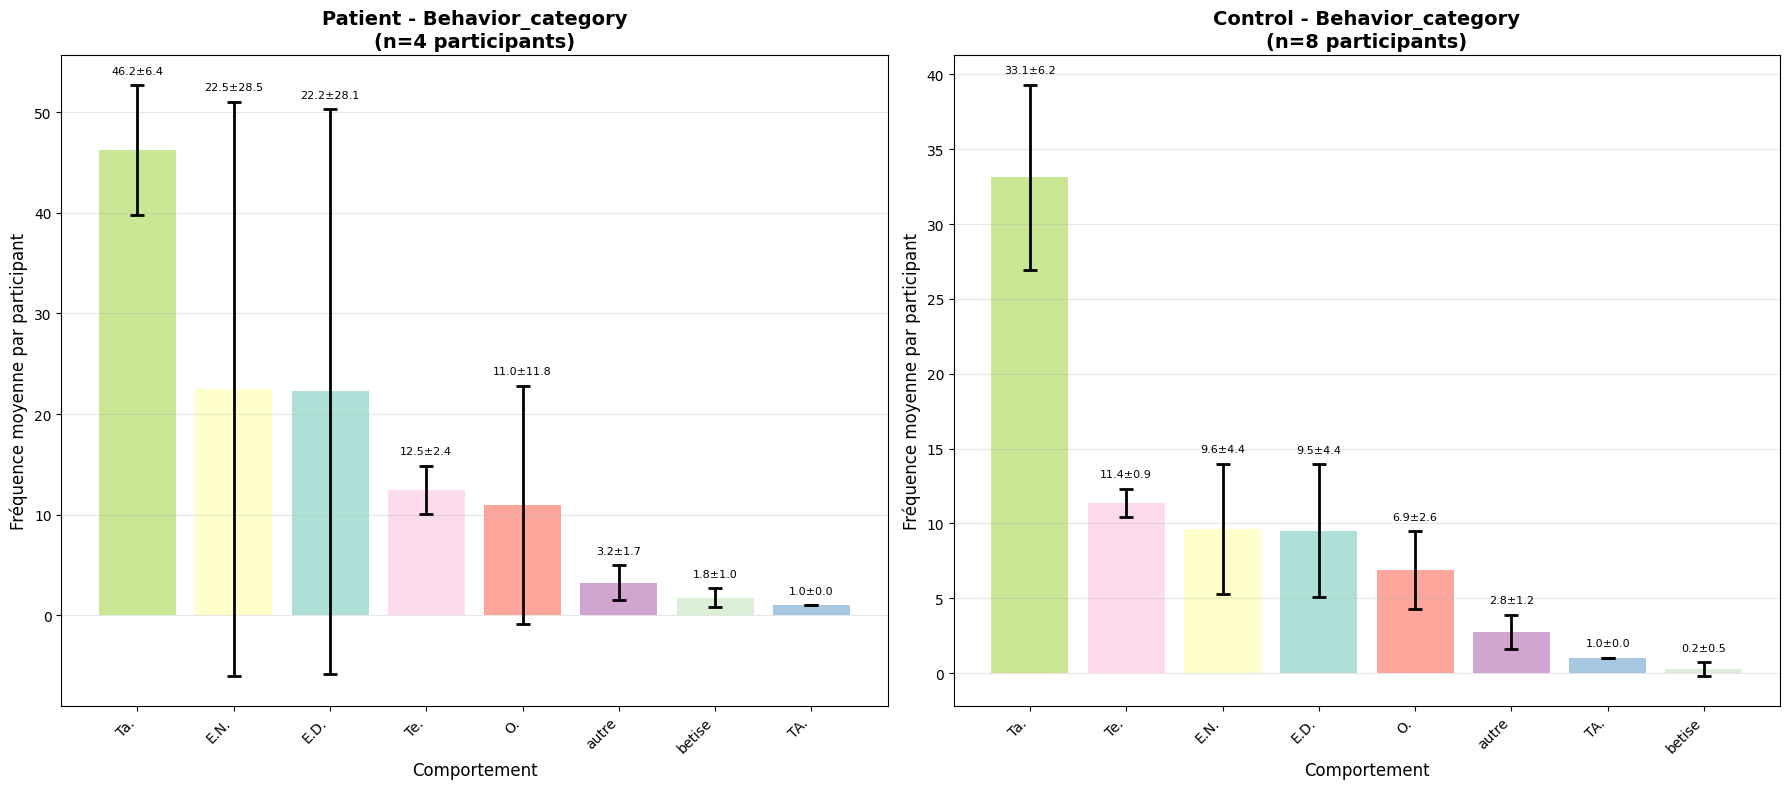

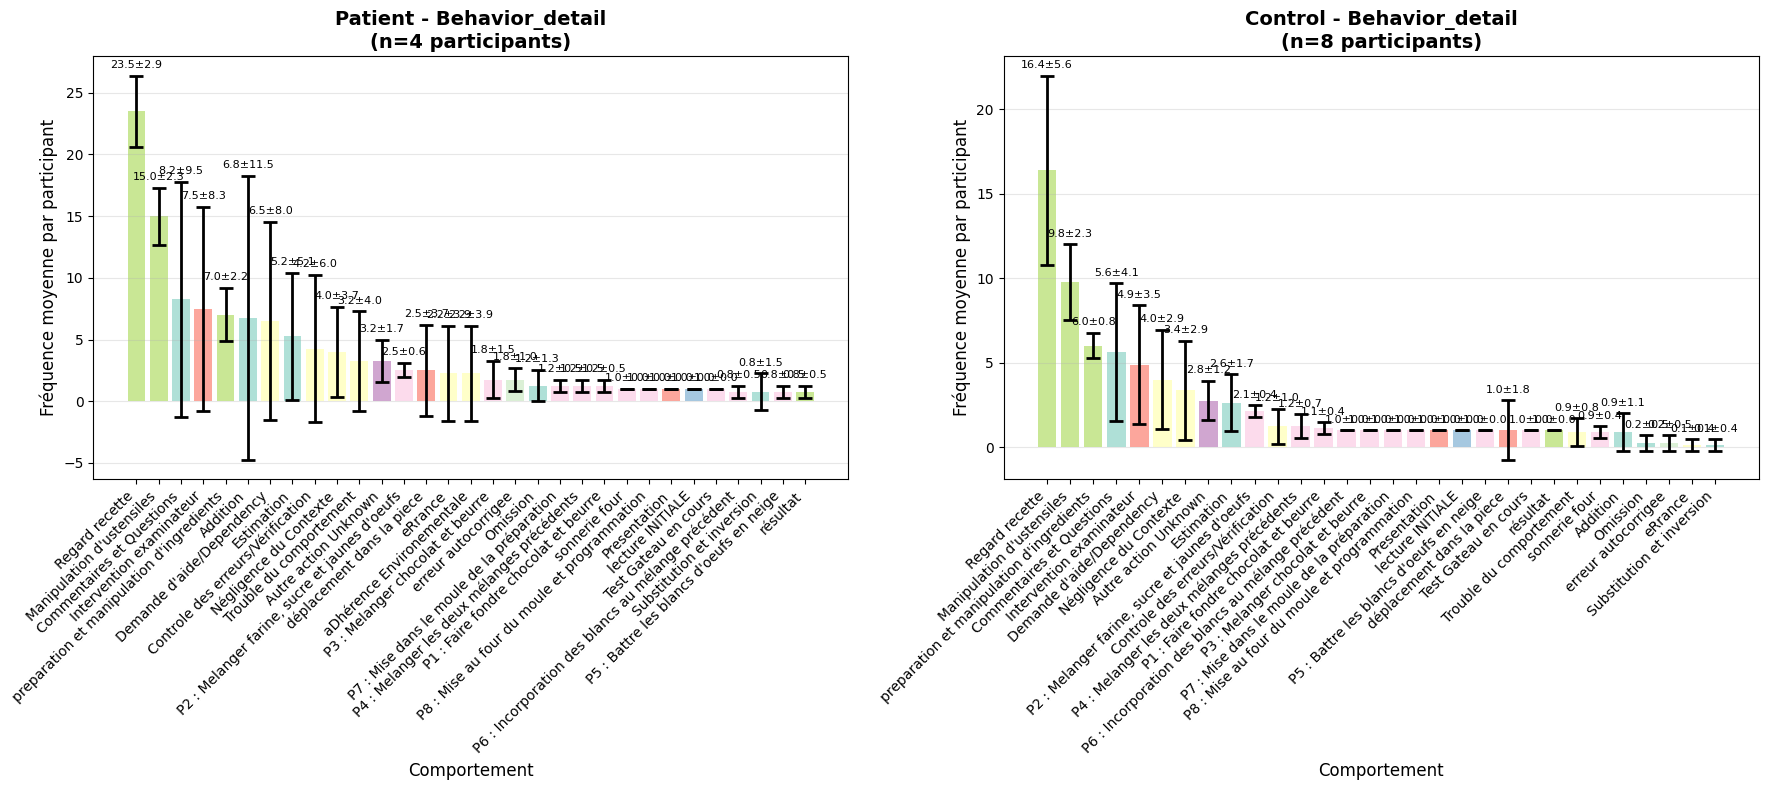

In [8]:
# Créer les 4 histogrammes
# 1. Behavior_category
plot_frequency_histograms_by_group(
    list_boris_agregated_patient,
    list_boris_agregated_control,
    'Behavior_category',
    'Behavior_category',
    category_color_map=category_color_map
)

# 2. Behavior_detail
plot_frequency_histograms_by_group(
    list_boris_agregated_patient,
    list_boris_agregated_control,
    'Behavior_detail',
    'Behavior_detail',
    category_color_map=category_color_map,
    detail_to_category_map=all_detail_to_cat
)

In [9]:
def plot_individual_values_by_category(patient_dataframes, control_dataframes, 
                                      column_name, title_suffix,
                                      category_color_map=None, detail_to_category_map=None):
    """Visualise les valeurs individuelles de chaque participant par catégorie.
    
    Args:
        patient_dataframes: Liste de DataFrames pour le groupe Patient
        control_dataframes: Liste de DataFrames pour le groupe Control
        column_name: Nom de la colonne ('Behavior_category' ou 'Behavior_detail')
        title_suffix: Suffixe pour le titre
        category_color_map: Dict de mapping valeur -> couleur
        detail_to_category_map: Dict de mapping detail -> category
    """
    def get_frequencies_per_participant(dataframes_list):
        """Calcule les fréquences par participant."""
        participant_freqs = {}
        for participant_idx, df in enumerate(dataframes_list):
            participant_freqs[participant_idx] = {}
            if column_name in df.columns:
                value_counts = df[column_name].value_counts()
                for value, count in value_counts.items():
                    participant_freqs[participant_idx][value] = count
        return participant_freqs
    
    # Calculer les fréquences par participant
    patient_freqs = get_frequencies_per_participant(patient_dataframes)
    control_freqs = get_frequencies_per_participant(control_dataframes)
    
    # Récupérer toutes les valeurs uniques
    all_patient_values = set()
    for participant_data in patient_freqs.values():
        all_patient_values.update(participant_data.keys())
    
    all_control_values = set()
    for participant_data in control_freqs.values():
        all_control_values.update(participant_data.keys())
    
    all_values = sorted(all_patient_values | all_control_values)
    
    # Créer la figure avec 2 sous-graphiques
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    def plot_single_group(ax, participant_freqs, group_name, n_participants, 
                          all_values, color_map, detail_map):
        """Crée un graphique avec les valeurs individuelles."""
        if not participant_freqs:
            ax.text(0.5, 0.5, 'Pas de données', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=14)
            ax.set_title(f'{group_name} - {title_suffix}', fontsize=14, fontweight='bold')
            return
        
        # Préparer les données pour le graphique
        x_positions = []
        y_values = []
        colors_list = []
        participant_labels = []
        
        for value_idx, value in enumerate(all_values):
            x_base = value_idx
            participant_values = []
            
            # Récupérer la fréquence de cette valeur pour chaque participant
            for participant_idx, participant_data in participant_freqs.items():
                freq = participant_data.get(value, 0)
                if freq > 0:  # Ne montrer que les valeurs non nulles si vous préférez
                    participant_values.append((participant_idx, freq))
            
            # Assigner les couleurs
            if detail_map and color_map:
                color = color_map.get(detail_map.get(value, ""), 'gray')
            elif color_map:
                color = color_map.get(value, 'gray')
            else:
                color = plt.cm.Set3(value_idx / len(all_values))
            
            # Positionner les points avec un léger décalage pour éviter le chevauchement
            for i, (participant_idx, freq) in enumerate(participant_values):
                x_pos = x_base + (i - len(participant_values)/2 + 0.5) * 0.15
                x_positions.append(x_pos)
                y_values.append(freq)
                colors_list.append(color)
                participant_labels.append(f'P{participant_idx+1}')
        
        # Créer le graphique avec des points
        scatter = ax.scatter(x_positions, y_values, c=colors_list, alpha=0.6, s=100, edgecolors='black', linewidth=1)
        
        # Ajouter les moyennes et écarts-types
        for value_idx, value in enumerate(all_values):
            frequencies = [participant_data.get(value, 0) 
                          for participant_data in participant_freqs.values()]
            if frequencies:
                mean = np.mean(frequencies)
                std = np.std(frequencies, ddof=1) if len(frequencies) > 1 else 0
                
                # Barre d'erreur pour la moyenne
                ax.errorbar(value_idx, mean, yerr=std, fmt='o', color='red', 
                           markersize=10, capsize=5, capthick=2, 
                           label='Moyenne ± écart-type' if value_idx == 0 else '')
        
        ax.set_xlabel('Comportement', fontsize=12)
        ax.set_ylabel('Fréquence par participant', fontsize=12)
        ax.set_title(f'{group_name} - {title_suffix}\n(n={n_participants} participants)', 
                    fontsize=14, fontweight='bold')
        ax.set_xticks(range(len(all_values)))
        ax.set_xticklabels(all_values, rotation=45, ha='right')
        ax.grid(True, alpha=0.3, axis='y')
        ax.legend()
    
    # Créer les graphiques
    plot_single_group(axes[0], patient_freqs, 'Patient', len(patient_dataframes),
                     all_values, category_color_map, detail_to_category_map)
    plot_single_group(axes[1], control_freqs, 'Control', len(control_dataframes),
                     all_values, category_color_map, detail_to_category_map)
    
    plt.tight_layout()
    plt.show()

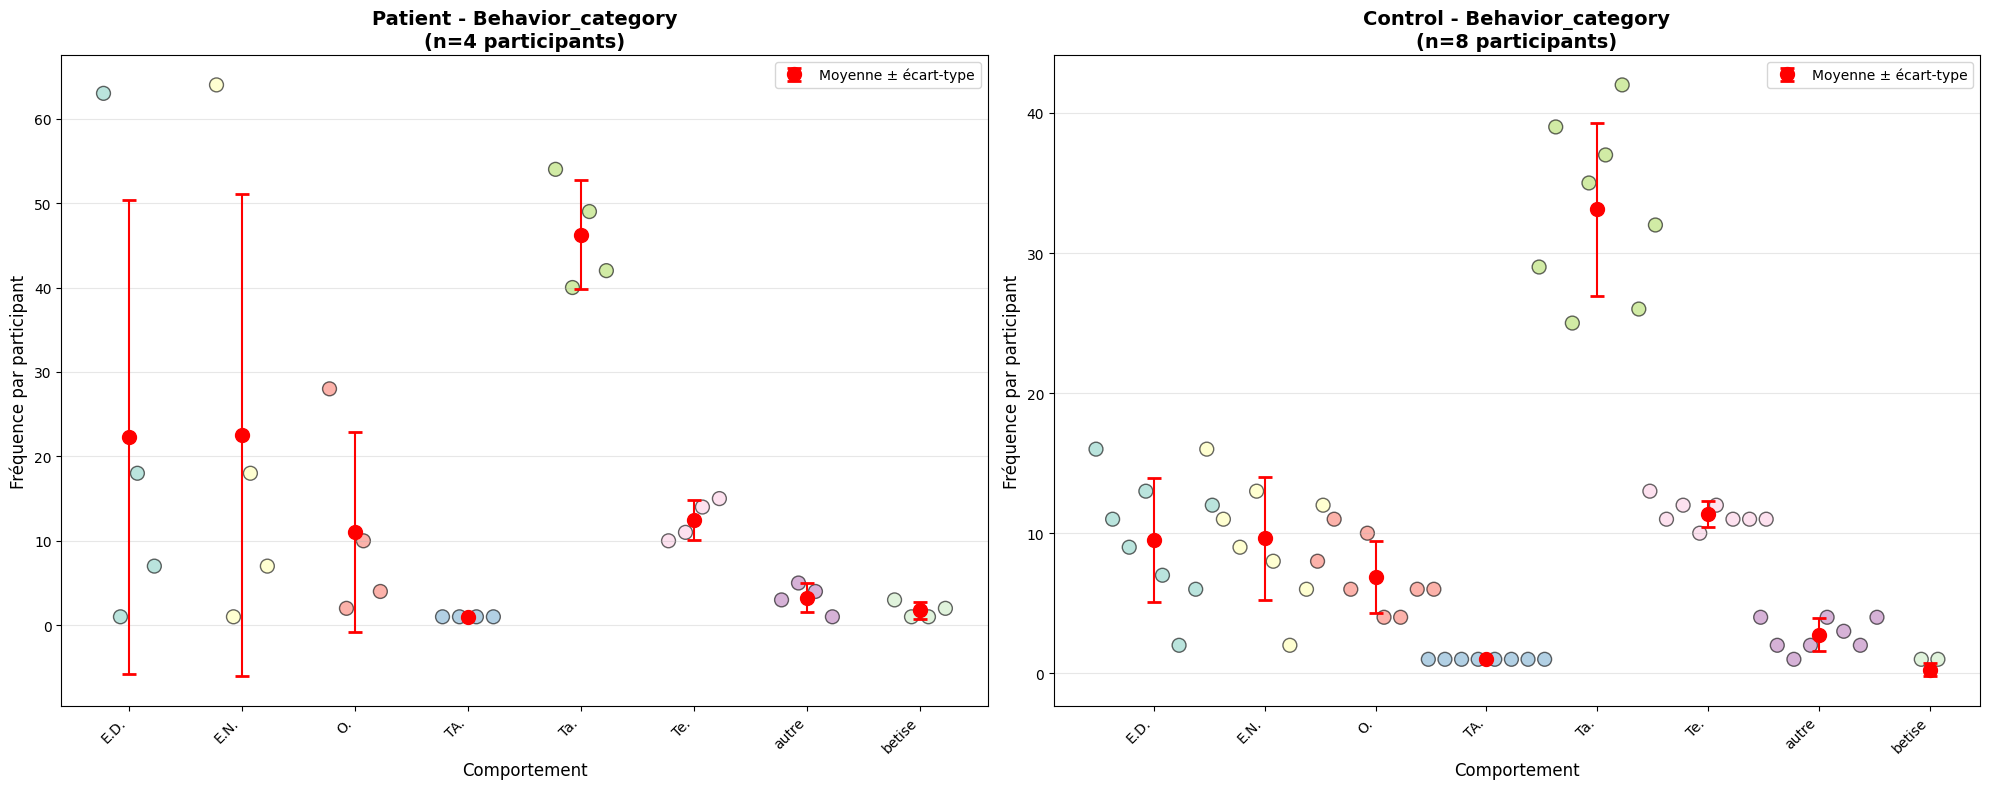

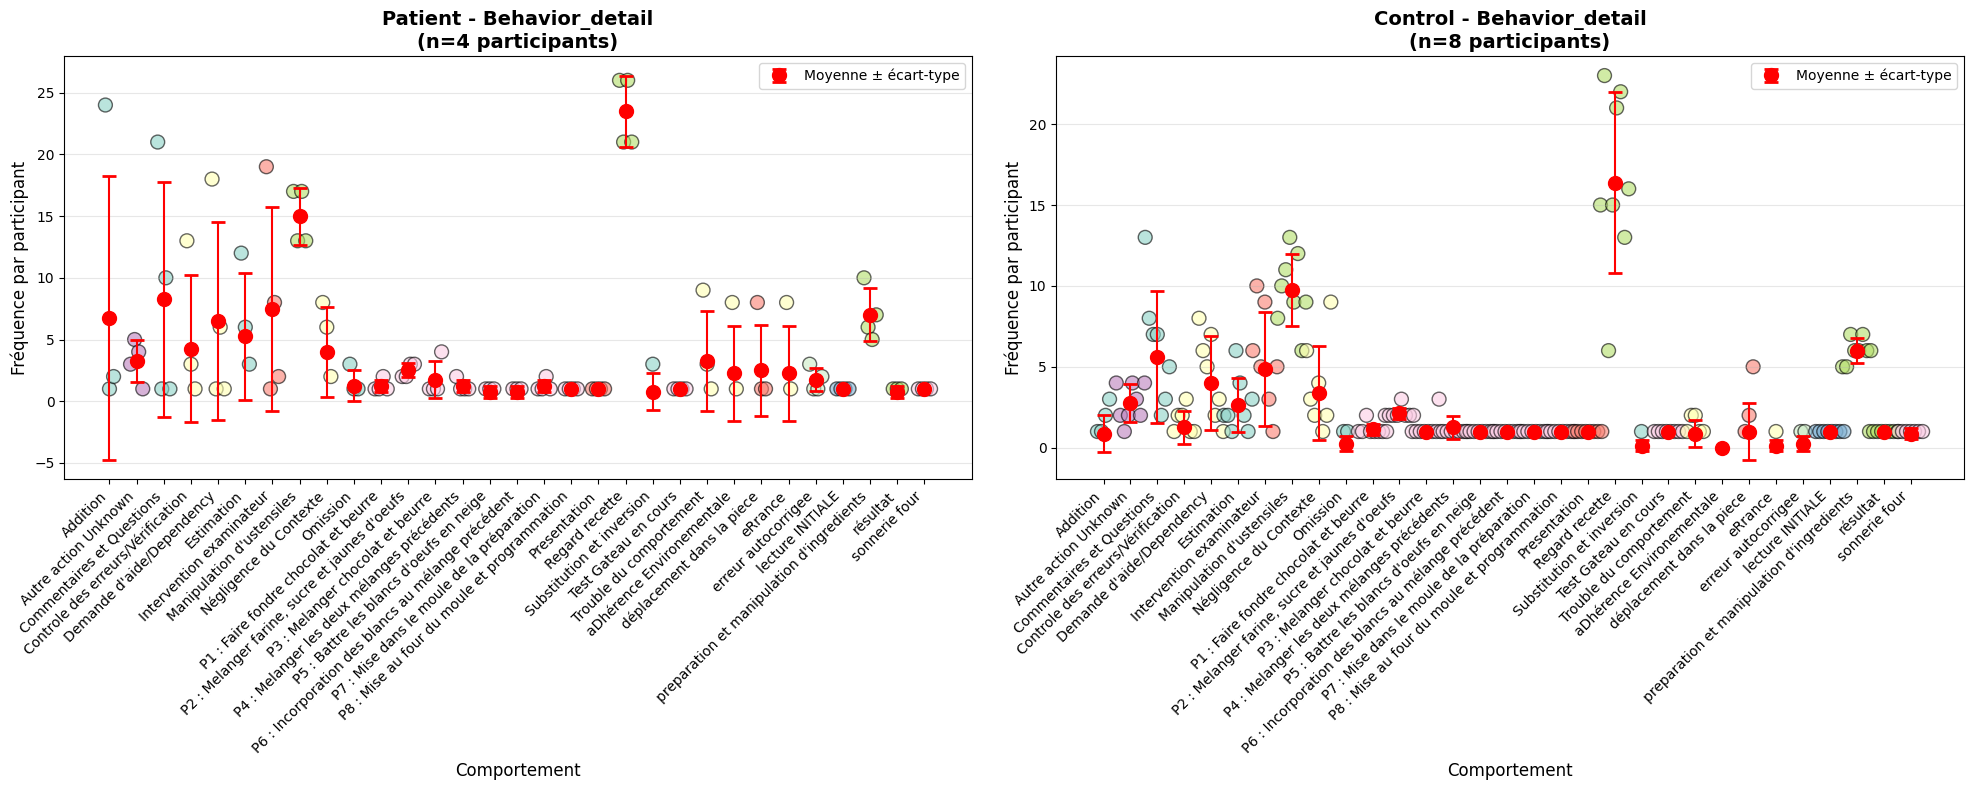

In [10]:
# Visualiser les valeurs individuelles pour Behavior_category
plot_individual_values_by_category(
    list_boris_agregated_patient,
    list_boris_agregated_control,
    'Behavior_category',
    'Behavior_category',
    category_color_map=category_color_map
)

# Visualiser les valeurs individuelles pour Behavior_detail
plot_individual_values_by_category(
    list_boris_agregated_patient,
    list_boris_agregated_control,
    'Behavior_detail',
    'Behavior_detail',
    category_color_map=category_color_map,
    detail_to_category_map=all_detail_to_cat
)

In [11]:
def plot_temporal_evolution_step(list_boris_agregated_patient, 
                                 list_boris_agregated_control,
                                 behavior_value, 
                                 column_name='Behavior_category',
                                 normalize_time=True):
    """Visualise l'évolution cumulative d'un comportement au cours de la session (courbe en escalier).
    
    Args:
        list_boris_agregated_patient: Liste de DataFrames pour Patient
        list_boris_agregated_control: Liste de DataFrames pour Control
        behavior_value: Valeur à suivre (ex: "O.", "Te.", etc.)
        column_name: 'Behavior_category' ou 'Behavior_detail'
        normalize_time: Si True, normalise en % (0-100%). Si False, utilise le temps réel en secondes (toutes commencent à 0)
    """
    def compute_cumulative_events(df, behavior_value, column_name, normalize_time):
        """Calcule la courbe cumulative d'événements pour un DataFrame."""
        # Vérifier que les colonnes nécessaires existent
        if column_name not in df.columns:
            print(f"Attention: colonne '{column_name}' non trouvée dans le DataFrame")
            return None
        
        if "Start (s)" not in df.columns:
            print("Attention: colonne 'Start (s)' non trouvée dans le DataFrame")
            return None
        
        # Filtrer les événements du comportement choisi
        filtered_df = df[df[column_name] == behavior_value].copy()
        
        if len(filtered_df) == 0:
            return None
        
        # Trier par temps de début
        filtered_df = filtered_df.sort_values("Start (s)")
        
        # Calculer la durée totale de la session (utiliser TOUT le DataFrame, pas seulement les événements filtrés)
        min_start = df["Start (s)"].min()
        
        # Déterminer le max_stop
        if "Stop (s)" in df.columns:
            max_stop = df["Stop (s)"].max()
        elif "Duration (s)" in df.columns:
            max_stop = (df["Start (s)"] + df["Duration (s)"]).max()
        else:
            # Si pas de Stop ni Duration, utiliser le dernier Start
            max_stop = df["Start (s)"].max()
        
        total_duration = max_stop - min_start
        
        if total_duration <= 0:
            return None
        
        # Créer les points pour la courbe en escalier
        # Au début : 0 événement
        time_points = [min_start]
        cumulative_counts = [0]
        
        # Pour chaque événement, ajouter deux points : avant (+0) et après (+1)
        for _, row in filtered_df.iterrows():
            event_time = row["Start (s)"]
            # Point juste avant l'événement (même valeur cumulative)
            time_points.append(event_time)
            cumulative_counts.append(cumulative_counts[-1])
            # Point juste après l'événement (+1)
            time_points.append(event_time)
            cumulative_counts.append(cumulative_counts[-1] + 1)
        
        # Point final (même valeur cumulative)
        time_points.append(max_stop)
        cumulative_counts.append(cumulative_counts[-1])
        
        # Normaliser ou non le temps
        if normalize_time:
            # Normaliser le temps en pourcentage (0-100%)
            time_normalized = [(t - min_start) / total_duration * 100 for t in time_points]
            return {
                'time': time_normalized,
                'cumulative_counts': cumulative_counts,
                'total_duration': total_duration,
                'min_start': min_start,
                'time_label': 'Temps (% de la session)'
            }
        else:
            # Temps réel en secondes, toutes commencent à 0
            time_real = [t - min_start for t in time_points]
            return {
                'time': time_real,
                'cumulative_counts': cumulative_counts,
                'total_duration': total_duration,
                'min_start': min_start,
                'time_label': 'Temps (secondes)'
            }
    
    # Calculer pour tous les patients
    patient_results = []
    for participant_idx, df in enumerate(list_boris_agregated_patient):
        result = compute_cumulative_events(df, behavior_value, column_name, normalize_time)
        if result:
            result['participant_id'] = f"Patient_{participant_idx+1}"
            patient_results.append(result)
    
    control_results = []
    for participant_idx, df in enumerate(list_boris_agregated_control):
        result = compute_cumulative_events(df, behavior_value, column_name, normalize_time)
        if result:
            result['participant_id'] = f"Control_{participant_idx+1}"
            control_results.append(result)
    
    if not patient_results and not control_results:
        print(f"Aucune donnée trouvée pour '{behavior_value}' dans la colonne '{column_name}'")
        return
    
    # Créer le graphique
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Tracer chaque patient du groupe Patient (courbe en escalier)
    for result in patient_results:
        ax.step(result['time'], result['cumulative_counts'], 
               where='post', color='red', alpha=0.5, linewidth=1.5, 
               label='Patient' if result == patient_results[0] else '')
    
    # Tracer chaque contrôle du groupe Control (courbe en escalier)
    for result in control_results:
        ax.step(result['time'], result['cumulative_counts'], 
               where='post', color='blue', alpha=0.5, linewidth=1.5, 
               label='Control' if result == control_results[0] else '')
    
    # Calculer et tracer les moyennes par groupe
    time_label = patient_results[0]['time_label'] if patient_results else (control_results[0]['time_label'] if control_results else 'Temps')
    
    if patient_results:
        # Trouver la durée maximale pour créer la grille temporelle
        if normalize_time:
            max_time = 100
            time_grid = np.linspace(0, 100, 1000)
        else:
            max_time = max(r['total_duration'] for r in patient_results)
            time_grid = np.linspace(0, max_time, 1000)
        
        all_patient_curves = []
        
        for result in patient_results:
            # Interpoler la courbe sur la grille temporelle
            interpolated = np.interp(time_grid, result['time'], result['cumulative_counts'])
            all_patient_curves.append(interpolated)
        
        if all_patient_curves:
            patient_mean = np.mean(all_patient_curves, axis=0)
            patient_std = np.std(all_patient_curves, axis=0, ddof=1) if len(all_patient_curves) > 1 else np.zeros(len(patient_mean))
            
            ax.plot(time_grid, patient_mean, color='darkred', linewidth=3, 
                   label='Moyenne Patient', linestyle='--')
            ax.fill_between(time_grid, 
                           patient_mean - patient_std,
                           patient_mean + patient_std,
                           color='red', alpha=0.2)
    
    if control_results:
        # Trouver la durée maximale pour créer la grille temporelle
        if normalize_time:
            max_time = 100
            time_grid = np.linspace(0, 100, 1000)
        else:
            max_time = max(r['total_duration'] for r in control_results)
            time_grid = np.linspace(0, max_time, 1000)
        
        all_control_curves = []
        
        for result in control_results:
            interpolated = np.interp(time_grid, result['time'], result['cumulative_counts'])
            all_control_curves.append(interpolated)
        
        if all_control_curves:
            control_mean = np.mean(all_control_curves, axis=0)
            control_std = np.std(all_control_curves, axis=0, ddof=1) if len(all_control_curves) > 1 else np.zeros(len(control_mean))
            
            ax.plot(time_grid, control_mean, color='darkblue', linewidth=3, 
                   label='Moyenne Control', linestyle='--')
            ax.fill_between(time_grid,
                           control_mean - control_std,
                           control_mean + control_std,
                           color='blue', alpha=0.2)
    
    ax.set_xlabel(time_label, fontsize=12)
    ax.set_ylabel(f'Nombre cumulatif d\'occurrences de "{behavior_value}"', fontsize=12)
    title_suffix = "normalisé" if normalize_time else "réel"
    ax.set_title(f'Évolution cumulative de "{behavior_value}" ({column_name})\nau cours de la session (temps {title_suffix})', 
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

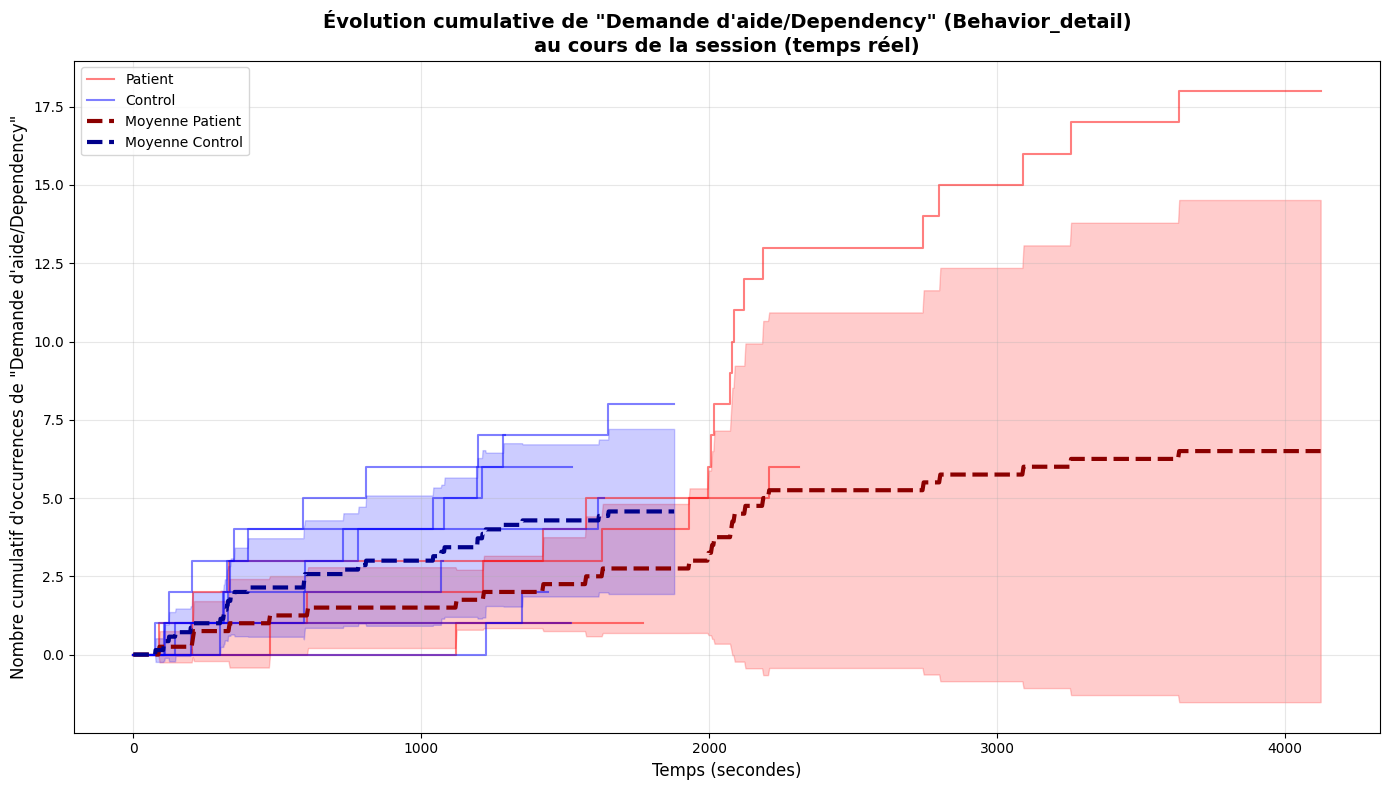

In [12]:
# Exemple avec Behavior_detail et temps normalisé (0-100%)
plot_temporal_evolution_step(
    list_boris_agregated_patient,
    list_boris_agregated_control,
    behavior_value="Demande d'aide/Dependency",  # Remplacez par la valeur qui vous intéresse
    column_name='Behavior_detail',
    normalize_time=False  
)




In [13]:
def plot_ethogram(df, patient_id=None, behavior_col='Behavior_category', 
                  start_col='Start (s)', duration_col='Duration (s)', 
                  stop_col='Stop (s)', figsize=(16, 8), sync=False):
    """Crée un éthogramme pour visualiser la séquence temporelle des comportements.
    
    Si behavior_col='Behavior_detail' et sync=True :
        - Les couleurs sont définies par 'Behavior_category' (une couleur par catégorie)
        - Les lignes (y) restent les valeurs de 'Behavior_detail', mais regroupées par catégorie
        - La légende montre les catégories, pas chaque détail.
    Sinon :
        - Une couleur par valeur de behavior_col (comportement ou détail).
    """
    # Vérifier les colonnes nécessaires
    if behavior_col not in df.columns:
        print(f"Erreur: colonne '{behavior_col}' non trouvée")
        return
    
    if start_col not in df.columns:
        print(f"Erreur: colonne '{start_col}' non trouvée")
        return
    
    # Si sync=True avec behavior_detail, vérifier la colonne Behavior_category
    if behavior_col == 'Behavior_detail' and sync:
        if 'Behavior_category' not in df.columns:
            print("Erreur: 'Behavior_category' est requis quand sync=True et behavior_col='Behavior_detail'")
            return
    
    # Calculer le temps de fin si nécessaire
    if stop_col in df.columns:
        df_plot = df.copy()
        df_plot['end_time'] = df_plot[stop_col]
    elif duration_col in df.columns:
        df_plot = df.copy()
        df_plot['end_time'] = df_plot[start_col] + df_plot[duration_col]
    else:
        print(f"Erreur: besoin de '{stop_col}' ou '{duration_col}'")
        return
    
    # Trier par temps de début
    df_plot = df_plot.sort_values(start_col)
    
    # Définir les comportements (lignes de l'éthogramme)
    if behavior_col == 'Behavior_detail' and sync:
        # On veut que les détails d'une même catégorie soient proches :
        # tri par (Behavior_category, Behavior_detail)
        df_plot = df_plot.sort_values(['Behavior_category', behavior_col, start_col])
        all_behaviors = df_plot[behavior_col].drop_duplicates().tolist()
    else:
        all_behaviors = sorted(df_plot[behavior_col].unique())
    
    n_behaviors = len(all_behaviors)
    
    # Création des couleurs
    if behavior_col == 'Behavior_detail' and sync:
        # Une couleur par Behavior_category
        categories = df_plot['Behavior_category'].drop_duplicates().tolist()
        n_cat = len(categories)
        cat_colors = plt.cm.Set3(np.linspace(0, 1, n_cat))
        category_color_map = {cat: cat_colors[i] for i, cat in enumerate(categories)}
        
        # Mapping détail -> couleur de la catégorie correspondante
        behavior_color_map = {}
        for _, row in df_plot[['Behavior_detail', 'Behavior_category']].drop_duplicates().iterrows():
            detail = row['Behavior_detail']
            cat = row['Behavior_category']
            behavior_color_map[detail] = category_color_map[cat]
    else:
        # Une couleur par valeur de behavior_col
        colors = plt.cm.Set3(np.linspace(0, 1, n_behaviors))
        behavior_color_map = {behavior: colors[i] for i, behavior in enumerate(all_behaviors)}
    
    # Créer la figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Position Y pour chaque comportement (ligne)
    y_positions = {}
    y_pos = 0
    for behavior in all_behaviors:
        y_positions[behavior] = y_pos
        y_pos += 1
    
    # Tracer chaque événement
    for idx, row in df_plot.iterrows():
        behavior = row[behavior_col]
        start = row[start_col]
        end = row['end_time']
        duration = end - start
        
        y_pos = y_positions[behavior]
        color = behavior_color_map.get(behavior, 'grey')
        
        ax.barh(y_pos, duration, left=start, height=0.8, 
                color=color, edgecolor='black', linewidth=0.5, alpha=0.8)
    
    # Configuration de l'axe Y
    ax.set_yticks(list(y_positions.values()))
    ax.set_yticklabels(list(y_positions.keys()))
    ax.set_ylabel('Comportement', fontsize=12)
    ax.set_xlabel('Temps (secondes)', fontsize=12)
    
    # Titre
    title = f'Éthogramme'
    if patient_id:
        title += f' - {patient_id}'
    title += f' ({behavior_col})'
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Grille
    ax.grid(True, alpha=0.3, axis='x')
    
    # Légende
    if behavior_col == 'Behavior_detail' and sync:
        # Légende par catégorie
        legend_elements = [
            plt.Rectangle((0, 0), 1, 1, facecolor=category_color_map[cat],
                          edgecolor='black', label=cat)
            for cat in categories
        ]
    else:
        # Légende par comportement (comme avant)
        legend_elements = [
            plt.Rectangle((0, 0), 1, 1, facecolor=behavior_color_map[beh],
                          edgecolor='black', label=beh)
            for beh in all_behaviors
        ]
    
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    
    plt.tight_layout()
    plt.show()


    

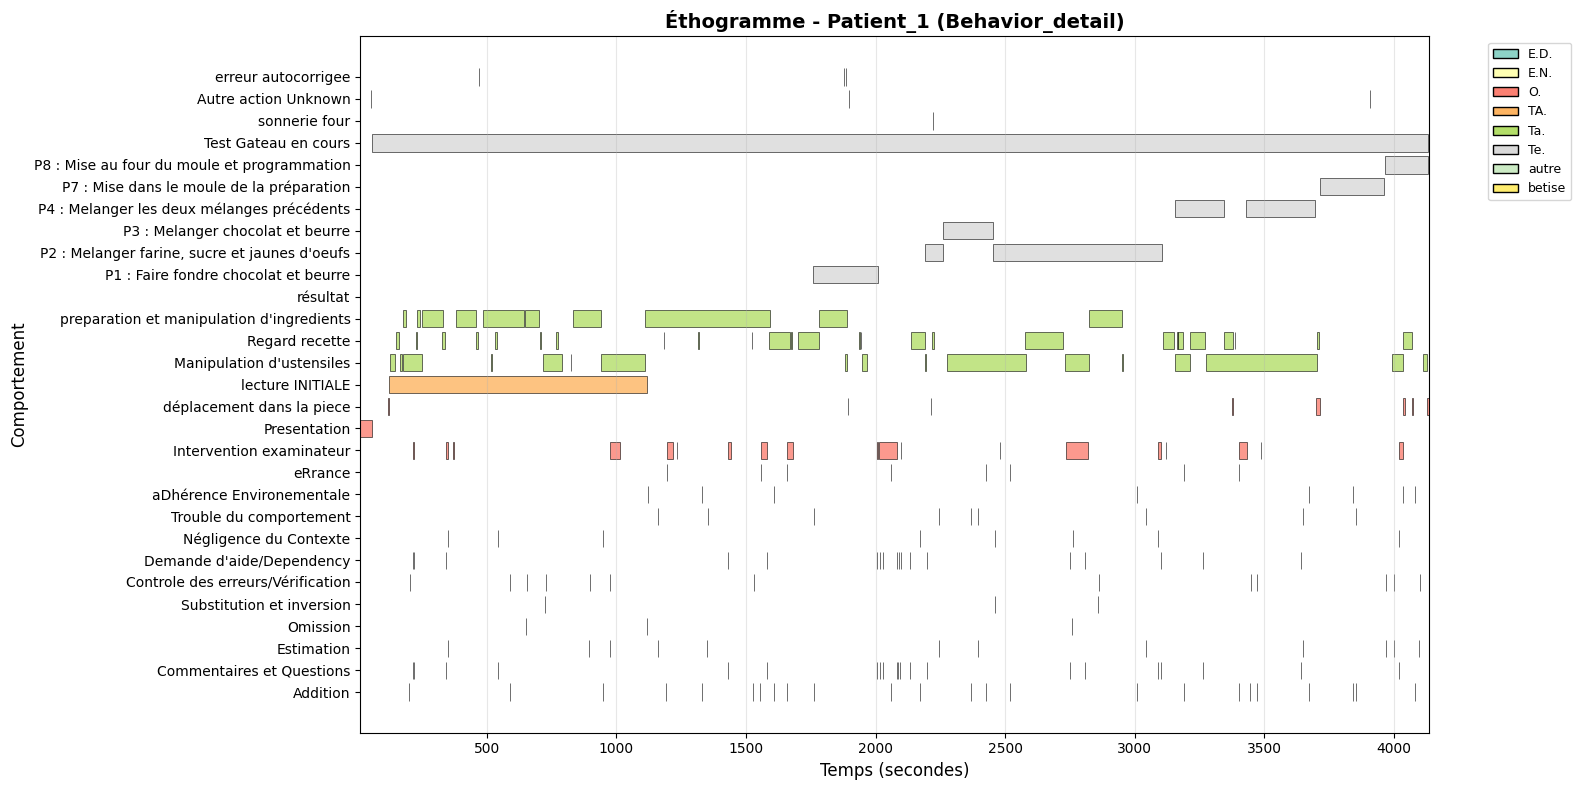

In [64]:
# Exemple d'utilisation pour un patient spécifique
# Utiliser un DataFrame d'un patient de votre liste

# Pour le premier patient
patient_df = list_boris_agregated_patient[0]
control_df = list_boris_agregated_control[5]
plot_ethogram(
    patient_df,
    patient_id="Patient_1",
    behavior_col='Behavior_detail',
    sync=True
)

# Pour un autre patient avec Behavior_detail
# plot_ethogram(
#     list_boris_agregated_patient[1],
#     patient_id="Patient_2",
#     behavior_col='Behavior_detail'
# )

In [15]:
patient_df["Behavior_detail"].unique()

array(['Presentation', 'Autre action Unknown', 'Test Gateau en cours',
       'déplacement dans la piece', 'lecture INITIALE',
       "Manipulation d'ustensiles", 'Regard recette',
       "preparation et manipulation d'ingredients", 'Addition',
       'Controle des erreurs/Vérification', 'Commentaires et Questions',
       "Demande d'aide/Dependency", 'Intervention examinateur',
       'Estimation', 'Négligence du Contexte', 'erreur autocorrigee',
       'Omission', 'Substitution et inversion',
       'aDhérence Environementale', 'Trouble du comportement', 'eRrance',
       'P1 : Faire fondre chocolat et beurre',
       "P2 : Melanger farine, sucre et jaunes d'oeufs", 'sonnerie four',
       'P3 : Melanger chocolat et beurre',
       'P4 : Melanger les deux mélanges précédents',
       'P7 : Mise dans le moule de la préparation',
       'P8 : Mise au four du moule et programmation', 'résultat'],
      dtype=object)

In [16]:
# Correction : filtrer les lignes où Behavior_detail == "eRrance" |

# patient_df = list_boris_agregated_patient[0]
# control_df = list_boris_agregated_control[2]
df = list_boris_agregated_control[2]
display(df.head())
df[(df["Behavior_category"] == "TA.") | (df["Behavior_detail"] == "Test Gateau en cours") | (df["Behavior_detail"] == "Presentation")]

,Behavioral category,Behavior type,Start (s),Stop (s),Duration (s),Behavior_category,Behavior_detail
0,operateur,STATE,77.494,92.801,15.307,O.,Presentation
1,test,STATE,136.053,396.897,260.844,Te.,P1 : Faire fondre chocolat et beurre
2,tache,STATE,93.343,1709.207,1615.864,Te.,Test Gateau en cours
3,tache,STATE,138.472,254.838,116.366,Ta.,preparation et manipulation d'ingredients
4,Descriptive,POINT,196.571,196.571,0.000,E.D.,Commentaires et Questions


,Behavioral category,Behavior type,Start (s),Stop (s),Duration (s),Behavior_category,Behavior_detail
0,operateur,STATE,77.494,92.801,15.307,O.,Presentation
2,tache,STATE,93.343,1709.207,1615.864,Te.,Test Gateau en cours
62,test,POINT,93.343,135.218,41.875,TA.,lecture INITIALE


# 1 - construction de variables temporelles

## 1.1 extraction des durées d'intéret

In [17]:
# Les pauses au cours du test 
def duree_pause(df_boris_aggregated,  exclude_lecture_initiale=True):
    """Identifie les pauses dans un enregistrement BORIS.
    
    La durée du test commence à la fin de la lecture initiale (TA.)(si exclude_lecture_initiale = True) et se termine à la fin de "Test Gateau en cours".
    Les pauses sont les moments où il n'y a pas d'activité "Ta."
    Seules les pauses de plus d'une seconde sont conservées.
    
    Args:
        df_boris_aggregated: DataFrame avec les colonnes Behavior_category, Behavior_detail, Start (s), Duration (s)
        include_manipulation_ustensiles: Si True, inclut "Manipulation d'ustensiles" dans l'union des tâches Te.
        
    Returns:
        DataFrame avec colonnes 'start' et 'stop' pour chaque pause (durée > 1 seconde)
    """
    # Vérifier les colonnes nécessaires
    required_cols = ['Behavior_category', 'Behavior_detail', 'Start (s)', 'Duration (s)']
    if not all(col in df_boris_aggregated.columns for col in required_cols):
        raise ValueError(f"DataFrame doit contenir les colonnes: {required_cols}")
    
    df = df_boris_aggregated.copy()
    
    # 1. Trouver la ligne unique où behavior_detail = "Test Gateau en cours"
    test_gateau_row = df[df['Behavior_detail'] == "Test Gateau en cours"]
    
    if len(test_gateau_row) == 0:
        raise ValueError("Aucune ligne avec behavior_detail = 'Test Gateau en cours' trouvée")
    
    if len(test_gateau_row) > 1:
        print(f"Attention: {len(test_gateau_row)} lignes avec 'Test Gateau en cours' trouvées, utilisation de la première")
        test_gateau_row = test_gateau_row.iloc[[0]]
    
    # Récupérer la fin du test (fin de "Test Gateau en cours")
    test_end = test_gateau_row.iloc[0]['Stop (s)']
    test_start = test_gateau_row.iloc[0]['Start (s)']

    if exclude_lecture_initiale:
    # 2. Trouver le temps de lecture initiale (TA.) - la fin de cette lecture sera le début du test
        ta_row = df[df['Behavior_category'] == 'TA.']
    
        if len(ta_row) == 0:
            raise ValueError("Aucune ligne avec Behavior_category = 'TA.' trouvée")
        
        if len(ta_row) > 1:
            print(f"Attention: {len(ta_row)} lignes avec 'TA.' trouvées, utilisation de la première")
            ta_row = ta_row.iloc[[0]]
        
        # Le début du test est la fin de la lecture initiale
        test_start = ta_row.iloc[0]['Stop (s)']
    
    if test_start >= test_end:
        raise ValueError("La fin de la lecture initiale (TA.) est après ou égale à la fin du test")
    
    # 3. Sélectionner les durées correspondant à "Ta." 
    ta_rows = df[
    (
        ((df["Behavior_category"] == "Ta.") & (df["Behavior_detail"] != "resultat"))
        | (df["Behavior_category"] == "TA.")
    )
    ].copy()
    
    
    
    # Filtrer pour ne garder que les activités dans la durée du test
    ta_rows = ta_rows[
        (ta_rows['Start (s)'] < test_end) & 
        (ta_rows['Stop (s)'] > test_start)
    ]
    
    if len(ta_rows) == 0:
        # Pas d'activité Te. dans la durée du test, donc toute la durée du test est une pause
        pauses = [{'start': test_start, 'stop': test_end}]
        
        # Filtrer les pauses de plus d'une seconde
        pauses_filtered = [p for p in pauses if (p['stop'] - p['start']) > 1.0]
        
        if pauses_filtered:
            return pd.DataFrame(pauses_filtered)
        else:
            return pd.DataFrame(columns=['start', 'stop'])
    
    # 4. Prendre l'union des durées (intervalles [start, end])
    # Trier par temps de début
    ta_rows = ta_rows.sort_values('Start (s)')
    
    # Fusionner les intervalles qui se chevauchent ou se touchent
    intervals = []
    for _, row in ta_rows.iterrows():
        start = row['Start (s)']
        end = row['Stop (s)']
        
        # S'assurer que l'intervalle est dans la durée du test
        start = max(start, test_start)
        end = min(end, test_end)
        
        if not intervals:
            intervals.append([start, end])
        else:
            # Vérifier si l'intervalle se chevauche ou touche le dernier
            last_start, last_end = intervals[-1]
            if start <= last_end:  # Chevauchement ou continuité
                intervals[-1][1] = max(last_end, end)  # Étendre l'intervalle
            else:
                intervals.append([start, end])
    
    # 5. Identifier les pauses = trous dans l'union sur la durée du test
    pauses = []
    
    # Pause avant la première activité (si elle commence après le début du test)
    if intervals and intervals[0][0] > test_start:
        pauses.append({
            'start': test_start,
            'stop': intervals[0][0]
        })
    
    # Pauses entre les intervalles
    for i in range(len(intervals) - 1):
        pause_start = intervals[i][1]
        pause_end = intervals[i+1][0]
        if pause_start < pause_end:  # Vérifier qu'il y a bien un trou
            pauses.append({
                'start': pause_start,
                'stop': pause_end
            })
    
    # Pause après la dernière activité (si elle finit avant la fin du test)
    if intervals and intervals[-1][1] < test_end:
        pauses.append({
            'start': intervals[-1][1],
            'stop': test_end
        })
    
    # Si aucune activité Te. dans la durée du test, toute la durée est une pause
    if not intervals:
        pauses = [{
            'start': test_start,
            'stop': test_end
        }]
    
    # 6. Filtrer les pauses pour ne garder que celles de plus d'une seconde
    pauses_filtered = []
    for pause in pauses:
        duration = pause['stop'] - pause['start']
        if duration > 1.0:  # Plus d'une seconde
            pauses_filtered.append(pause)
    
    # Créer le DataFrame de sortie
    if pauses_filtered:
        return pd.DataFrame(pauses_filtered)
    else:
        return pd.DataFrame(columns=['start', 'stop'])

pause = duree_pause(patient_df, exclude_lecture_initiale=True)

display(pause)

,start,stop
0,1669.668,1674.131
1,1676.008,1701.199
2,1891.556,1937.144
3,1939.104,1942.649
4,1945.735,1948.488
5,1965.338,2137.427
6,2189.688,2191.606
7,2195.151,2215.922
8,2224.889,2274.314
9,2724.931,2730.436


In [18]:
def  duree_regard_recette(df_boris_aggregated, exclude_lecture_initiale=False):
    """Identifie les moments de regard de la recette dans un enregistrement BORIS.
    
    La durée du test commence à la fin de la lecture initiale (TA.) et se termine à la fin de "Test Gateau en cours".
    Les moments de regard de la recette sont les durées où behavior_detail = "regard recette".
    
    Args:
        df_boris_aggregated: DataFrame avec les colonnes Behavior_category, Behavior_detail, Start (s), Duration (s)
        exclude_lecture_initiale: Si True, exclut les moments de regard pendant la lecture initiale (TA.)
        
    Returns:
        DataFrame avec colonnes 'start' et 'stop' pour chaque moment de regard de la recette
    """
    # Vérifier les colonnes nécessaires
    required_cols = ['Behavior_category', 'Behavior_detail', 'Start (s)', 'Duration (s)']
    if not all(col in df_boris_aggregated.columns for col in required_cols):
        raise ValueError(f"DataFrame doit contenir les colonnes: {required_cols}")
    
    df = df_boris_aggregated.copy()
    
    # 1. Trouver la ligne unique où behavior_detail = "Test Gateau en cours"
    test_gateau_row = df[df['Behavior_detail'] == "Test Gateau en cours"]
    
    if len(test_gateau_row) == 0:
        raise ValueError("Aucune ligne avec behavior_detail = 'Test Gateau en cours' trouvée")
    
    if len(test_gateau_row) > 1:
        print(f"Attention: {len(test_gateau_row)} lignes avec 'Test Gateau en cours' trouvées, utilisation de la première")
        test_gateau_row = test_gateau_row.iloc[[0]]
    
    # Récupérer la fin du test (fin de "Test Gateau en cours")
    test_end = test_gateau_row.iloc[0]['Stop (s)']
    
    # 2. Trouver le temps de lecture initiale (TA.)
    ta_row = df[df['Behavior_category'] == 'TA.']
    
    if len(ta_row) == 0:
        raise ValueError("Aucune ligne avec Behavior_category = 'TA.' trouvée")
    
    if len(ta_row) > 1:
        print(f"Attention: {len(ta_row)} lignes avec 'TA.' trouvées, utilisation de la première")
        ta_row = ta_row.iloc[[0]]
    
    lecture_start = ta_row.iloc[0]['Start (s)']
    lecture_end = ta_row.iloc[0]['Stop (s)']
    
    # Définir le début du test selon l'option
    if exclude_lecture_initiale:
        test_start = lecture_end
    else:
        test_start = test_gateau_row.iloc[0]['Start (s)']
    
    if test_start >= test_end:
        raise ValueError("Le début du test est après ou égal à la fin du test")
    
    # 3. Sélectionner les lignes où behavior_detail = "regard recette"
    regard_recette_rows = df[df['Behavior_detail'] == "Regard recette"].copy()
    
    if len(regard_recette_rows) == 0:
        return pd.DataFrame(columns=['start', 'stop'])
    
    # Filtrer pour ne garder que les moments dans la durée du test
    regard_recette_rows = regard_recette_rows[
        (regard_recette_rows['Start (s)'] < test_end) & 
        (regard_recette_rows['Stop (s)'] > test_start)
    ]
    
    if len(regard_recette_rows) == 0:
        return pd.DataFrame(columns=['start', 'stop'])
    
    # 4. Extraire les intervalles [start, stop] et s'assurer qu'ils sont dans la durée du test
    result_list = []
    for _, row in regard_recette_rows.iterrows():
        start = max(row['Start (s)'], test_start)
        stop = min(row['Stop (s)'], test_end)
        
        if start < stop:
            result_list.append({
                'start': start,
                'stop': stop
            })
    
    if result_list:
        result_df = pd.DataFrame(result_list)
        # Trier par temps de début
        result_df = result_df.sort_values('start').reset_index(drop=True)
        return result_df
    else:
        return pd.DataFrame(columns=['start', 'stop'])


# Regard recette sans exclure la lecture initiale
regard_recette = duree_regard_recette(patient_df, exclude_lecture_initiale=True)

display(regard_recette)



,start,stop
0,1183.140,1184.725
1,1313.812,1318.025
2,1521.645,1522.062
3,1590.089,1669.668
4,1674.131,1676.008
5,1701.199,1781.989
6,1937.144,1939.104
7,1942.649,1945.735
8,2137.427,2189.688
9,2215.922,2224.889


In [19]:

def duree_intervention_examinateur(df_boris_aggregated):
    """Identifie les interventions de l'examinateur dans un enregistrement BORIS.
    
    La durée du test correspond à celle de "Test Gateau en cours".
    Les interventions sont séparées en deux groupes :
    - Interventions avec demande d'aide précédente (initiées par le patient) : la ligne juste avant est une demande d'aide
    - Interventions sans demande d'aide précédente (non initiées par le patient)
    
    Args:
        df_boris_aggregated: DataFrame avec les colonnes Behavior_category, Behavior_detail, Start (s), Duration (s)
        
    Returns:
        tuple: (DataFrame avec interventions avec demande d'aide, DataFrame avec interventions sans demande d'aide)
               Chaque DataFrame a les colonnes 'start' et 'stop'
    """
    # Vérifier les colonnes nécessaires
    required_cols = ['Behavior_category', 'Behavior_detail', 'Start (s)', 'Duration (s)']
    if not all(col in df_boris_aggregated.columns for col in required_cols):
        raise ValueError(f"DataFrame doit contenir les colonnes: {required_cols}")
    
    df = df_boris_aggregated.copy()
    
    # 1. Trouver la ligne unique où behavior_detail = "Test Gateau en cours"
    test_gateau_row = df[df['Behavior_detail'] == "Test Gateau en cours"]
    
    if len(test_gateau_row) == 0:
        raise ValueError("Aucune ligne avec behavior_detail = 'Test Gateau en cours' trouvée")
    
    if len(test_gateau_row) > 1:
        print(f"Attention: {len(test_gateau_row)} lignes avec 'Test Gateau en cours' trouvées, utilisation de la première")
        test_gateau_row = test_gateau_row.iloc[[0]]
    
    # Récupérer la durée du test
    test_start = test_gateau_row.iloc[0]['Start (s)']
    test_end = test_gateau_row.iloc[0]['Stop (s)']
    
    if test_start >= test_end:
        raise ValueError("Le début du test est après ou égal à la fin du test")
    
    # 2. Filtrer le DataFrame pour ne garder que les lignes dans la durée du test
    df_filtered = df[
        (df['Start (s)'] >= test_start) & 
        (df['Start (s)'] <= test_end)
    ].copy()
    
    # Trier par temps de début pour avoir l'ordre chronologique
    df_filtered = df_filtered.sort_values('Start (s)').reset_index(drop=True)
    
    # 3. Sélectionner les lignes où behavior_detail = "Intervention examinateur"
    intervention_indices = df_filtered[df_filtered['Behavior_detail'] == "Intervention examinateur"].index.tolist()
    
    if len(intervention_indices) == 0:
        return (pd.DataFrame(columns=['start', 'stop']), pd.DataFrame(columns=['start', 'stop']))
    
    # 4. Pour chaque intervention, vérifier si la ligne précédente est une demande d'aide
    interventions_avec_demande = []
    interventions_sans_demande = []
    
    for inter_idx in intervention_indices:
        inter_row = df_filtered.iloc[inter_idx]
        inter_start = inter_row['Start (s)']
        inter_stop = inter_row['Stop (s)']
        
        # Vérifier si la ligne précédente existe et est une demande d'aide
        if inter_idx > 0:
            ligne_precedente = df_filtered.iloc[inter_idx - 1]
            if ligne_precedente['Behavior_detail'] == "Demande d'aide/Dependency":
                # Intervention avec demande d'aide précédente
                interventions_avec_demande.append({
                    'start': inter_start,
                    'stop': inter_stop
                })
            else:
                # Intervention sans demande d'aide précédente
                interventions_sans_demande.append({
                    'start': inter_start,
                    'stop': inter_stop
                })
        else:
            # Première ligne du DataFrame filtré, donc pas de ligne précédente = sans demande d'aide
            interventions_sans_demande.append({
                'start': inter_start,
                'stop': inter_stop
            })
    
    # 5. Créer les DataFrames de sortie
    if interventions_avec_demande:
        df_avec_demande = pd.DataFrame(interventions_avec_demande)
        df_avec_demande = df_avec_demande.sort_values('start').reset_index(drop=True)
    else:
        df_avec_demande = pd.DataFrame(columns=['start', 'stop'])
    
    if interventions_sans_demande:
        df_sans_demande = pd.DataFrame(interventions_sans_demande)
        df_sans_demande = df_sans_demande.sort_values('start').reset_index(drop=True)
    else:
        df_sans_demande = pd.DataFrame(columns=['start', 'stop'])
    
    return df_avec_demande, df_sans_demande

"modifier pour obtenir deux variables, si une est issue d'une demande ou pas en filtrant avec Demande d'aide/Dependency (si deux ligne se suivent)"
# Interventions de l'examinateur
interventions_avec_demande, interventions_sans_demande = duree_intervention_examinateur(patient_df)
print("interventions avec demande")
display(interventions_avec_demande)
print("interventions sans demande")
display(interventions_sans_demande)

interventions avec demande


,start,stop
0,216.425,216.800
1,343.093,348.181
2,2006.296,2008.465
3,2096.970,2097.679


interventions sans demande


,start,stop
0,369.536,372.455
1,975.641,1014.805
2,1194.360,1219.093
3,1233.691,1234.984
4,1430.179,1443.859
5,1556.638,1582.247
6,1659.116,1681.597
7,2012.260,2082.622
8,2479.060,2479.477
9,2736.567,2820.526


## 1.2 extraction de données ponctuels d'intérêt

In [20]:
# il y a une erreur EN pour une erreur ED donc on prend que EN:

def compte_erreur_EN(df_boris_aggregated):
    """Identifie toutes les erreurs E.N. dans un enregistrement BORIS.
    
    La durée du test correspond à celle de "Test Gateau en cours".
    Les erreurs sont les instants où behavior_detail correspond à une erreur E.N.
    
    Args:
        df_boris_aggregated: DataFrame avec les colonnes Behavior_category, Behavior_detail, Start (s), Duration (s)
        
    Returns:
        DataFrame avec une colonne par type d'erreur contenant les instants (NaN si pas d'erreur de ce type)
    """
    # Vérifier les colonnes nécessaires
    required_cols = ['Behavior_category', 'Behavior_detail', 'Start (s)', 'Duration (s)']
    if not all(col in df_boris_aggregated.columns for col in required_cols):
        raise ValueError(f"DataFrame doit contenir les colonnes: {required_cols}")
    
    df = df_boris_aggregated.copy()
    
    # 1. Trouver la ligne unique où behavior_detail = "Test Gateau en cours"
    test_gateau_row = df[df['Behavior_detail'] == "Test Gateau en cours"]
    
    if len(test_gateau_row) == 0:
        raise ValueError("Aucune ligne avec behavior_detail = 'Test Gateau en cours' trouvée")
    
    if len(test_gateau_row) > 1:
        print(f"Attention: {len(test_gateau_row)} lignes avec 'Test Gateau en cours' trouvées, utilisation de la première")
        test_gateau_row = test_gateau_row.iloc[[0]]
    
    # Récupérer la durée du test
    test_start = test_gateau_row.iloc[0]['Start (s)']
    test_end = test_gateau_row.iloc[0]['Stop (s)']
    
    if test_start >= test_end:
        raise ValueError("Le début du test est après ou égal à la fin du test")
    
    # 2. Trouver toutes les valeurs uniques de behavior_detail où behavior_category == "E.N."
    en_rows = df[df['Behavior_category'] == 'E.N.']
    
    # Récupérer toutes les valeurs uniques de behavior_detail pour E.N.
    erreur_types = sorted(en_rows['Behavior_detail'].unique().tolist())
    
    # Ajouter "Demande d'aide/Dependency" en première colonne et "betise" à la fin
    erreur_types = erreur_types + ["betise"]
    
    # 3. Créer un dictionnaire pour stocker les instants de chaque type d'erreur
    erreurs_dict = {}
    
    for erreur_type in erreur_types:
        
        if erreur_type == "betise":
            # Chercher "betise" dans behavior_detail
            erreur_rows = df[df['Behavior_category'] == "betise"]
        else:
            # Chercher les lignes avec behavior_category == "E.N." ET behavior_detail == erreur_type
            erreur_rows = df[
                (df['Behavior_category'] == 'E.N.') & 
                (df['Behavior_detail'] == erreur_type)
            ]
        
        # Filtrer pour ne garder que les erreurs dans la durée du test
        erreur_rows = erreur_rows[
            (erreur_rows['Start (s)'] >= test_start) & 
            (erreur_rows['Start (s)'] <= test_end)
        ]
        
        # Extraire les instants
        if len(erreur_rows) > 0:
            instants = erreur_rows['Start (s)'].values.tolist()
            erreurs_dict[erreur_type] = sorted(instants)
        else:
            erreurs_dict[erreur_type] = []
    
    # 4. Trouver la longueur maximale pour aligner toutes les colonnes
    max_length = max(len(instants) for instants in erreurs_dict.values())
    
    # 5. Créer le DataFrame avec toutes les colonnes, remplir avec NaN si nécessaire
    result_dict = {}
    for erreur_type in erreur_types:
        instants = erreurs_dict[erreur_type]
        # Étendre la liste avec NaN pour atteindre max_length
        instants_extended = instants + [np.nan] * (max_length - len(instants))
        result_dict[erreur_type] = instants_extended
    
    result_df = pd.DataFrame(result_dict)
    
    return result_df


# Trouver toutes les erreurs E.N.
erreurs = compte_erreur_EN(patient_df)
print(f"Nombre de colonnes d'erreurs: {len(erreurs.columns)}")
display(erreurs)


Nombre de colonnes d'erreurs: 7


,Controle des erreurs/Vérification,Demande d'aide/Dependency,Négligence du Contexte,Trouble du comportement,aDhérence Environementale,eRrance,betise
0,202.536,215.674,350.100,1161.327,1123.539,1193.693,469.594
1,591.049,217.551,541.583,1352.226,1330.579,1556.305,1877.084
2,654.779,342.467,948.990,1762.719,1609.858,1658.574,1885.258
3,727.143,1431.764,2171.169,2245.535,3008.839,2061.142,NaN
4,897.146,1581.371,2462.627,2370.034,3673.378,2425.006,NaN
5,974.515,2005.754,2761.258,2394.309,3843.757,2518.850,NaN
6,1530.654,2017.474,3090.087,3045.543,4036.950,3190.229,NaN
7,2860.441,2028.193,4021.768,3650.647,4083.204,3402.107,NaN
8,3447.235,2083.581,NaN,3854.309,NaN,NaN,NaN
9,3473.470,2088.628,NaN,NaN,NaN,NaN,NaN


In [21]:
def compte_fragmentation(df_boris_aggregated, include_controle_erreurs=False, include_Te = False):
    """Identifie les instants de transition (fragmentation) entre différents types d'activités.
    
    La durée du test correspond à "Test Gateau en cours".
    Les transitions sont identifiées entre :
    - Tous les Te. sauf "sonnerie four" et "resultat" doublons?
    - Tous les Ta. sauf "resultat"
    - "déplacement dans la piece"
    - "Autre action Unknown"
    - "Controle des erreurs/Vérification" (optionnel)
    
    Args:
        df_boris_aggregated: DataFrame avec les colonnes Behavior_category, Behavior_detail, Start (s), Duration (s)
        include_controle_erreurs: Si True, inclut "Controle des erreurs/Vérification" dans les transitions
        
    Returns:
        DataFrame avec colonne 'start' pour chaque instant de transition
    """
    # Vérifier les colonnes nécessaires
    required_cols = ['Behavior_category', 'Behavior_detail', 'Start (s)', 'Duration (s)']
    if not all(col in df_boris_aggregated.columns for col in required_cols):
        raise ValueError(f"DataFrame doit contenir les colonnes: {required_cols}")
    
    df = df_boris_aggregated.copy()
    
    # 1. Trouver la ligne unique où behavior_detail = "Test Gateau en cours"
    test_gateau_row = df[df['Behavior_detail'] == "Test Gateau en cours"]
    
    if len(test_gateau_row) == 0:
        raise ValueError("Aucune ligne avec behavior_detail = 'Test Gateau en cours' trouvée")
    
    if len(test_gateau_row) > 1:
        print(f"Attention: {len(test_gateau_row)} lignes avec 'Test Gateau en cours' trouvées, utilisation de la première")
        test_gateau_row = test_gateau_row.iloc[[0]]
    
    # Récupérer la fin du test (fin de "Test Gateau en cours")
    test_end = test_gateau_row.iloc[0]['Stop (s)']
    
    test_start = test_gateau_row.iloc[0]['Start (s)']
    
    if test_start >= test_end:
        raise ValueError("La fin de la lecture initiale (TA.) est après ou égale à la fin du test")
    
    # 3. Sélectionner toutes les activités pertinentes
    activities_list = []
    # je pense que mettre Te ca fait des doublons
    if include_Te:
    # Te. sauf "sonnerie four" et "resultat"
        te_rows = df[
            (df['Behavior_category'] == 'Te.') & 
            (df['Behavior_detail'] != 'sonnerie four') & 
            (df['Behavior_detail'] != 'resultat')
        ]
        for _, row in te_rows.iterrows():
            activities_list.append({
                'start': row['Start (s)'],
                'stop': row['Stop (s)'],
                'detail': row['Behavior_detail']
            })
    
    # Ta. sauf "resultat"
    ta_rows = df[
        (df['Behavior_category'] == 'Ta.') & 
        (df['Behavior_detail'] != 'resultat')
    ]
    for _, row in ta_rows.iterrows():
        activities_list.append({
            'start': row['Start (s)'],
            'stop': row['Stop (s)'],
            'detail': row['Behavior_detail']
        })
    
    # "déplacement dans la piece"
    deplacement_rows = df[df['Behavior_detail'] == 'déplacement dans la piece']
    for _, row in deplacement_rows.iterrows():
        activities_list.append({
            'start': row['Start (s)'],
            'stop': row['Stop (s)'],
            'detail': row['Behavior_detail']
        })
    
    # "Autre action Unknown"
    autre_rows = df[df['Behavior_detail'] == 'Autre action Unknown']
    for _, row in autre_rows.iterrows():
        activities_list.append({
            'start': row['Start (s)'],
            'stop': row['Stop (s)'],
            'detail': row['Behavior_detail']
        })
    
    # "Controle des erreurs/Vérification" (optionnel)
    if include_controle_erreurs:
        controle_rows = df[df['Behavior_detail'] == 'Controle des erreurs/Vérification']
        for _, row in controle_rows.iterrows():
            activities_list.append({
                'start': row['Start (s)'],
                'stop': row['Stop (s)'],
                'detail': row['Behavior_detail']
            })
    
    if not activities_list:
        return pd.DataFrame(columns=['start'])
    
    # 4. Filtrer pour ne garder que les activités dans la durée du test
    activities_list = [
        act for act in activities_list 
        if act['start'] < test_end and act['stop'] > test_start
    ]
    
    if not activities_list:
        return pd.DataFrame(columns=['start'])
    
    # 5. Trier par temps de début
    activities_list = sorted(activities_list, key=lambda x: x['start'])
    
    # 6. Identifier les transitions : changement de type d'activité
    transitions = []
    
    for i in range(len(activities_list)):
        current_act = activities_list[i]
        
        # Vérifier que l'activité commence dans la durée du test
        if current_act['start'] < test_start:
            continue
        
        # Première activité = transition au début
        if i == 0:
            transitions.append(current_act['start'])
        else:
            # Vérifier si c'est une transition (changement de type)
            previous_act = activities_list[i-1]
            
            # Transition si le type change OU si il y a un gap entre les activités
            if (previous_act['detail'] != current_act['detail'] or 
                previous_act['stop'] < current_act['start']):
                transitions.append(current_act['start'])
    
    # Filtrer les transitions pour ne garder que celles dans la durée du test
    transitions = [t for t in transitions if test_start <= t <= test_end]
    
    # Créer le DataFrame de sortie
    if transitions:
        result_df = pd.DataFrame({'start': transitions})
        result_df = result_df.sort_values('start').reset_index(drop=True)
        return result_df
    else:
        return pd.DataFrame(columns=['start'])

# Avec "Controle des erreurs/Vérification"
fragmentation = compte_fragmentation(patient_df, include_controle_erreurs=False, include_Te = False)

display(fragmentation)


,start
0,119.244
1,127.919
2,148.148
3,162.788
4,176.677
...,...
58,4035.365
59,4036.241
60,4071.734
61,4114.485


## 1.3 - Transformer en variable temporelle avec des fenêtres

On decoupe la série temporelle en fenetre sur laquelle on calcule des proportions et taux de quantité interessante. Ensuite on calcule S une somme pondérée de ces quantités. Pour l'instant les poids sont choisis a la main.

On calcule la fatiguabilité comme la dérivée de cette quantité en faisant une regression linéaire. Autres méthodes possibles (difference finie...)

In [ ]:
"""
Calculer tache par tache
"""

def calculer_features_par_fenetre(df_boris_aggregated, K, exclude_lecture_initiale=False, 
                                   normaliser=True, ref_stats=None, sep_intervention_examinateur=False):
    """Calcule les features par fenêtre temporelle pour un patient.
    
    Args:
        df_boris_aggregated: DataFrame avec les colonnes nécessaires
        K: Nombre de fenêtres temporelles
        exclude_lecture_initiale: Si True, exclut la lecture initiale pour regard recette
        normaliser: Si True, normalise les variables
        ref_stats: Dict avec mu_ref et sigma_ref (résultat de calculer_ref_controles).
                   Si None et normaliser=True, utilise les premières fenêtres du patient.
        
    Returns:
        DataFrame avec colonnes: k, t_k, et toutes les features (brutes et normalisées si normaliser=True)
    """
    # Vérifier les colonnes nécessaires
    required_cols = ['Behavior_category', 'Behavior_detail', 'Start (s)', 'Duration (s)']
    if not all(col in df_boris_aggregated.columns for col in required_cols):
        raise ValueError(f"DataFrame doit contenir les colonnes: {required_cols}")
    
    df = df_boris_aggregated.copy()
    
    # 1. Trouver la durée du test
    test_gateau_row = df[df['Behavior_detail'] == "Test Gateau en cours"]
    
    if len(test_gateau_row) == 0:
        raise ValueError("Aucune ligne avec behavior_detail = 'Test Gateau en cours' trouvée")
    
    if len(test_gateau_row) > 1:
        test_gateau_row = test_gateau_row.iloc[[0]]
    
    test_start = test_gateau_row.iloc[0]['Start (s)']
    test_end = test_gateau_row.iloc[0]['Stop (s)']
    test_duration = test_end - test_start
    
    # 2. Calculer la taille des fenêtres
    delta_t = test_duration / K
    
    
    # 3. Gérer la normalisation et les références
    if normaliser and ref_stats is not None:
        # Utiliser les références fournies
        ref_K = ref_stats.get('K', K)
        ref_n_ref = ref_stats.get('n_ref', max(3, int(0.1 * K)))
        
        # Vérifier la cohérence de K et n_ref
        if ref_K != K:
            print(f"Attention: K différent entre ref_stats ({ref_K}) et argument ({K}). Utilisation de K={ref_K} de ref_stats.")
        if ref_n_ref != max(3, int(0.1 * K)):
            print(f"Attention: n_ref différent. Utilisation de n_ref={ref_n_ref} de ref_stats.")
        
        # Utiliser K et n_ref de ref_stats
        K_used = ref_K
        n_ref = ref_n_ref
        use_external_ref = True
    elif normaliser:
        # Normalisation avec les premières fenêtres du patient (comme avant)
        n_ref = max(3, int(0.1 * K))
        K_used = K
        use_external_ref = False
    else:
        # Pas de normalisation
        n_ref = 0
        K_used = K
        use_external_ref = False
    
    # 4. Construire les K fenêtres [a_k, b_k) (utiliser K_used)
    windows = []
    for k in range(K_used):
        a_k = test_start + k * (test_duration / K_used)
        b_k = test_start + (k + 1) * (test_duration / K_used)
        t_k = (a_k + b_k) / 2  # Centre temporel
        windows.append({
            'k': k,
            'a_k': a_k,
            'b_k': b_k,
            't_k': t_k
        })
    
    # 5. Obtenir toutes les données nécessaires
    # Durées
    pauses_df = duree_pause(df_boris_aggregated, exclude_lecture_initiale= exclude_lecture_initiale)
    regard_recette_df = duree_regard_recette(df_boris_aggregated, exclude_lecture_initiale)
    interventions_avec, interventions_sans = duree_intervention_examinateur(df_boris_aggregated)
    interventions_totales = pd.concat([interventions_avec, interventions_sans], ignore_index=True)
    
    # Comptes
    erreurs_df = compte_erreur_EN(df_boris_aggregated)
    fragmentation_df = compte_fragmentation(df_boris_aggregated)
    
    # 6. Fonction pour calculer l'intersection entre un intervalle [s, e] et une fenêtre [a_k, b_k)
    def intersection_duration(s, e, a_k, b_k):
        """Calcule la durée d'intersection entre [s, e] et [a_k, b_k)."""
        start_intersection = max(s, a_k)
        end_intersection = min(e, b_k)
        if start_intersection < end_intersection:
            return end_intersection - start_intersection
        return 0.0
    
    # 7. Calculer les features brutes pour chaque fenêtre
    results = []
    delta_t_used = test_duration / K_used  # Utiliser delta_t basé sur K_used
    
    for window in windows:
        k = window['k']
        a_k = window['a_k']
        b_k = window['b_k']
        t_k = window['t_k']
        
        result = {'k': k, 't_k': t_k}
        
        # (1) Variables de durée : proportions
        # Pause
        intersection_pause = 0.0
        for _, row in pauses_df.iterrows():
            intersection_pause += intersection_duration(row['start'], row['stop'], a_k, b_k)
        result['proportion_pause'] = intersection_pause / delta_t_used 
        
        # Regard recette
        intersection_recette = 0.0
        for _, row in regard_recette_df.iterrows():
            intersection_recette += intersection_duration(row['start'], row['stop'], a_k, b_k)
        result['proportion_regard_recette'] = intersection_recette / delta_t_used 
        
        # Intervention examinateur
        if sep_intervention_examinateur == False:
            intersection_intervention = 0.0
            for _, row in interventions_totales.iterrows():
                intersection_intervention += intersection_duration(row['start'], row['stop'], a_k, b_k)
            result['proportion_intervention_examinateur'] = intersection_intervention / delta_t_used 
        else:
            intersection_intervention_sans = 0.0
            for _, row in interventions_sans.iterrows():
                intersection_intervention_sans += intersection_duration(row['start'], row['stop'], a_k, b_k)
            result['proportion_intervention_examinateur_sans'] = intersection_intervention_sans / delta_t_used 
            intersection_intervention_avec = 0.0
            for _, row in interventions_avec.iterrows():
                intersection_intervention_avec += intersection_duration(row['start'], row['stop'], a_k, b_k)
            result['proportion_intervention_examinateur_avec'] = intersection_intervention_avec / delta_t_used 
        
        # (2) Comptes d'erreurs : taux
        compte_erreur = 0
        for col in erreurs_df.columns:
            for val in erreurs_df[col].dropna():
                if a_k <= val < b_k:
                    compte_erreur += 1
        result['taux_erreur_EN'] = compte_erreur / delta_t_used 
        
        # (3) Fragmentation : taux
        compte_frag = 0
        for val in fragmentation_df['start'].dropna():
            if a_k <= val < b_k:
                compte_frag += 1
        result['taux_fragmentation'] = compte_frag / delta_t_used 
        
        results.append(result)
    
    # 8. Créer le DataFrame avec les features brutes
    features_df = pd.DataFrame(results)
    
    # 9. Normaliser si demandé
    if normaliser:
        variable_names = [
            'proportion_pause',
            'proportion_regard_recette',
            'taux_erreur_EN',
            'taux_fragmentation'
        ]
        if sep_intervention_examinateur:
            variable_names.append('proportion_intervention_examinateur_avec')
            variable_names.append('proportion_intervention_examinateur_sans')
        else:
            variable_names.append('proportion_intervention_examinateur')
        
        if use_external_ref:
            # Utiliser les références externes (ref_stats)
            for var_name in variable_names:
                if var_name in ref_stats:
                    z_name = f'z_{var_name}'
                    mu_ref = ref_stats[var_name]['mu_ref']
                    sigma_ref = ref_stats[var_name]['sigma_ref']
                    features_df[z_name] = (features_df[var_name] - mu_ref) / sigma_ref
        else:
            # Calculer les références à partir des premières fenêtres du patient
            ref_stats_local = {}
            for var_name in variable_names:
                ref_values = features_df[var_name].iloc[:n_ref]
                mu_ref = ref_values.mean()
                sigma_ref = ref_values.std()
                
                # Éviter division par zéro
                if sigma_ref == 0:
                    sigma_ref = 1.0
                
                ref_stats_local[var_name] = {
                    'mu_ref': mu_ref,
                    'sigma_ref': sigma_ref
                }
            
            # Normaliser toutes les fenêtres : z = (x - mu_ref) / sigma_ref
            for var_name in variable_names:
                z_name = f'z_{var_name}'
                mu_ref = ref_stats_local[var_name]['mu_ref']
                sigma_ref = ref_stats_local[var_name]['sigma_ref']
                features_df[z_name] = (features_df[var_name] - mu_ref) / sigma_ref
    
    return features_df


def calculer_score_S_par_fenetre(features_df, weights):
    """Calcule le score S à partir des features et des poids, de manière robuste.

    Règles :
    - Si des colonnes commencent par 'z_', on utilise ces colonnes (normalisées).
      Les noms “de base” sont alors le suffixe sans 'z_' (ex: 'z_proportion_pause' -> 'proportion_pause').
    - Sinon, on utilise directement les colonnes dont le nom correspond aux clés de `weights`.
    - On vérifie la cohérence entre les colonnes disponibles et les clés de `weights` :
        * même nombre
        * mêmes noms (ensemble égal)
      Sinon, on lève une erreur claire.
    """

    # 1) Détecter s'il y a des colonnes normalisées
    normalized_cols = [col for col in features_df.columns if col.startswith("z_")]
    use_normalized = len(normalized_cols) > 0

    if use_normalized:
        # On travaille avec les colonnes z_*
        base_names = [col[2:] for col in normalized_cols]  # enlever le préfixe 'z_'
        base_set = set(base_names)
        weight_set = set(weights.keys())

        # Vérifications de cohérence
        if len(base_set) != len(weight_set):
            raise ValueError(
                f"Incohérence entre le nombre de colonnes normalisées (z_*) "
                f"({len(base_set)}) et le nombre de poids ({len(weight_set)})."
            )
        if base_set != weight_set:
            raise ValueError(
                f"Incohérence entre les noms de features normalisées {base_set} "
                f"et les clés de weights {weight_set}."
            )

        # Calcul de S comme somme des w_i * z_feature_i
        S = 0
        for base_name in base_names:
            col_name = "z_" + base_name
            w = weights[base_name]
            S = S + w * features_df[col_name]

    else:
        # Pas de colonnes z_ : on utilise les colonnes brutes correspondant aux clés de weights
        weight_set = set(weights.keys())
        df_cols_set = set(features_df.columns)

        # Vérifier que toutes les features demandées dans weights existent dans le DataFrame
        if not weight_set.issubset(df_cols_set):
            missing = weight_set - df_cols_set
            raise ValueError(
                f"Les colonnes suivantes manquent dans features_df pour calculer S : {missing}"
            )

        # On peut aussi vérifier qu'on n'a pas mis des poids pour des colonnes non temporelles,
        # mais ici on se contente de vérifier l'existence.
        S = 0
        for base_name, w in weights.items():
            S = S + w * features_df[base_name]

    # 2) Construire le DataFrame résultat
    if "t_k" not in features_df.columns:
        raise ValueError("La colonne 't_k' est absente de features_df, impossible de retourner S(t_k).")

    result_df = pd.DataFrame({
        "t_k": features_df["t_k"].values,
        "S": S.values,
    })

    return result_df



def calculer_fatiguabilite(S_tk_df):
    """Calcule la fatigabilité via régression linéaire entre S et t_k.
    
    Modèle : S(t_k) = α + β * t_k + ε_k
    où β représente la fatigabilité (pente de la tendance temporelle)
    
    Args:
        S_tk_df: DataFrame avec colonnes 'S' et 't_k' (résultat de calculer_score_S)
        
    Returns:
        dict avec 'beta' (fatigabilité), 'alpha' (ordonnée à l'origine), 
        'r2' (coefficient de détermination), et autres statistiques
    """
    # Vérifier les colonnes nécessaires
    if 'S' not in S_tk_df.columns or 't_k' not in S_tk_df.columns:
        raise ValueError("DataFrame doit contenir les colonnes 'S' et 't_k'")
    
    # Extraire les données
    t_k = S_tk_df['t_k'].values.reshape(-1, 1)  # Reshape pour sklearn
    S = S_tk_df['S'].values
    
    # Régression linéaire
    reg = LinearRegression()
    reg.fit(t_k, S)
    
    # Coefficients
    beta = reg.coef_[0]  # Fatigabilité (pente)
    alpha = reg.intercept_  # Ordonnée à l'origine
    
    # Prédictions
    S_pred = reg.predict(t_k)
    
    # Statistiques
    r2 = reg.score(t_k, S)  # Coefficient de détermination
    
    # Calculer les résidus
    residuals = S - S_pred
    rmse = np.sqrt(np.mean(residuals**2))  # Root Mean Squared Error
    
    # Test de significativité (approximation simple)
    n = len(S)
    if n > 2:
        # Erreur standard de β
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((S - np.mean(S))**2)
        mse = ss_res / (n - 2) if n > 2 else 0
        var_t = np.var(t_k.flatten(), ddof=1)
        se_beta = np.sqrt(mse / (var_t * n)) if var_t > 0 else np.inf
        
        # Statistique t (approximation)
        t_stat = beta / se_beta if se_beta > 0 else 0
    else:
        se_beta = np.inf
        t_stat = 0
    
    return {
        'beta': beta,  # Fatigabilité
        'alpha': alpha,  # Ordonnée à l'origine
        'r2': r2,  # Qualité de l'ajustement (0-1)
        'rmse': rmse,  # Erreur quadratique moyenne
        'se_beta': se_beta,  # Erreur standard de β
        't_stat': t_stat,  # Statistique t (pour test de significativité)
        'n': n  # Nombre de points
    }




# 1. Calculer les features par fenêtre
features_df = calculer_features_par_fenetre(patient_df, K=15,
                                             normaliser=True,
                                            exclude_lecture_initiale=True,
                                            sep_intervention_examinateur=True)
display(features_df)

# 2. Calculer le score S
S_tk_df = calculer_score_S_par_fenetre(features_df, weights={
    'proportion_pause': 1.0,
    'proportion_regard_recette': 1.0,
    'proportion_intervention_examinateur_sans': 1.0,
    'proportion_intervention_examinateur_avec': 1.0,
    'taux_erreur_EN': 1.0,
    'taux_fragmentation': 1.0
})

display(S_tk_df)

# 3. Calculer la fatigabilité
fatigue_stats = calculer_fatiguabilite(S_tk_df)
print(f"Fatigabilité (β): {fatigue_stats['beta']:.4f}")
print(f"R²: {fatigue_stats['r2']:.4f}")
print(f"RMSE: {fatigue_stats['rmse']:.4f}")

if fatigue_stats['beta'] > 0:
    print("Performance se dégrade au cours du test")
elif fatigue_stats['beta'] < 0:
    print("Performance s'améliore au cours du test")


,k,t_k,proportion_pause,proportion_regard_recette,proportion_intervention_examinateur_sans,proportion_intervention_examinateur_avec,taux_erreur_EN,taux_fragmentation,z_proportion_pause,z_proportion_regard_recette,z_taux_erreur_EN,z_taux_fragmentation,z_proportion_intervention_examinateur_avec,z_proportion_intervention_examinateur_sans
0,0,194.0374,0.000000,0.000000,0.000000,0.001380,0.011041,0.036802,0.000000,0.000000,-0.218218,1.133893,-0.509961,-0.577350
1,1,465.7622,0.000000,0.000000,0.010742,0.018725,0.018401,0.018401,0.000000,0.000000,1.091089,-0.755929,1.152173,1.154701
2,2,737.4870,0.000000,0.000000,0.000000,0.000000,0.007360,0.022081,0.000000,0.000000,-0.872872,-0.377964,-0.642212,-0.577350
3,3,1009.2118,0.000000,0.000000,0.144131,0.000000,0.014721,0.007360,0.000000,0.000000,0.436436,-1.889822,-0.642212,22.661443
4,4,1280.9366,0.000000,0.021338,0.095781,0.000000,0.014721,0.007360,0.000000,0.021338,0.436436,-1.889822,-0.642212,14.865731
5,5,1552.6614,0.062485,0.301309,0.227326,0.000000,0.022081,0.011041,0.062485,0.301309,1.745743,-1.511858,-0.642212,36.075195
6,6,1824.3862,0.237598,0.315893,0.000000,0.000000,0.011041,0.029442,0.237598,0.315893,-0.218218,0.377964,-0.642212,-0.577350
7,7,2096.1110,0.742893,0.225331,0.258946,0.010592,0.036802,0.014721,0.742893,0.225331,4.364358,-1.133893,0.372772,41.173441
8,8,2367.8358,0.155822,0.000000,0.001535,0.000000,0.018401,0.003680,0.155822,0.000000,1.091089,-2.267787,-0.642212,-0.329914
9,9,2639.5606,0.020259,0.539689,0.142998,0.000000,0.011041,0.007360,0.020259,0.539689,-0.218218,-1.889822,-0.642212,22.478685


,t_k,S
0,194.0374,-0.171636
1,465.7622,2.642034
2,737.4870,-2.470399
3,1009.2118,20.565844
4,1280.9366,12.791470
5,1552.6614,36.030661
6,1824.3862,-0.506325
7,2096.1110,45.744901
8,2367.8358,-1.993002
9,2639.5606,20.288381


Fatigabilité (β): 0.0011
R²: 0.0079
RMSE: 14.1414
Performance se dégrade au cours du test


On peut plutot normaliser par rapport au groupe de controle

In [23]:
def calculer_ref_controles(list_boris_agregated_control, K, exclude_lecture_initiale=False,
                            sep_intervention_examinateur=True):
    """Calcule mu_ref et sigma_ref sur tous les patients contrôles.
    
    Détecte automatiquement les variables temporelles disponibles dans les features
    calculées, sans dépendre de noms de colonnes codés en dur.
    
    Args:
        list_boris_agregated_control: Liste de DataFrames (un par patient contrôle)
        K: Nombre de fenêtres temporelles
        exclude_lecture_initiale: Si True, exclut la lecture initiale pour regard recette
        sep_intervention_examinateur: Si True, sépare les interventions avec/sans demande
        
    Returns:
        dict avec 'mu_ref' et 'sigma_ref' pour chaque variable temporelle détectée,
        ainsi que 'K' et 'n_ref'
    """
    if len(list_boris_agregated_control) == 0:
        raise ValueError("La liste de patients contrôles est vide")
    
    # Calculer le nombre de fenêtres de référence
    n_ref = max(3, int(0.1 * K))
    
    # 1. Détecter les colonnes de features disponibles en calculant sur le premier patient
    # (ou plusieurs si le premier échoue)
    variable_names = None
    for patient_df in list_boris_agregated_control:
        try:
            features_df = calculer_features_par_fenetre(
                patient_df, 
                K=K, 
                exclude_lecture_initiale=exclude_lecture_initiale,
                normaliser=False,
                sep_intervention_examinateur=sep_intervention_examinateur
            )
            
            # Identifier les colonnes de features (exclure k, t_k et les colonnes z_*)
            excluded_cols = {'k', 't_k'}
            feature_cols = [
                col for col in features_df.columns 
                if not col.startswith('z_') and col not in excluded_cols
            ]
            
            if len(feature_cols) > 0:
                variable_names = feature_cols
                break
        except Exception as e:
            print(f"Erreur lors de la détection des colonnes sur un patient contrôle: {e}")
            continue
    
    if variable_names is None or len(variable_names) == 0:
        raise ValueError(
            "Impossible de détecter les colonnes de features. "
            "Vérifiez que calculer_features_par_fenetre retourne bien des colonnes de features."
        )
    
    # 2. Stocker toutes les valeurs des premières fenêtres pour chaque variable
    ref_values_all = {var_name: [] for var_name in variable_names}
    
    # 3. Pour chaque patient contrôle, extraire les valeurs de référence
    for idx, patient_df in enumerate(list_boris_agregated_control):
        try:
            # Calculer les features sans normalisation
            features_df = calculer_features_par_fenetre(
                patient_df, 
                K=K, 
                exclude_lecture_initiale=exclude_lecture_initiale,
                normaliser=False,
                sep_intervention_examinateur=sep_intervention_examinateur
            )
            
            # Vérifier que toutes les colonnes attendues sont présentes
            missing_cols = set(variable_names) - set(features_df.columns)
            if missing_cols:
                print(
                    f"Attention patient contrôle {idx}: colonnes manquantes {missing_cols}. "
                    f"Colonnes disponibles: {list(features_df.columns)}"
                )
                # Ne traiter que les colonnes disponibles
                available_vars = [v for v in variable_names if v in features_df.columns]
            else:
                available_vars = variable_names
            
            # Extraire les n_ref premières fenêtres pour chaque variable disponible
            n_available = min(n_ref, len(features_df))
            for var_name in available_vars:
                ref_values = features_df[var_name].iloc[:n_available].values
                ref_values_all[var_name].extend(ref_values.tolist())
        
        except Exception as e:
            print(f"Erreur lors du traitement du patient contrôle {idx}: {e}")
            continue
    
    # 4. Calculer mu_ref et sigma_ref pour chaque variable
    ref_stats = {}
    
    for var_name in variable_names:
        values = ref_values_all[var_name]
        
        if len(values) == 0:
            # Si aucune valeur disponible, mettre des valeurs par défaut
            ref_stats[var_name] = {
                'mu_ref': 0.0,
                'sigma_ref': 1.0
            }
            print(
                f"Attention: Aucune valeur trouvée pour {var_name}, "
                f"utilisation de valeurs par défaut (mu=0, sigma=1)"
            )
        else:
            mu_ref = np.mean(values)
            sigma_ref = np.std(values, ddof=1) if len(values) > 1 else 0.0
            
            # Éviter division par zéro
            if sigma_ref == 0:
                sigma_ref = 1.0
            
            ref_stats[var_name] = {
                'mu_ref': mu_ref,
                'sigma_ref': sigma_ref
            }
    
    # Ajouter les métadonnées
    ref_stats['K'] = K
    ref_stats['n_ref'] = n_ref
    
    return ref_stats

ref_stats_controles = calculer_ref_controles(
    list_boris_agregated_control, 
    K=20, 
    exclude_lecture_initiale=False,
    sep_intervention_examinateur=True
)
print('here')
features_patient = calculer_features_par_fenetre(
    patient_df, 
    K=20, 
    normaliser=True, 
    ref_stats=ref_stats_controles,
    sep_intervention_examinateur=True
)
display(features_patient)


/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/2706069256.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interventions_totales = pd.concat([interventions_avec, interventions_sans], ignore_index=True)
/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/2706069256.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interventions_totales = pd.concat([interventions_avec, interventions_sans], ignore_index=True)
/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipy

here


,k,t_k,proportion_pause,proportion_regard_recette,proportion_intervention_examinateur_sans,proportion_intervention_examinateur_avec,taux_erreur_EN,taux_fragmentation,z_proportion_pause,z_proportion_regard_recette,z_taux_erreur_EN,z_taux_fragmentation,z_proportion_intervention_examinateur_avec,z_proportion_intervention_examinateur_sans
0,0,160.0718,0.317056,0.075724,0.000000,0.001840,0.014721,0.044162,2.101872,-0.324130,0.691326,0.768597,-0.234694,-0.204124
1,1,363.8654,0.000000,0.097005,0.014323,0.024966,0.009814,0.014721,-0.568839,-0.240891,0.193064,-0.576504,-0.120969,3.499078
2,2,567.6590,0.000000,0.052799,0.000000,0.000000,0.019628,0.019628,-0.568839,-0.413800,1.189587,-0.352320,-0.243743,-0.204124
3,3,771.4526,0.000000,0.054644,0.000000,0.000000,0.004907,0.024535,-0.568839,-0.406584,-0.305197,-0.128137,-0.243743,-0.204124
4,4,975.2462,0.000000,0.000000,0.192175,0.000000,0.014721,0.004907,-0.568839,-0.620317,0.691326,-1.024870,-0.243743,49.481456
5,5,1179.0398,0.000000,0.007777,0.127708,0.000000,0.014721,0.009814,-0.568839,-0.589896,0.691326,-0.800687,-0.243743,32.813875
6,6,1382.8334,0.000000,0.020673,0.067127,0.000000,0.014721,0.004907,-0.568839,-0.539457,0.691326,-1.024870,-0.243743,17.151068
7,7,1586.6270,0.083314,0.401745,0.235974,0.000000,0.024535,0.014721,0.132952,0.951071,1.687848,-0.576504,-0.243743,60.805465
8,8,1790.4206,0.065932,0.396431,0.000000,0.000000,0.014721,0.014721,-0.013459,0.930285,0.691326,-0.576504,-0.243743,-0.204124
9,9,1994.2142,0.892558,0.024760,0.345261,0.010643,0.029442,0.024535,6.949592,-0.523469,2.186109,-0.128137,-0.191405,89.060935


### 1.3.1 - trouver les poids en supervisé (classification P ou C)

On peut essayer de calculer les poids avec des pseudo- labels et une regression. Ca peut etre le temps pour finir, logits sur P ou C.



In [24]:
# D'abord il faut obtenir la derivée de chaque variable par sujet comme ca un sujet = un vecteur
"notion de fatiguabilité et diviser par le temps de test : si meme difference de pente absolu mais test plus long, le resultat est plus faible mais est-il moins fatriguable réellement?"

def derivee_variable_par_sujet(
    features_df,
    methode="mean_diff",      # "mean_diff", "slope", "finite_diff", "last_first"
    pourcentage=0.2,          # utilisé pour mean_diff
    normaliser_par_temps=True,  # Normaliser par le temps ou non
    return_dict=False,
    ):
    """Calcule une dérivée / tendance des variables temporelles par sujet.
    
    Détecte automatiquement les colonnes de features disponibles (z_* si normalisées,
    sinon colonnes brutes), sans dépendre de noms codés en dur.
    
    Méthodes possibles (meme format de sortie pour toutes) :
    - "mean_diff"   : moyenne_fin - moyenne_debut (optionnellement / durée_totale_test)
    - "slope"       : pente de la régression linéaire x(t_k) ~ t_k (déjà en /seconde)
    - "finite_diff" : moyenne des différences finies (x_{k+1} - x_k) (optionnellement / (t_{k+1} - t_k))
    - "last_first"  : x_dernier - x_premier (optionnellement / durée_totale_test)
    
    Si normaliser_par_temps=True : les dérivées sont normalisées par le temps pour permettre
    la comparaison entre sujets avec des durées de test différentes (mesure de "vitesse").
    Si normaliser_par_temps=False : les dérivées sont des changements absolus (mesure de "fatigabilité totale").
    
    Note: Pour "slope", la normalisation est toujours active car c'est une pente naturelle.
    
    Utilise les colonnes normalisées (z_*) si disponibles, sinon les colonnes brutes.
    
    Args:
        features_df: DataFrame avec les features (résultat de calculer_features_par_fenetre)
        methode: Nom de la méthode de dérivée à utiliser
        pourcentage: Pourcentage de fenêtres pour les moyennes début/fin (mean_diff)
        normaliser_par_temps: Si True, divise par la durée pour obtenir une vitesse. 
                             Si False, retourne le changement absolu.
        return_dict: Si True, retourne aussi un dict {nom_variable: dérivée}
        
    Returns:
        numpy array avec les dérivées pour chaque variable temporelle
        Si return_dict=True, retourne aussi (array, dict) avec les noms des variables
    """
    # 1. Détecter automatiquement les colonnes de features disponibles
    excluded_cols = {'k', 't_k'}
    
    # Chercher les colonnes normalisées (z_*)
    normalized_cols = [col for col in features_df.columns if col.startswith("z_")]
    use_normalized = len(normalized_cols) > 0
    
    if use_normalized:
        # Utiliser les colonnes z_* et reconstruire les noms de base
        variable_names = normalized_cols
        base_names = [col[2:] for col in normalized_cols]  # Enlever le préfixe "z_"
    else:
        # Utiliser les colonnes brutes (exclure k, t_k et les colonnes z_*)
        all_cols = set(features_df.columns)
        feature_cols = all_cols - excluded_cols
        variable_names = sorted(list(feature_cols))  # Trier pour avoir un ordre reproductible
        base_names = variable_names
    
    if len(variable_names) == 0:
        raise ValueError(
            "Aucune variable temporelle trouvée dans le DataFrame. "
            "Vérifiez que features_df contient des colonnes de features (ou z_* si normalisées)."
        )
    
    # 2. Vérifier que toutes les colonnes existent dans le DataFrame
    missing_cols = set(variable_names) - set(features_df.columns)
    if missing_cols:
        raise ValueError(
            f"Colonnes manquantes dans features_df: {missing_cols}. "
            f"Colonnes disponibles: {list(features_df.columns)}"
        )
    
    n_fenetres = len(features_df)
    if n_fenetres < 2 and methode in ("slope", "finite_diff", "last_first"):
        raise ValueError("Au moins 2 fenêtres sont nécessaires pour cette méthode")
    
    # 3. Temps t_k si disponible
    if "t_k" in features_df.columns:
        t_vals = features_df["t_k"].values / 60 # en minutes
        # Calculer la durée totale du test
        duree_totale = t_vals[-1] - t_vals[0]
        # Calculer Δt moyen (pour finite_diff si fenêtres équidistantes)
        if n_fenetres > 1:
            delta_t_moyen = duree_totale / (n_fenetres - 1)
        else:
            delta_t_moyen = duree_totale
    else:
        # Si pas de t_k, utiliser les indices (pas idéal mais fonctionne)
        t_vals = np.arange(n_fenetres)
        duree_totale = n_fenetres - 1  # Approximation
        delta_t_moyen = 1.0
    
    # 4. Indices début/fin pour mean_diff
    n_fenetres_ref = max(1, int(n_fenetres * pourcentage))
    indices_debut = list(range(n_fenetres_ref))
    indices_fin = list(range(n_fenetres - n_fenetres_ref, n_fenetres))
    
    # 5. Calculer les dérivées pour chaque variable
    derivees = []
    derivees_dict = {}
    
    for var_name, base_name in zip(variable_names, base_names):
        x = features_df[var_name].values
        
        if methode == "mean_diff":
            # Moyenne des premières et dernières fenêtres
            moyenne_debut = x[indices_debut].mean()
            moyenne_fin = x[indices_fin].mean()
            derivee = moyenne_fin - moyenne_debut
            # Normaliser par durée si demandé
            if normaliser_par_temps and duree_totale > 0:
                derivee = derivee / duree_totale
        
        elif methode == "slope":
            # Pente de la régression linéaire x(t) ~ a + b·t
            # La pente b est déjà en "par seconde" si t_k est en secondes
            # Pour slope, on garde toujours la normalisation car c'est une pente naturelle
            if np.allclose(t_vals, t_vals[0]):
                # Temps constant -> pente nulle
                derivee = 0.0
            else:
                # np.polyfit renvoie [b, a] pour degré 1
                b, a = np.polyfit(t_vals, x, 1)
                derivee = b  # Déjà en /seconde (normalisation toujours active)
        
        elif methode == "finite_diff":
            # Moyenne des différences finies
            if len(t_vals) > 1 and not np.allclose(t_vals, t_vals[0]):
                # Calculer (x_{k+1} - x_k) pour chaque paire
                diffs_x = np.diff(x)
                diffs_t = np.diff(t_vals)
                
                if normaliser_par_temps:
                    # Normaliser par les différences de temps réelles
                    diffs_normalises = np.where(diffs_t > 0, diffs_x / diffs_t, 0.0)
                    derivee = diffs_normalises.mean()
                else:
                    # Changement absolu moyen (sans normalisation par temps)
                    derivee = diffs_x.mean()
            else:
                # Fallback : utiliser Δt moyen
                if normaliser_par_temps:
                    diffs = np.diff(x)
                    derivee = diffs.mean() / delta_t_moyen if delta_t_moyen > 0 else 0.0
                else:
                    diffs = np.diff(x)
                    derivee = diffs.mean()
        
        elif methode == "last_first":
            # Valeur finale - valeur initiale
            derivee = x[-1] - x[0]
            # Normaliser par durée si demandé
            if normaliser_par_temps and duree_totale > 0:
                derivee = derivee / duree_totale
        
        else:
            raise ValueError(
                f"Méthode inconnue '{methode}'. "
                f"Utilisez 'mean_diff', 'slope', 'finite_diff' ou 'last_first'."
            )
        
        derivees.append(derivee)
        derivees_dict[base_name] = derivee
    
    if return_dict:
        return np.array(derivees), derivees_dict
    else:
        return np.array(derivees)


derivee = derivee_variable_par_sujet(features_df, methode="finite_diff", normaliser_par_temps=True)      # "mean_diff", "slope", "finite_diff", "last_first"
display(derivee)


array([ 0.01042916,  0.00208927,  0.0309761 , -0.01788406, -0.0020859 ,
        0.14246911])

In [25]:
def creer_dataset_derivees(list_boris_agregated_control, list_boris_agregated_patient, 
                           K, exclude_lecture_initiale=False, pourcentage=0.3, 
                           random_seed=42, methode="mean_diff", normaliser_par_temps=True, sep_intervention_examinateur=True):
    """Crée un dataset avec les dérivées de toutes les personnes.
    
    Pour chaque personne (contrôle et patient), calcule les features normalisées
    avec les références des contrôles, puis calcule les dérivées.
    
    Args:
        list_boris_agregated_control: Liste de DataFrames (un par contrôle)
        list_boris_agregated_patient: Liste de DataFrames (un par patient)
        K: Nombre de fenêtres temporelles
        exclude_lecture_initiale: Si True, exclut la lecture initiale pour regard recette
        pourcentage: Pourcentage de fenêtres pour calculer les dérivées (défaut: 0.3)
        random_seed: Seed pour le shuffle (défaut: 42)
        
    Returns:
        tuple: (X_df, y) où X_df est un DataFrame avec les dérivées et y est un array avec les labels
    """
    # 1. Calculer les références sur les contrôles
    print("Calcul des références sur les contrôles...")
    ref_stats = calculer_ref_controles(
        list_boris_agregated_control, 
        K=K, 
        exclude_lecture_initiale=exclude_lecture_initiale,
        sep_intervention_examinateur=sep_intervention_examinateur
    )
    
    # 2. Stocker toutes les dérivées
    all_derivees = []
    all_labels = []
    all_ids = []
    
    # 3. Traiter les contrôles
    print(f"Traitement de {len(list_boris_agregated_control)} contrôles...")
    for idx, control_df in enumerate(list_boris_agregated_control):
        try:
            # Calculer les features avec normalisation basée sur les références des contrôles
            features_df = calculer_features_par_fenetre(
                control_df,
                K=K,
                exclude_lecture_initiale=exclude_lecture_initiale,
                normaliser=True,
                ref_stats=ref_stats,
                sep_intervention_examinateur=sep_intervention_examinateur
            )
            
            # Calculer les dérivées
            derivees, derivees_dict = derivee_variable_par_sujet(
                features_df,
                pourcentage=pourcentage,
                return_dict=True,
                methode=methode,
                normaliser_par_temps=normaliser_par_temps
            )
            
            all_derivees.append(derivees_dict)
            all_labels.append(0)  # Contrôle = 0
            all_ids.append(f"Control_{idx+1}")
            
        except Exception as e:
            print(f"Erreur lors du traitement du contrôle {idx+1}: {e}")
            continue
    
    # 4. Traiter les patients
    print(f"Traitement de {len(list_boris_agregated_patient)} patients...")
    for idx, patient_df in enumerate(list_boris_agregated_patient):
        try:
            # Calculer les features avec normalisation basée sur les références des contrôles
            features_df = calculer_features_par_fenetre(
                patient_df,
                K=K,
                exclude_lecture_initiale=exclude_lecture_initiale,
                normaliser=True,
                ref_stats=ref_stats,
                sep_intervention_examinateur=sep_intervention_examinateur
            )
            
            # Calculer les dérivées
            derivees, derivees_dict = derivee_variable_par_sujet(
                features_df,
                pourcentage=pourcentage,
                return_dict=True
            )
            
            all_derivees.append(derivees_dict)
            all_labels.append(1)  # Patient = 1
            all_ids.append(f"Patient_{idx+1}")
            
        except Exception as e:
            print(f"Erreur lors du traitement du patient {idx+1}: {e}")
            continue
    
    # 5. Créer le DataFrame X avec les dérivées
    if len(all_derivees) == 0:
        raise ValueError("Aucune dérivée calculée. Vérifiez les données d'entrée.")
    
    X_df = pd.DataFrame(all_derivees)
    #X_df.insert(0, 'id', all_ids)  # Ajouter la colonne id en première position
    
    # 6. Créer le vecteur y
    y = np.array(all_labels)
    
    # 7. Shuffle les lignes (mélanger X_df et y ensemble)
    np.random.seed(random_seed)
    indices = np.arange(len(X_df))
    np.random.shuffle(indices)
    
    X_df_shuffled = X_df.iloc[indices].reset_index(drop=True)
    y_shuffled = y[indices]
    
    print(f"Dataset créé avec {len(X_df_shuffled)} sujets ({np.sum(y_shuffled == 0)} contrôles, {np.sum(y_shuffled == 1)} patients)")
    
    return X_df_shuffled, y_shuffled


    # Créer le dataset



X_df, y = creer_dataset_derivees(
    list_boris_agregated_control,
    list_boris_agregated_patient,
    K=20,
    exclude_lecture_initiale=False,
    pourcentage=0.2, # pas trop élevé pour avoir des dérivées significatives
    random_seed=42,
    normaliser_par_temps=True,
    sep_intervention_examinateur=True,
    methode="slope"  # "mean_diff", "slope", "finite_diff", "last_first"
)

# Afficher le dataset
print("Dataset X (dérivées):")
display(X_df)

print("\nVecteur y (labels):")
display(y)
print(f"Distribution: {np.bincount(y)} (0=contrôle, 1=patient)")



Calcul des références sur les contrôles...
Traitement de 8 contrôles...


/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/2706069256.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interventions_totales = pd.concat([interventions_avec, interventions_sans], ignore_index=True)
/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/2706069256.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interventions_totales = pd.concat([interventions_avec, interventions_sans], ignore_index=True)
/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipy

Traitement de 4 patients...
Dataset créé avec 12 sujets (8 contrôles, 4 patients)
Dataset X (dérivées):


/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/2706069256.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interventions_totales = pd.concat([interventions_avec, interventions_sans], ignore_index=True)
/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/2706069256.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interventions_totales = pd.concat([interventions_avec, interventions_sans], ignore_index=True)


,proportion_pause,proportion_regard_recette,taux_erreur_EN,taux_fragmentation,proportion_intervention_examinateur_avec,proportion_intervention_examinateur_sans
0,-0.016096,-0.013072,0.006145,-1.105992e-02,-1.638638e-03,-1.132908e-01
1,0.010894,-0.044767,0.000000,-1.375440e-02,0.000000e+00,0.000000e+00
2,-0.066759,0.011184,-0.041643,-7.926906e-03,-1.040214e-02,0.000000e+00
3,0.042373,0.001743,0.007721,-7.816153e-03,-5.106652e-04,2.051856e-01
4,0.006876,0.005165,-0.018805,-2.009460e-02,-1.543856e-18,-4.325973e-02
5,-0.028373,-0.012987,-0.031580,-5.904533e-02,-1.478726e-04,-2.081749e-01
6,-0.031856,-0.025932,0.023387,1.480941e-02,1.518341e-03,8.918555e-02
7,-0.024055,-0.010869,-0.022001,-5.939329e-02,0.000000e+00,0.000000e+00
8,-0.041038,0.036559,0.009022,-1.353124e-03,3.097074e-02,7.424292e-02
9,0.020841,-0.010080,-0.044302,-2.110542e-02,-1.067062e-03,-1.321975e-02



Vecteur y (labels):


array([1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])

Distribution: [8 4] (0=contrôle, 1=patient)


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, roc_curve, accuracy_score,
                            precision_score, recall_score, f1_score)
from sklearn.model_selection import cross_val_score, StratifiedKFold, LeaveOneOut

from scipy import stats
#import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [27]:


def effect_plot(X_df, results, top_k=None, figsize=(10, 8), 
                sort_by='abs_mean_effect', show_outliers=True,
                title="Effect Plot Visualization"):
    """
    Visualise la distribution des effets pour chaque feature.
    
    L'effet de la feature j pour l'instance i est : effect_j^(i) = β̂_j * x_j^(i)
    Ce plot montre la distribution de ces effets pour chaque feature.
    
    Args:
        X_df: DataFrame avec les features (colonnes = noms des features)
        weights: Dict {feature_name: weight} ou DataFrame avec colonnes 'feature' et 'weight'
        top_k: Nombre de features à afficher (triées par importance). Si None, affiche toutes.
        figsize: Taille de la figure
        sort_by: Critère de tri ('abs_mean_effect', 'abs_weight', 'mean_effect', 'std_effect')
        show_outliers: Si True, affiche les outliers dans le boxplot
        title: Titre du graphique
        
    Returns:
        DataFrame avec les statistiques des effets par feature
    """
    weights = results['weights']
    # Convertir weights en dict si c'est un DataFrame
    if isinstance(weights, pd.DataFrame):
        if 'feature' in weights.columns and 'weight' in weights.columns:
            weights_dict = dict(zip(weights['feature'], weights['weight']))
        else:
            raise ValueError("DataFrame weights doit contenir 'feature' et 'weight'")
    elif isinstance(weights, dict):
        weights_dict = weights
    else:
        raise ValueError("weights doit être un dict ou un DataFrame")
    
    # Extraire les features communes entre X_df et weights
    feature_cols = [col for col in X_df.columns if col in weights_dict and col != 'id']
    
    if len(feature_cols) == 0:
        raise ValueError("Aucune feature commune trouvée entre X_df et weights")
    
    # Calculer les effets pour chaque instance : effect_j^(i) = β̂_j * x_j^(i)
    effects_dict = {}
    for feature in feature_cols:
        x_values = X_df[feature].values
        weight = weights_dict[feature]
        effects = weight * x_values  # effect_j^(i) = β̂_j * x_j^(i)
        effects_dict[feature] = effects
    
    # Créer un DataFrame des effets
    effects_df = pd.DataFrame(effects_dict)
    
    # Calculer les statistiques pour le tri
    stats_df = pd.DataFrame({
        'feature': feature_cols,
        'mean_effect': [effects_df[feat].mean() for feat in feature_cols],
        'std_effect': [effects_df[feat].std() for feat in feature_cols],
        'abs_mean_effect': [np.abs(effects_df[feat].mean()) for feat in feature_cols],
        'abs_weight': [np.abs(weights_dict[feat]) for feat in feature_cols]
    })
    
    # Trier selon le critère
    if sort_by == 'abs_mean_effect':
        stats_df = stats_df.sort_values('abs_mean_effect', ascending=False)
    elif sort_by == 'abs_weight':
        stats_df = stats_df.sort_values('abs_weight', ascending=False)
    elif sort_by == 'mean_effect':
        stats_df = stats_df.sort_values('mean_effect', ascending=False)
    elif sort_by == 'std_effect':
        stats_df = stats_df.sort_values('std_effect', ascending=False)
    else:
        stats_df = stats_df.sort_values('abs_mean_effect', ascending=False)
    
    # Sélectionner top_k si demandé
    if top_k is not None:
        stats_df = stats_df.head(top_k)
    
    features_to_plot = stats_df['feature'].tolist()
    
    # Préparer les données pour le boxplot
    effects_to_plot = [effects_df[feat].values for feat in features_to_plot]
    
    # Créer le graphique
    fig, ax = plt.subplots(figsize=figsize)
    
    # Boxplot horizontal
    bp = ax.boxplot(effects_to_plot, 
                    labels=features_to_plot,
                    vert=False,  # Horizontal
                    patch_artist=True,
                    showfliers=show_outliers)
    
    # Colorier les boxplots (alternance de couleurs pour lisibilité)
    colors = plt.cm.Set3(np.linspace(0, 1, len(features_to_plot)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Ligne verticale à zéro (effet nul)
    ax.axvline(0, color='black', linestyle='--', linewidth=1.5, 
               label='Zero effect', zorder=0)
    
    # Labels et titre
    ax.set_xlabel('Effect (β̂_j × x_j)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Légende
    ax.legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    
    # Retourner les statistiques
    return stats_df


def effect_plot_with_groups(X_df, results, y=None, 
                            top_k=None, group_names=None, figsize=(12, 8), 
                            sort_by='abs_mean_effect', show_outliers=True,
                            title="Effect Plot Visualization by Group"):
    """
    Version avec séparation par groupes (ex: Contrôle vs Patient).
    
    Args:
        X_df: DataFrame avec les features
        results: Dict contenant 'weights' OU directement weights (dict/DataFrame)
        y: Array avec les labels de groupe (0, 1, ...)
        group_names: Liste des noms de groupes (ex: ['Contrôle', 'Patient'])
        top_k: Nombre de features à afficher
        figsize: Taille de la figure
        sort_by: Critère de tri
        show_outliers: Afficher les outliers
        title: Titre du graphique
        
    Returns:
        DataFrame avec les statistiques des effets par feature et groupe
    """
    # Gérer différents formats d'entrée
    if isinstance(results, dict) and 'weights' in results:
        weights = results['weights']
    elif isinstance(results, (dict, pd.DataFrame)):
        weights = results
    else:
        raise ValueError("results doit être un dict avec 'weights' ou directement weights (dict/DataFrame)")
    
    # Convertir weights en dict si nécessaire
    if isinstance(weights, pd.DataFrame):
        if 'feature' in weights.columns and 'weight' in weights.columns:
            weights_dict = dict(zip(weights['feature'], weights['weight']))
        else:
            raise ValueError("DataFrame weights doit contenir 'feature' et 'weight'")
    elif isinstance(weights, dict):
        weights_dict = weights
    else:
        raise ValueError("weights doit être un dict ou un DataFrame")
    
    feature_cols = [col for col in X_df.columns if col in weights_dict and col != 'id']
    
    if len(feature_cols) == 0:
        raise ValueError("Aucune feature commune trouvée")
    
    # Calculer les effets
    effects_dict = {}
    for feature in feature_cols:
        x_values = X_df[feature].values
        weight = weights_dict[feature]
        effects = weight * x_values
        effects_dict[feature] = effects
    
    effects_df = pd.DataFrame(effects_dict)
    
    # Si y est fourni, séparer par groupes
    if y is not None:
        y = np.asarray(y)
        unique_groups = np.unique(y)
        n_groups = len(unique_groups)
        
        if group_names is None:
            # Mapping automatique : 0 = Contrôle, 1 = Patient
            group_names = []
            for g in unique_groups:
                if g == 0:
                    group_names.append('Contrôle')
                elif g == 1:
                    group_names.append('Patient')
                else:
                    group_names.append(f'Group {g}')
        elif len(group_names) != n_groups:
            # Si group_names fourni mais longueur incorrecte, utiliser le mapping par défaut
            group_names = []
            for g in unique_groups:
                if g == 0:
                    group_names.append('Contrôle')
                elif g == 1:
                    group_names.append('Patient')
                else:
                    group_names.append(f'Group {g}')
        
        # Calculer statistiques pour tri
        stats_all = []
        for feat in feature_cols:
            mean_abs = np.abs(effects_df[feat].mean())
            stats_all.append(mean_abs)
        
        # Trier
        sorted_idx = np.argsort(stats_all)[::-1]
        if top_k is not None:
            sorted_idx = sorted_idx[:top_k]
        
        features_to_plot = [feature_cols[i] for i in sorted_idx]
        
        # Créer subplots par groupe
        fig, axes = plt.subplots(1, n_groups, figsize=figsize, sharey=True)
        # Normaliser axes pour toujours avoir un array
        if n_groups == 1:
            axes = [axes]
        
        colors = ['blue', 'red', 'green', 'orange', 'purple'][:n_groups]
        
        for ax_idx, (group_id, group_name, color) in enumerate(zip(unique_groups, group_names, colors)):
            ax = axes[ax_idx]  # Récupérer l'axe pour ce groupe
            mask = y == group_id
            effects_group = [effects_df.loc[mask, feat].values for feat in features_to_plot]
            
            bp = ax.boxplot(effects_group,
                           labels=features_to_plot,
                           vert=False,
                           patch_artist=True,
                           showfliers=show_outliers)
            
            for patch in bp['boxes']:
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            ax.axvline(0, color='black', linestyle='--', linewidth=1.5)
            ax.set_xlabel('Effect (β̂_j × x_j)', fontsize=11, fontweight='bold')
            ax.set_title(f'{group_name}', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3, axis='x')
        
        axes[0].set_ylabel('Feature', fontsize=12, fontweight='bold')
        fig.suptitle(title, fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
    else:
        # Pas de groupes, utiliser la version simple
        return effect_plot(X_df, results, top_k, figsize, sort_by, show_outliers, title)
    
    # Retourner les stats
    stats_df = pd.DataFrame({
        'feature': feature_cols,
        'mean_effect': [effects_df[feat].mean() for feat in feature_cols],
        'abs_mean_effect': [np.abs(effects_df[feat].mean()) for feat in feature_cols]
    }).sort_values('abs_mean_effect', ascending=False)
    
    if top_k is not None:
        stats_df = stats_df.head(top_k)
    
    return stats_df
    
def plot_weights_with_stats(results, top_k=None, figsize=(10, 6), alpha_threshold=0.05, 
                            model_name=None, stat_type='auto'):
    """
    Weight plot générique avec statistiques (t ou z) pour tous les modèles.
    
    Détecte automatiquement le type de statistique (t_stat ou z_stat) et adapte les labels.
    
    Args:
        results: Dict contenant 'weights' (DataFrame avec colonnes: feature, weight, SE, p_value, 
                 et soit t_stat/abs_t_stat soit z_stat/abs_z_stat)
        top_k: Nombre de features à afficher (triées par importance)
        figsize: Taille de la figure
        alpha_threshold: Seuil de significativité pour la coloration
        model_name: Nom du modèle pour le titre (ex: 'Ridge', 'Logistic', 'LDA'). 
                   Si None, détecte automatiquement
        stat_type: 'auto' (détection auto), 't' (force t-stat), 'z' (force z-stat)
        
    Returns:
        DataFrame avec les statistiques affichées
    """
    weights_df = results['weights'].copy()
    
    # Détecter le type de statistique
    if stat_type == 'auto':
        if 'z_stat' in weights_df.columns or 'abs_z_stat' in weights_df.columns:
            stat_type = 'z'
            stat_col = 'z_stat'
            abs_stat_col = 'abs_z_stat'
        elif 't_stat' in weights_df.columns or 'abs_t_stat' in weights_df.columns:
            stat_type = 't'
            stat_col = 't_stat'
            abs_stat_col = 'abs_t_stat'
        else:
            # Fallback: utiliser abs_weight si disponible
            stat_type = None
            stat_col = None
            abs_stat_col = 'abs_weight' if 'abs_weight' in weights_df.columns else None
    else:
        if stat_type == 'z':
            stat_col = 'z_stat'
            abs_stat_col = 'abs_z_stat'
        else:  # stat_type == 't'
            stat_col = 't_stat'
            abs_stat_col = 'abs_t_stat'
    
    # Sélectionner top_k
    if top_k is not None:
        weights_df = weights_df.head(top_k)
    
    # Trier par statistique (ou poids si pas de stat)
    if abs_stat_col and abs_stat_col in weights_df.columns:
        weights_df = weights_df.sort_values(abs_stat_col, ascending=False)
    elif 'abs_weight' in weights_df.columns:
        weights_df = weights_df.sort_values('abs_weight', ascending=False)
    else:
        weights_df = weights_df.sort_values('weight', key=lambda x: np.abs(x), ascending=False)
    
    # Ajuster la hauteur de la figure selon le nombre de features
    n_features = len(weights_df)
    fig_height = max(3, 0.35 * n_features) if figsize[1] == 6 else figsize[1]
    fig, ax = plt.subplots(figsize=(figsize[0], fig_height))
    
    # Couleurs selon significativité
    if 'p_value' in weights_df.columns:
        colors = ['red' if p < alpha_threshold else 'gray' for p in weights_df['p_value']]
    else:
        colors = ['blue'] * len(weights_df)
    
    # Barres horizontales avec erreurs
    y_pos = np.arange(len(weights_df))
    if 'SE' in weights_df.columns:
        ax.barh(y_pos, weights_df['weight'], xerr=weights_df['SE'], 
                color=colors, alpha=0.7, capsize=3, edgecolor='black')
    else:
        ax.barh(y_pos, weights_df['weight'], 
                color=colors, alpha=0.7, edgecolor='black')
    
    # Ligne verticale à zéro
    ax.axvline(0, color='black', linewidth=1, linestyle='--')
    
    # Labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels(weights_df['feature'])
    
    # Labels de l'axe X selon le modèle
    if model_name is None:
        # Détecter le modèle depuis les clés de results
        if 'metrics' in results and 'cv_method' in results['metrics']:
            if 'Logistic' in str(results.get('model', '')):
                model_name = 'Logistic'
            elif 'LDA' in str(results.get('model', '')) or 'lda' in str(results.get('model', '')):
                model_name = 'LDA'
            else:
                model_name = 'Ridge'
        else:
            model_name = 'Model'
    
    # Label X selon le modèle
    if model_name.lower() == 'logistic':
        xlabel = 'Coefficient logistique (β̂) ± SE'
        stat_label = 'z'
    elif model_name.lower() == 'lda':
        xlabel = 'Coefficient LDA (w) ± SE'
        stat_label = 't'
    else:
        xlabel = 'Coefficient (β̂) ± SE'
        stat_label = 't' if stat_type == 't' else 'z' if stat_type == 'z' else ''
    
    ax.set_xlabel(xlabel, fontsize=12)
    
    # Titre
    if stat_type:
        title = f'Weight Plot {model_name} avec {stat_label}-statistiques\n(rouge: p < {alpha_threshold}, gris: NS)'
    else:
        title = f'Weight Plot {model_name}\n(rouge: p < {alpha_threshold}, gris: NS)'
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Annoter les statistiques si disponibles
    if stat_col and stat_col in weights_df.columns:
        for i, (idx, row) in enumerate(weights_df.iterrows()):
            sign = '*' if 'p_value' in weights_df.columns and row['p_value'] < alpha_threshold else ''
            stat_val = row[stat_col]
            x_pos = row['weight'] + (row['SE'] if 'SE' in weights_df.columns and row['weight'] >= 0 else -row.get('SE', 0))
            ax.text(x_pos, i, f"{stat_label}={stat_val:.2f}{sign}", 
                   va='center', fontsize=9, ha='left' if row['weight'] >= 0 else 'right')
    
    plt.tight_layout()
    plt.show()
    
    # Afficher le tableau des statistiques
    print(f"\n=== Statistiques des coefficients {model_name} ===")
    cols_to_show = ['feature', 'weight']
    if 'SE' in weights_df.columns:
        cols_to_show.append('SE')
    if stat_col and stat_col in weights_df.columns:
        cols_to_show.append(stat_col)
    if 'p_value' in weights_df.columns:
        cols_to_show.append('p_value')
    
    print(weights_df[cols_to_show].to_string(index=False))
    
    return weights_df


Calcul des références sur les contrôles...
Traitement de 8 contrôles...


/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/2706069256.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interventions_totales = pd.concat([interventions_avec, interventions_sans], ignore_index=True)
/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/2706069256.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interventions_totales = pd.concat([interventions_avec, interventions_sans], ignore_index=True)
/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipy

Traitement de 4 patients...


/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/2706069256.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interventions_totales = pd.concat([interventions_avec, interventions_sans], ignore_index=True)
/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/2706069256.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interventions_totales = pd.concat([interventions_avec, interventions_sans], ignore_index=True)


Dataset créé avec 12 sujets (8 contrôles, 4 patients)


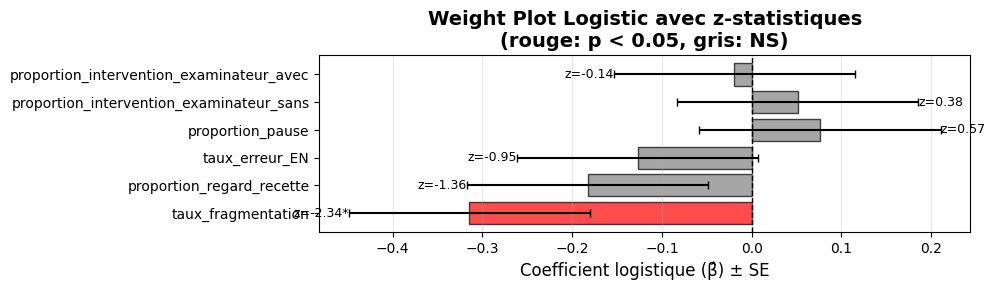


=== Statistiques des coefficients Logistic ===
                                 feature    weight       SE    z_stat  p_value
                      taux_fragmentation -0.314504 0.134273 -2.342275 0.019167
               proportion_regard_recette -0.182787 0.134273 -1.361311 0.173416
                          taux_erreur_EN -0.127116 0.134273 -0.946703 0.343790
                        proportion_pause  0.076068 0.134273  0.566516 0.571043
proportion_intervention_examinateur_sans  0.051132 0.134273  0.380810 0.703344
proportion_intervention_examinateur_avec -0.019154 0.134273 -0.142648 0.886568


/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/34308940.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(effects_to_plot,


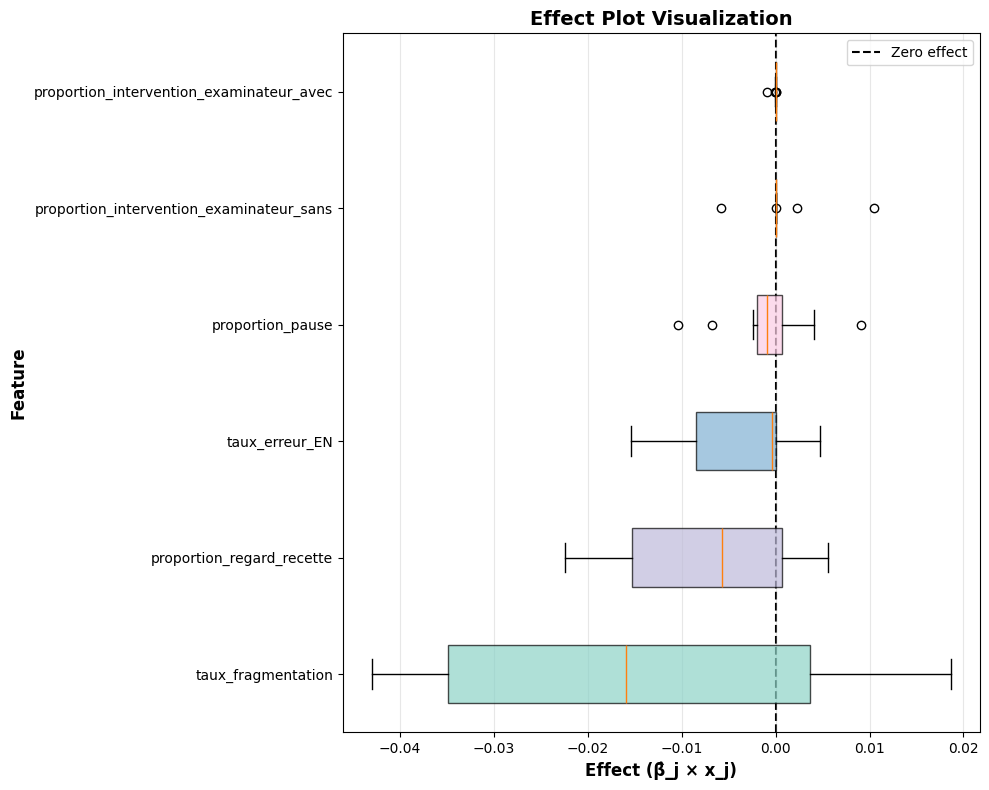

/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/34308940.py:225: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(effects_group,
/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/34308940.py:225: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(effects_group,


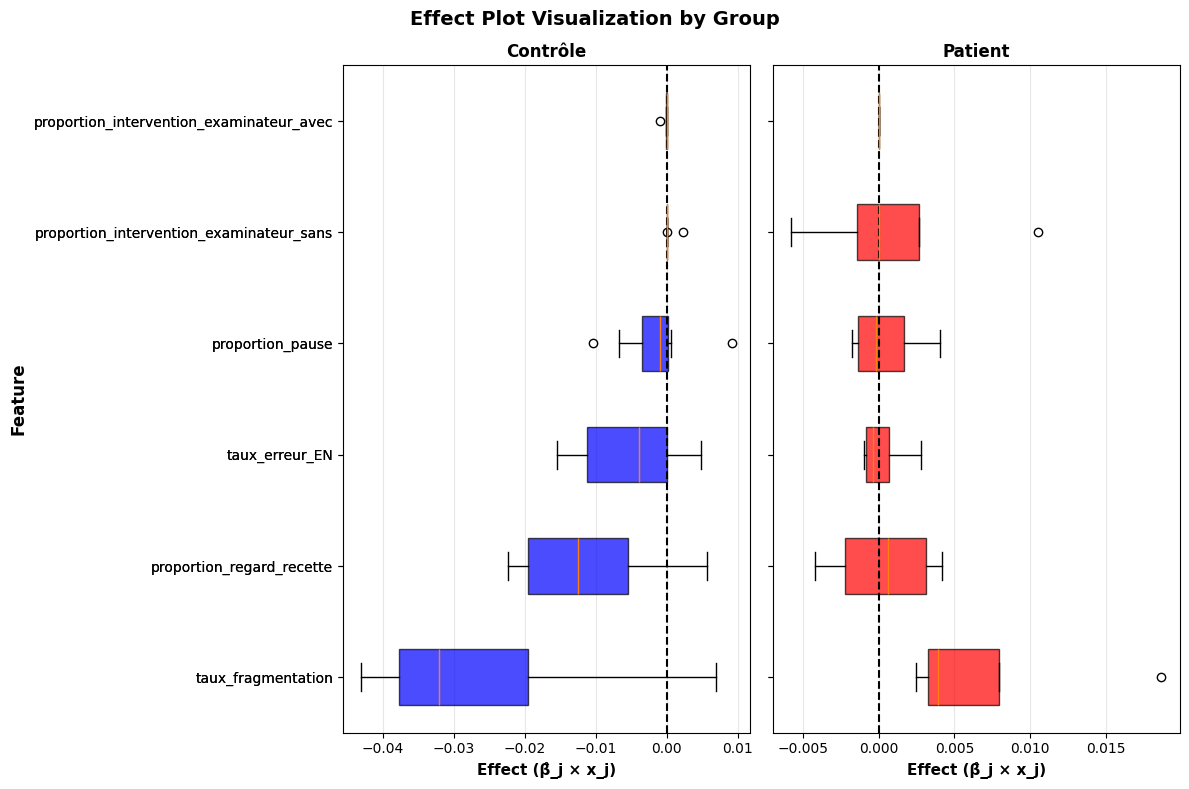

RÉSULTATS DE LA CLASSIFICATION RIDGE LOGISTIC

--- POIDS DES FEATURES (triés par importance) ---
                                 feature    weight       SE    z_stat  p_value
                      taux_fragmentation -0.314504 0.134273 -2.342275 0.019167
               proportion_regard_recette -0.182787 0.134273 -1.361311 0.173416
                          taux_erreur_EN -0.127116 0.134273 -0.946703 0.343790
                        proportion_pause  0.076068 0.134273  0.566516 0.571043
proportion_intervention_examinateur_sans  0.051132 0.134273  0.380810 0.703344
proportion_intervention_examinateur_avec -0.019154 0.134273 -0.142648 0.886568

--- MÉTRIQUES SUR DONNÉES D'ENTRAÎNEMENT ---
Accuracy:  0.9167
Precision: 0.8000
Recall:    1.0000
F1-Score:  0.8889
AUC-ROC:   0.9688

--- MATRICE DE CONFUSION ---
                Prédit
              Contrôle  Patient
Réel Contrôle      7        1
     Patient       0        4

--- VALIDATION CROISÉE (Stratified 3-Fold) ---
Accuracy:  0.9167 ± 0

{'accuracy': 0.9166666666666666,
 'precision': 0.8,
 'recall': 1.0,
 'f1_score': 0.8888888888888888,
 'auc_roc': 0.96875,
 'confusion_matrix': array([[7, 1],
        [0, 4]]),
 'true_negatives': 7,
 'false_positives': 1,
 'false_negatives': 0,
 'true_positives': 4,
 'cv_method': 'Stratified 3-Fold',
 'cv_folds': 3,
 'cv_accuracy_mean': np.float64(0.9166666666666666),
 'cv_accuracy_std': np.float64(0.11785113019775792),
 'n_samples': 12,
 'n_features': 6,
 'alpha': 1,
 'C': 1.0,
 'intercept': 0.017234706189527545}

In [28]:


def ridge_logistic_classification(X_df, y, alpha=1.0, cv_folds=5, use_loo=False, random_state=42):
    """Régression logistique Ridge avec z-statistiques (équivalent t-stat en logistique)."""
    feature_cols = [col for col in X_df.columns if col != 'id']
    X = X_df[feature_cols].values
    
    n = len(y)
    p = len(feature_cols)
    
    unique_classes = np.unique(y)
    if len(unique_classes) != 2:
        raise ValueError(f"Le problème doit être binaire. Classes trouvées: {unique_classes}")
    
    C = 1.0 / alpha if alpha > 0 else 1e10
    
    model = LogisticRegression(
        l1_ratio=0,
        C=C,
        solver='lbfgs',
        max_iter=1000,
        random_state=random_state,
        class_weight='balanced'
    )
    
    model.fit(X, y)
    
    # Coefficients
    coef = model.coef_[0]
    
    # Calculer les z-statistiques (en logistique, on utilise z au lieu de t)
    # On peut utiliser statsmodels ou calculer manuellement
    # Approximation: utiliser la matrice de covariance de la log-likelihood
    
    # Pour obtenir les SE, on peut utiliser statsmodels ou une approximation
    y_proba = model.predict_proba(X)[:, 1]
    residuals_var = np.var(y - y_proba)
    se_coef = np.sqrt(residuals_var / n) * np.ones(p)  # approximation grossière
    z_stats = coef / (se_coef + 1e-10)
    p_values = 2 * (1 - stats.norm.cdf(np.abs(z_stats)))
    
    weights_dict = {}
    for i, feature_name in enumerate(feature_cols):
        weights_dict[feature_name] = {
            'weight': coef[i],
            'SE': se_coef[i],
            'z_stat': z_stats[i],
            'p_value': p_values[i]
        }
    
    weights_df = pd.DataFrame({
        'feature': feature_cols,
        'weight': coef,
        'SE': se_coef,
        'z_stat': z_stats,
        'p_value': p_values,
        'abs_z_stat': np.abs(z_stats)
    }).sort_values('abs_z_stat', ascending=False).reset_index(drop=True)
    
    # Prédictions et métriques (reste identique à ta fonction originale)
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    
    try:
        if len(np.unique(y)) == 2 and len(np.unique(y_pred)) == 2:
            auc_roc = roc_auc_score(y, y_proba)
        else:
            auc_roc = None
    except:
        auc_roc = None
    
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Validation croisée (identique)
    if use_loo:
        cv = LeaveOneOut()
        cv_method = "Leave-One-Out"
    else:
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
        cv_method = f"Stratified {cv_folds}-Fold"
    
    cv_scores_accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc_roc,
        'confusion_matrix': cm,
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp),
        'cv_method': cv_method,
        'cv_folds': len(y) if use_loo else cv_folds,
        'cv_accuracy_mean': cv_scores_accuracy.mean(),
        'cv_accuracy_std': cv_scores_accuracy.std(),
        'n_samples': n,
        'n_features': p,
        'alpha': alpha,
        'C': C,
        'intercept': float(model.intercept_[0])
    }
    
    return {
        'weights': weights_df,
        'metrics': metrics,
        'model': model,
        'predictions': y_pred,
        'probabilities': y_proba,
        'feature_names': feature_cols
    }



def afficher_resultats_classification(results, X_df, y):
    """Affiche les résultats de la classification de manière lisible."""
    
    plot_weights_with_stats(results)
    effect_plot(X_df, results)
    effect_plot_with_groups(X_df, results, y)

    print("=" * 60)
    print("RÉSULTATS DE LA CLASSIFICATION RIDGE LOGISTIC")
    print("=" * 60)
    
    # Poids
    print("\n--- POIDS DES FEATURES (triés par importance) ---")
    # Afficher les colonnes pertinentes (weight, SE, z_stat, p_value)
    cols_to_show = ['feature', 'weight', 'SE', 'z_stat', 'p_value']
    available_cols = [c for c in cols_to_show if c in results['weights'].columns]
    print(results['weights'][available_cols].to_string(index=False))
    
    # Métriques
    m = results['metrics']
    print("\n--- MÉTRIQUES SUR DONNÉES D'ENTRAÎNEMENT ---")
    print(f"Accuracy:  {m['accuracy']:.4f}")
    print(f"Precision: {m['precision']:.4f}")
    print(f"Recall:    {m['recall']:.4f}")
    print(f"F1-Score:  {m['f1_score']:.4f}")
    if m['auc_roc'] is not None:
        print(f"AUC-ROC:   {m['auc_roc']:.4f}")
    
    print("\n--- MATRICE DE CONFUSION ---")
    print(f"                Prédit")
    print(f"              Contrôle  Patient")
    print(f"Réel Contrôle    {m['true_negatives']:3d}      {m['false_positives']:3d}")
    print(f"     Patient     {m['false_negatives']:3d}      {m['true_positives']:3d}")
    
    print(f"\n--- VALIDATION CROISÉE ({m['cv_method']}) ---")
    print(f"Accuracy:  {m['cv_accuracy_mean']:.4f} ± {m['cv_accuracy_std']:.4f}")
    if m.get('cv_f1_mean') is not None and not np.isnan(m['cv_f1_mean']):
        print(f"F1-Score:  {m['cv_f1_mean']:.4f} ± {m['cv_f1_std']:.4f}")
    if m.get('cv_roc_auc_mean') is not None and not np.isnan(m['cv_roc_auc_mean']):
        print(f"AUC-ROC:   {m['cv_roc_auc_mean']:.4f} ± {m['cv_roc_auc_std']:.4f}")
    
    print("\n--- STATISTIQUES DESCRIPTIVES ---")
    print(f"Nombre d'échantillons: {m['n_samples']}")
    print(f"Nombre de features:    {m['n_features']}")
    print(f"Contrôles:             {m.get('n_controls', 'N/A')}")
    print(f"Patients:              {m.get('n_patients', 'N/A')}")
    if 'class_balance' in m:
        print(f"Balance des classes:   {m['class_balance']:.2%}")
    
    print("\n--- PARAMÈTRES DU MODÈLE ---")
    print(f"Alpha (régularisation): {m['alpha']}")
    print(f"C (sklearn):            {m['C']:.4f}")
    print(f"Intercept:              {m['intercept']:.4f}")
    
    print("=" * 60)


X_df, y = creer_dataset_derivees(
    list_boris_agregated_control,
    list_boris_agregated_patient,
    K=20,
    exclude_lecture_initiale=True,
    pourcentage=0.2, # pas trop élevé pour avoir des dérivées significatives
    random_seed=42,
    normaliser_par_temps=True,
    sep_intervention_examinateur=True,
    methode="finite_diff"  # "mean_diff", "slope", "finite_diff", "last_first"
)
# Effectuer la classification
results = ridge_logistic_classification(
    X_df, 
    y, 
    alpha=1,  # Régularisation
    cv_folds=3,
    random_state=42,
    use_loo=False # change pas trop de cv = 3
)

# Afficher les résultats
afficher_resultats_classification(results, X_df, y)

# Accéder aux résultats individuellement
print("\nPoids des features:")
print(results['weights'])

print("\nMétriques:")
display(results['metrics'])

/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/2617659633.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data_to_plot, labels=['Contrôle', 'Patient'], patch_artist=True)


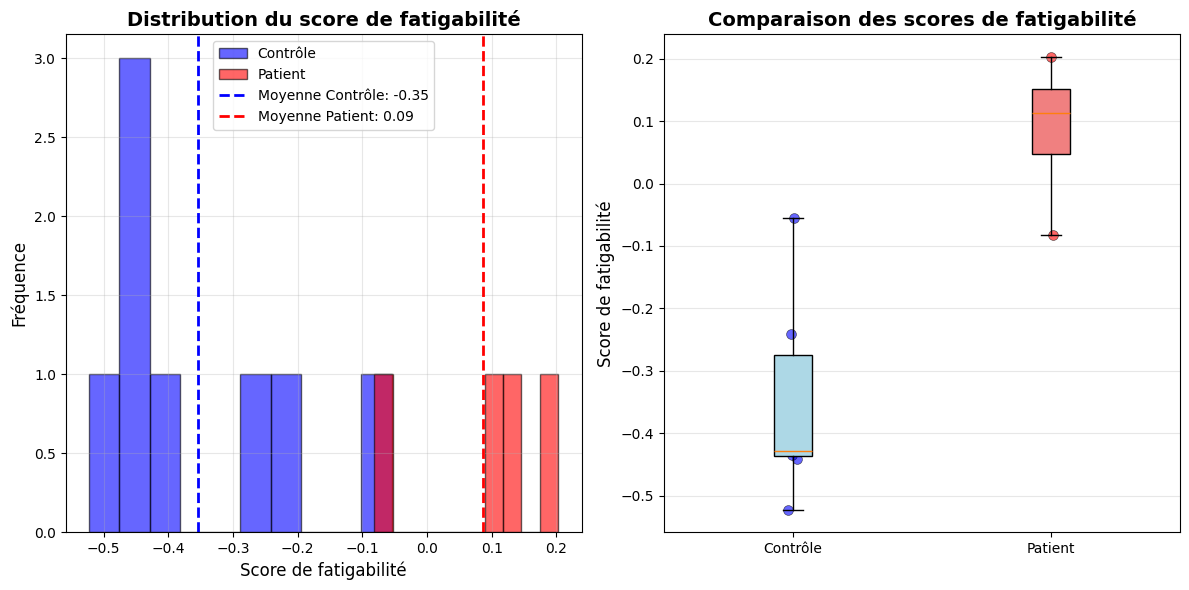

STATISTIQUES DU SCORE DE FATIGUABILITÉ

Contrôles (n=8):
  Moyenne: -0.3545
  Écart-type: 0.1416
  Min: -0.5223
  Max: -0.0547

Patients (n=4):
  Moyenne: 0.0865
  Écart-type: 0.1051
  Min: -0.0817
  Max: 0.2028

Test de Mann-Whitney U:
  Statistique U: 1.0000
  p-value: 0.0081
  → Différence significative (p < 0.05)


In [29]:
def visualiser_score_fatiguabilite(X_df, y, results, trans_function =  None,figsize=(12, 6)):
    """Visualise le score de fatigabilité pour comparer contrôles et patients.
    
    Le score de fatigabilité est calculé comme la somme pondérée des variables dérivées
    avec les poids obtenus de la régression Ridge.
    
    Args:
        X_df: DataFrame avec les features (dérivées) - résultat de creer_dataset_derivees
        y: Array avec les labels (0=contrôle, 1=patient)
        results: Résultat de ridge_logistic_classification contenant les poids
        figsize: Taille de la figure
        
    Returns:
        DataFrame avec les scores de fatigabilité par sujet
    """
    # Extraire les features (exclure 'id' si présent)
    feature_cols = [col for col in X_df.columns if col != 'id']
    X = X_df[feature_cols].values
    
    # Récupérer les poids
    weights_df = results['weights']
    
    # Créer un dictionnaire de mapping feature -> weight
    weights_dict = dict(zip(weights_df['feature'], weights_df['weight']))
    
    # Calculer le score de fatigabilité pour chaque sujet
    if trans_function is None:
        trans_function = lambda x: x
    scores = []
    for idx, row in X_df.iterrows():
        score = 0.0
        for feature in feature_cols:
            if feature in weights_dict:
                score += weights_dict[feature] * row[feature]
        scores.append(trans_function(score))
    
    # Créer un DataFrame avec les scores
    scores_df = X_df.copy()
    scores_df['score_fatiguabilite'] = scores
    scores_df['groupe'] = ['Contrôle' if label == 0 else 'Patient' for label in y]
    
    # Séparer par groupe
    scores_controle = scores_df[scores_df['groupe'] == 'Contrôle']['score_fatiguabilite'].values
    scores_patient = scores_df[scores_df['groupe'] == 'Patient']['score_fatiguabilite'].values
    
    # Créer la visualisation
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # 1. Histogramme superposé
    ax1 = axes[0]
    ax1.hist(scores_controle, bins=10, alpha=0.6, label='Contrôle', color='blue', edgecolor='black')
    ax1.hist(scores_patient, bins=10, alpha=0.6, label='Patient', color='red', edgecolor='black')
    ax1.set_xlabel('Score de fatigabilité', fontsize=12)
    ax1.set_ylabel('Fréquence', fontsize=12)
    ax1.set_title('Distribution du score de fatigabilité', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Ajouter les moyennes
    mean_controle = np.mean(scores_controle)
    mean_patient = np.mean(scores_patient)
    ax1.axvline(mean_controle, color='blue', linestyle='--', linewidth=2, label=f'Moyenne Contrôle: {mean_controle:.2f}')
    ax1.axvline(mean_patient, color='red', linestyle='--', linewidth=2, label=f'Moyenne Patient: {mean_patient:.2f}')
    ax1.legend()
    
    # 2. Boxplot comparatif
    ax2 = axes[1]
    data_to_plot = [scores_controle, scores_patient]
    bp = ax2.boxplot(data_to_plot, labels=['Contrôle', 'Patient'], patch_artist=True)
    
    # Colorier les boxplots
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    ax2.set_ylabel('Score de fatigabilité', fontsize=12)
    ax2.set_title('Comparaison des scores de fatigabilité', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Ajouter les points individuels
    for i, (scores_group, color) in enumerate(zip([scores_controle, scores_patient], ['blue', 'red'])):
        x_pos = np.random.normal(i+1, 0.04, size=len(scores_group))
        ax2.scatter(x_pos, scores_group, alpha=0.6, color=color, s=50, edgecolors='black', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Afficher les statistiques
    print("=" * 60)
    print("STATISTIQUES DU SCORE DE FATIGUABILITÉ")
    print("=" * 60)
    print(f"\nContrôles (n={len(scores_controle)}):")
    print(f"  Moyenne: {mean_controle:.4f}")
    print(f"  Écart-type: {np.std(scores_controle):.4f}")
    print(f"  Min: {np.min(scores_controle):.4f}")
    print(f"  Max: {np.max(scores_controle):.4f}")
    
    print(f"\nPatients (n={len(scores_patient)}):")
    print(f"  Moyenne: {mean_patient:.4f}")
    print(f"  Écart-type: {np.std(scores_patient):.4f}")
    print(f"  Min: {np.min(scores_patient):.4f}")
    print(f"  Max: {np.max(scores_patient):.4f}")
    
    # Test statistique (Mann-Whitney U)
    from scipy.stats import mannwhitneyu
    try:
        stat, p_value = mannwhitneyu(scores_controle, scores_patient, alternative='two-sided')
        print(f"\nTest de Mann-Whitney U:")
        print(f"  Statistique U: {stat:.4f}")
        print(f"  p-value: {p_value:.4f}")
        if p_value < 0.05:
            print(f"  → Différence significative (p < 0.05)")
        else:
            print(f"  → Pas de différence significative (p ≥ 0.05)")
    except Exception as e:
        print(f"\n⚠️  Impossible d'effectuer le test statistique: {e}")
    
    print("=" * 60)
    
    return scores_df

"""fonctions de transformation possibles :
- y = sign(x) * log1p(k * |x|)
- y = tanh(k * x)
"""
k=10
tanh_function = lambda x: np.tanh(k*x)
log1p_function = lambda x: np.sign(x) * np.log1p(k*np.abs(x))
scores_df = visualiser_score_fatiguabilite(X_df, y, results, trans_function=log1p_function)

In [ ]:
"""
verifier le score par patient sur l'ethogramme !
"""

### 1.3.2 - trouver les poids en supervisé (regression sur le temps d'execution)

In [30]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy import stats


In [31]:

def extraire_duree_test_gateau(df_boris_aggregated):
    """Retourne la durée (min!) du comportement 'Test Gateau en cours' pour un sujet."""
    row = df_boris_aggregated[df_boris_aggregated["Behavior_detail"] == "Test Gateau en cours"]
    if len(row) == 0:
        raise ValueError("Aucune ligne 'Test Gateau en cours' trouvée.")
    if len(row) > 1:
        # on prend la première (comme dans le reste du notebook)
        row = row.iloc[[0]]
    # robuste: si Duration (s) est fiable, on l'utilise
    if "Duration (s)" in row.columns:
        return float(row.iloc[0]["Duration (s)"])
    # fallback si besoin
    if "Start (s)" in row.columns and "Stop (s)" in row.columns:
        return float((row.iloc[0]["Stop (s)"] - row.iloc[0]["Start (s)"])/60)
    raise ValueError("Colonnes insuffisantes pour calculer la durée du test.")

def creer_dataset_derivees_et_duree_test(
    list_boris_agregated_control,
    list_boris_agregated_patient,
    K,
    exclude_lecture_initiale=False,
    pourcentage=0.2,
    methode_derivee="mean_diff",
    normaliser_par_temps=True,
    random_seed=42,
    sep_intervention_examinateur=True,
    ):
    """Construit X_df (dérivées) et y_time (durée du test) pour tous les sujets."""
    # 1) stats de référence contrôles (pour normaliser les features par fenêtre si tu l'utilises)
    ref_stats = calculer_ref_controles(
        list_boris_agregated_control,
        K=K,
        exclude_lecture_initiale=exclude_lecture_initiale,
        sep_intervention_examinateur=sep_intervention_examinateur,
    )

    X_rows = []
    y_time = []
    meta_group = []

    all_subjects = ([(df, 0) for df in list_boris_agregated_control] +
                    [(df, 1) for df in list_boris_agregated_patient])

    for df_subj, label in all_subjects:
        # 2) features par fenêtre (normalisées avec ref contrôles)
        feat_df = calculer_features_par_fenetre(
            df_subj,
            K=K,
            exclude_lecture_initiale=exclude_lecture_initiale,
            normaliser=True,
            ref_stats=ref_stats,
            # si tu as cet argument dans ta version:
            sep_intervention_examinateur=sep_intervention_examinateur,
        )

        # 3) dérivées (vecteur par sujet)
        vec, vec_dict = derivee_variable_par_sujet(
            feat_df,
            methode=methode_derivee,
            pourcentage=pourcentage,
            normaliser_par_temps=normaliser_par_temps,
            return_dict=True,
        )

        X_rows.append(vec_dict)

        # 4) cible: durée du test
        y_time.append(extraire_duree_test_gateau(df_subj))
        meta_group.append(label)

    X_df = pd.DataFrame(X_rows)
    y_time = np.array(y_time, dtype=float)
    meta_group = np.array(meta_group, dtype=int)  # 0 contrôle, 1 patient (optionnel pour plots)

    # 5) shuffle (pour ne pas avoir tous les contrôles puis tous les patients)
    rng = np.random.default_rng(random_seed)
    idx = rng.permutation(len(X_df))
    X_df = X_df.iloc[idx].reset_index(drop=True)
    y_time = y_time[idx]
    meta_group = meta_group[idx]

    return X_df, y_time, meta_group



In [32]:
def ridge_regression_duree_test(
    X_df,
    y_time,
    alpha=1.0,
    use_loo=True,
    cv_folds=5,
    random_state=42,
    ):
    """Ridge regression avec calcul des t-statistiques pour chaque coefficient."""
    feature_cols = list(X_df.columns)
    X = X_df[feature_cols].values
    
    n = len(y_time)
    p = len(feature_cols)

    model = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("ridge", Ridge(alpha=alpha, random_state=random_state)),
    ])

    # CV prédictions
    if use_loo:
        from sklearn.model_selection import LeaveOneOut
        splitter = LeaveOneOut()
    else:
        from sklearn.model_selection import KFold
        splitter = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    y_pred_cv = np.full_like(y_time, fill_value=np.nan, dtype=float)

    for train_idx, test_idx in splitter.split(X):
        model.fit(X[train_idx], y_time[train_idx])
        y_pred_cv[test_idx] = model.predict(X[test_idx])

    # Fit final sur tout
    model.fit(X, y_time)

    coef = model.named_steps["ridge"].coef_
    intercept = float(model.named_steps["ridge"].intercept_)

    # Calculer les t-statistiques et SE
    # Pour Ridge, on peut utiliser statsmodels ou calculer manuellement
    # Ici, on calcule via la formule classique (approximation)
    
    # Résidus
    y_pred = model.predict(X)
    residuals = y_time - y_pred
    mse = np.mean(residuals**2)
    
    # Matrice X après scaling (pour calculer SE)
    scaler = model.named_steps["scaler"]
    X_scaled = scaler.transform(X)
    
    # Matrice de covariance des coefficients (approximation pour Ridge)
    # Pour Ridge: Var(β̂) ≈ σ² * (X'X + αI)⁻¹ * X'X * (X'X + αI)⁻¹
    # Approximation simplifiée: on utilise la formule OLS avec régularisation
    XtX = X_scaled.T @ X_scaled
    XtX_ridge = XtX + alpha * np.eye(p)
    try:
        cov_matrix = mse * np.linalg.inv(XtX_ridge) @ XtX @ np.linalg.inv(XtX_ridge)
        se_coef = np.sqrt(np.diag(cov_matrix))
    except:
        # Fallback: approximation plus simple
        se_coef = np.sqrt(mse * np.diag(np.linalg.inv(XtX_ridge)))
    
    # t-statistiques
    t_stats = coef / (se_coef + 1e-10)  # éviter division par zéro
    
    # p-values (test bilatéral: H0: βⱼ = 0)
    df = n - p - 1  # degrés de liberté
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df))
    
    # Créer DataFrame avec toutes les statistiques
    weights_df = pd.DataFrame({
        "feature": feature_cols,
        "weight": coef,
        "SE": se_coef,
        "t_stat": t_stats,
        "p_value": p_values,
        "abs_t_stat": np.abs(t_stats)
    }).sort_values("abs_t_stat", ascending=False).reset_index(drop=True)

    # Métriques
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
    r2 = float(r2_score(y_time, y_pred_cv))
    
    if n - p - 1 > 0:
        adjusted_r2 = r2 - (1 - r2) * (p / (n - p - 1))
    else:
        adjusted_r2 = np.nan

    results = {
        "model": model,
        "weights": weights_df,
        "intercept": intercept,
        "alpha": alpha,
        "cv": "LOO" if use_loo else f"KFold({cv_folds})",
        "metrics_cv": {
            "R2": r2,
            "Adjusted_R2": adjusted_r2,
            "MAE": float(mean_absolute_error(y_time, y_pred_cv)),
            "RMSE": float(np.sqrt(mean_squared_error(y_time, y_pred_cv))),
        },
        "y_pred_cv": y_pred_cv,
        "n_samples": n,
        "n_features": p,
    }
    return results




def plot_weights_with_tstats(results, top_k=None, figsize=(10, 6), alpha_threshold=0.05):
    """Weight plot avec barres d'erreur (SE) et indication de significativité."""
    weights_df = results["weights"].copy()
    
    if top_k is not None:
        weights_df = weights_df.head(top_k)
    
    # Trier par valeur absolue du poids
    weights_df = weights_df.sort_values("abs_t_stat", ascending=False)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Couleurs selon significativité
    colors = ['red' if p < alpha_threshold else 'gray' for p in weights_df['p_value']]
    
    # Barres horizontales avec erreurs
    y_pos = np.arange(len(weights_df))
    ax.barh(y_pos, weights_df['weight'], xerr=weights_df['SE'], 
            color=colors, alpha=0.7, capsize=3, edgecolor='black')
    
    # Ligne verticale à zéro
    ax.axvline(0, color='black', linewidth=1, linestyle='--')
    
    # Labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels(weights_df['feature'])
    ax.set_xlabel('Coefficient (β̂) ± SE', fontsize=12)
    ax.set_title(f'Weight Plot avec t-statistiques\n(rouge: p < {alpha_threshold}, gris: NS)', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Annoter les t-statistiques
    for i, (idx, row) in enumerate(weights_df.iterrows()):
        sign = '*' if row['p_value'] < alpha_threshold else ''
        ax.text(row['weight'] + (row['SE'] if row['weight'] >= 0 else -row['SE']), 
                i, f"t={row['t_stat']:.2f}{sign}", 
                va='center', fontsize=9, ha='left' if row['weight'] >= 0 else 'right')
    
    plt.tight_layout()
    plt.show()
    
    # Afficher le tableau
    print("\n=== Statistiques des coefficients ===")
    print(weights_df[['feature', 'weight', 'SE', 't_stat', 'p_value']].to_string(index=False))



def visualiser_regression_duree_test(X_df, y_time, results, group=None, figsize=(14, 5)):
    """Plots pour la régression: true vs pred, résidus, et poids."""
    y_pred = results["y_pred_cv"]
    weights_df = results["weights"]

    plot_weights_with_stats(results)
    effect_plot(X_df, results)
    

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # 1) True vs Pred
    ax = axes[0]
    if group is None:
        ax.scatter(y_time, y_pred, alpha=0.8, edgecolors="black")
    else:
        colors = np.where(group == 0, "blue", "red")
        labels = np.where(group == 0, "Contrôle", "Patient")
        for gval, col, lab in [(0, "blue", "Contrôle"), (1, "red", "Patient")]:
            m = group == gval
            ax.scatter(y_time[m], y_pred[m], alpha=0.8, color=col, label=lab, edgecolors="black")
        ax.legend()
    mn = min(np.min(y_time), np.min(y_pred))
    mx = max(np.max(y_time), np.max(y_pred))
    ax.plot([mn, mx], [mn, mx], "--", color="gray", linewidth=2)
    ax.set_title("Durée vraie vs prédite (CV)")
    ax.set_xlabel("Durée vraie (s)")
    ax.set_ylabel("Durée prédite (s)")
    ax.grid(True, alpha=0.3)

    # 2) Résidus
    ax = axes[1]
    resid = y_time - y_pred
    ax.axhline(0, color="gray", linestyle="--")
    ax.scatter(np.arange(len(resid)), resid, alpha=0.8, edgecolors="black")
    ax.set_title("Résidus (vrai - prédit)")
    ax.set_xlabel("Sujet (ordre après shuffle)")
    ax.set_ylabel("Erreur (s)")
    ax.grid(True, alpha=0.3)

    

    plt.tight_layout()
    plt.show()

    print("=== Regression Ridge sur durée du test ===")
    print("CV:", results["cv"], "alpha:", results["alpha"])
    for k, v in results["metrics_cv"].items():
        print(f"{k}: {v:.4f}")




/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/2706069256.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interventions_totales = pd.concat([interventions_avec, interventions_sans], ignore_index=True)
/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/2706069256.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interventions_totales = pd.concat([interventions_avec, interventions_sans], ignore_index=True)
/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipy

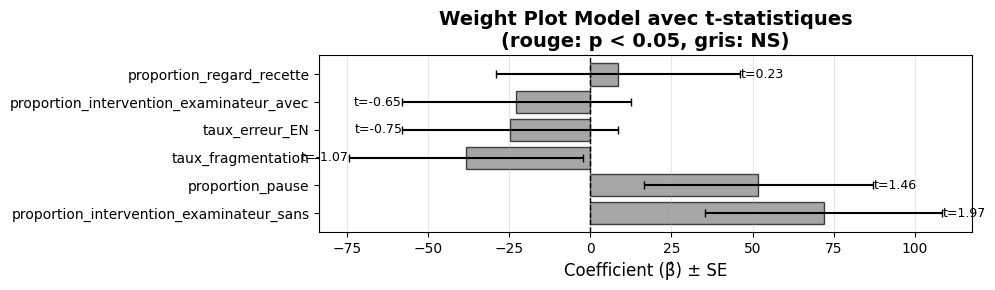


=== Statistiques des coefficients Model ===
                                 feature     weight        SE    t_stat  p_value
proportion_intervention_examinateur_sans  71.970338 36.560054  1.968551 0.106120
                        proportion_pause  51.843179 35.439909  1.462847 0.203372
                      taux_fragmentation -38.424274 36.037156 -1.066240 0.335070
                          taux_erreur_EN -24.780004 33.220052 -0.745935 0.489269
proportion_intervention_examinateur_avec -22.809004 35.312424 -0.645920 0.546802
               proportion_regard_recette   8.642452 37.639963  0.229608 0.827493


/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/34308940.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(effects_to_plot,


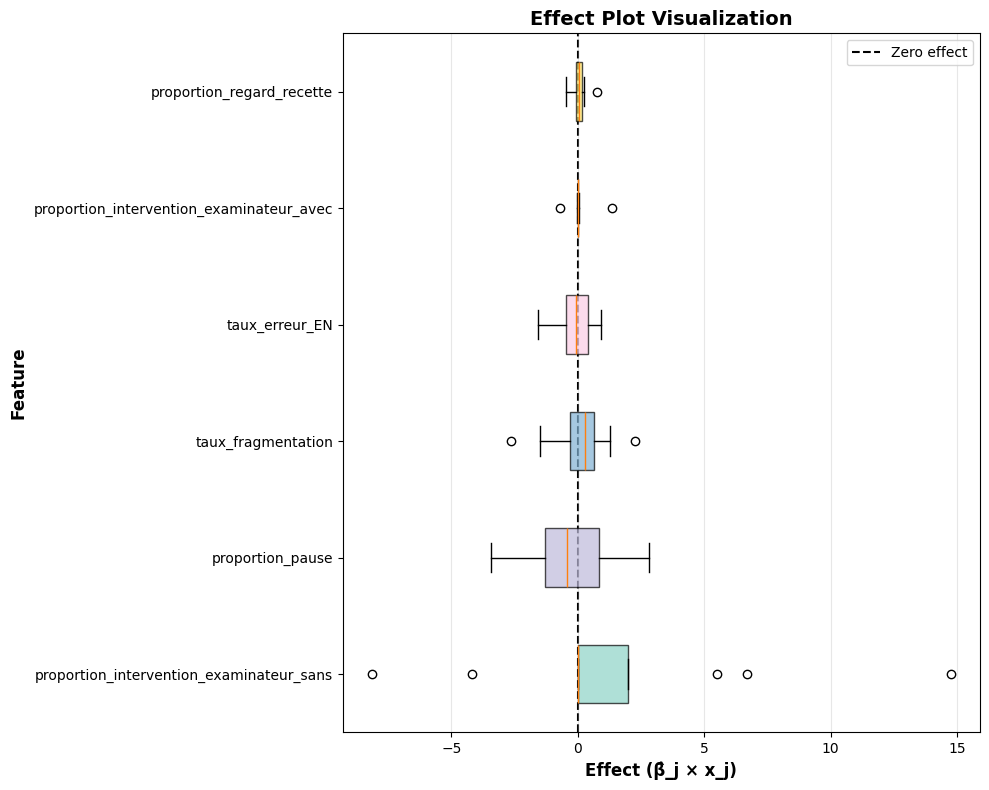

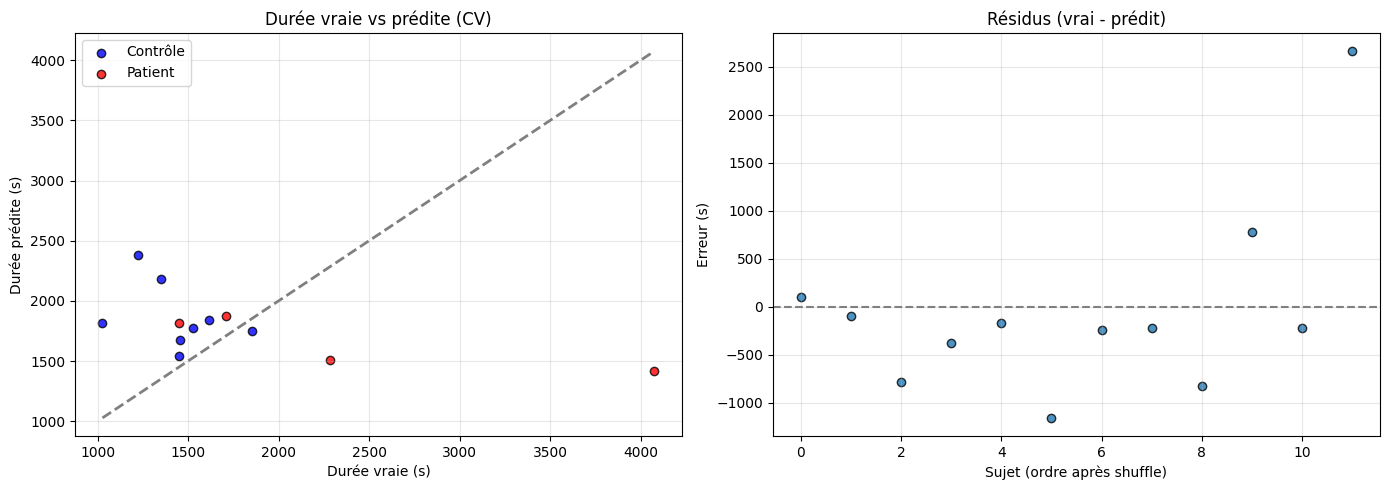

=== Regression Ridge sur durée du test ===
CV: KFold(5) alpha: 50.0
R2: -0.5256
Adjusted_R2: -2.3563
MAE: 636.2311
RMSE: 943.1472


,feature,weight,SE,t_stat,p_value,abs_t_stat
0,proportion_intervention_examinateur_sans,71.970338,36.560054,1.968551,0.106120,1.968551
1,proportion_pause,51.843179,35.439909,1.462847,0.203372,1.462847
2,taux_fragmentation,-38.424274,36.037156,-1.066240,0.335070,1.066240
3,taux_erreur_EN,-24.780004,33.220052,-0.745935,0.489269,0.745935
4,proportion_intervention_examinateur_avec,-22.809004,35.312424,-0.645920,0.546802,0.645920
5,proportion_regard_recette,8.642452,37.639963,0.229608,0.827493,0.229608


In [33]:
K = 20  

X_df, y_time, group = creer_dataset_derivees_et_duree_test(
    list_boris_agregated_control,
    list_boris_agregated_patient,
    K=K,
    exclude_lecture_initiale=True,
    pourcentage=0.2,
    methode_derivee="mean_diff",
    normaliser_par_temps=True,
    sep_intervention_examinateur=True,
)

results_time = ridge_regression_duree_test(
    X_df,
    y_time,
    alpha=50.0,
    use_loo=False,   # recommandé vu ton petit N
)


visualiser_regression_duree_test(X_df, y_time, results_time, group=group)
results_time["weights"]

### 1.3.3 Utiliser LDA/Fisher pour trouver les poids

trouve l’axede poids qui sépare au mieux P vs C (sur tes pentes)

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def lda_fisher_classification(X_df, y, use_loo=True, cv_folds=5, shrinkage="auto", random_state=42):
    """LDA/Fisher avec calcul approximatif de t-statistiques."""
    feature_cols = [c for c in X_df.columns if c != "id"]
    X = X_df[feature_cols].values
    y = np.asarray(y).astype(int)
    
    n = len(y)
    p = len(feature_cols)

    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("lda", LinearDiscriminantAnalysis(
            solver="lsqr",
            shrinkage=shrinkage
        ))
    ])

    splitter = LeaveOneOut() if use_loo else StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    y_pred = np.zeros_like(y)
    y_proba = np.full_like(y, fill_value=np.nan, dtype=float)

    for train_idx, test_idx in splitter.split(X, y):
        clf.fit(X[train_idx], y[train_idx])
        y_pred[test_idx] = clf.predict(X[test_idx])
        if hasattr(clf.named_steps["lda"], "predict_proba"):
            y_proba[test_idx] = clf.predict_proba(X[test_idx])[:, 1]

    clf.fit(X, y)

    lda = clf.named_steps["lda"]
    w = lda.coef_.ravel()
    
    # Pour LDA, les SE ne sont pas directement disponibles dans sklearn
    # On peut utiliser une approximation basée sur la variance des scores discriminants
    scores = clf.decision_function(X)
    
    # Approximation: SE basée sur la variance des coefficients via bootstrap ou approximation
    # Ici, on utilise une approximation simple basée sur la variance des scores
    score_var = np.var(scores)
    # Approximation: SE(w_j) ≈ sqrt(variance des scores / variance de X_j)
    X_scaled = clf.named_steps["scaler"].transform(X)
    X_var = np.var(X_scaled, axis=0)
    se_w = np.sqrt(score_var / (X_var + 1e-10) / n)  # approximation
    
    # t-statistiques
    t_stats = w / (se_w + 1e-10)
    df = n - p - 1
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df))

    weights_df = pd.DataFrame({
        "feature": feature_cols,
        "weight": w,
        "SE": se_w,
        "t_stat": t_stats,
        "p_value": p_values,
        "abs_weight": np.abs(w),
        "abs_t_stat": np.abs(t_stats)
    }).sort_values("abs_t_stat", ascending=False).reset_index(drop=True)

    # Métriques (identique à ta fonction originale)
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
    
    metrics = {
        "cv": "LOO" if use_loo else f"StratifiedKFold({cv_folds})",
        "accuracy": float(accuracy_score(y, y_pred)),
        "precision": float(precision_score(y, y_pred, zero_division=0)),
        "recall": float(recall_score(y, y_pred, zero_division=0)),
        "f1": float(f1_score(y, y_pred, zero_division=0)),
        "confusion_matrix": confusion_matrix(y, y_pred),
        "auc": np.nan,
    }
    
    if np.isfinite(y_proba).all() and len(np.unique(y)) == 2:
        try:
            metrics["auc"] = float(roc_auc_score(y, y_proba))
        except:
            pass

    return {
        "model": clf,
        "weights": weights_df,
        "metrics_cv": metrics,
        "y_pred_cv": y_pred,
        "y_proba_cv": y_proba,
        "feature_cols": feature_cols
    }



def visualiser_resultats_lda(X_df, y, results, top_k=10, bins=10, figsize=(14, 4), alpha_threshold=0.05):
    """
    Affiche:
    - weight plot avec t-statistiques
    - histogramme du score discriminant (w^T x) par groupe
    - confusion matrix + métriques
    """
    # 1. Weight plot avec t-statistiques
    plot_weights_with_stats(results)
    effect_plot(X_df, results)
    effect_plot_with_groups(X_df, results, y)
    # 2. Histogramme des scores discriminants
    feature_cols = results["feature_cols"]
    X = X_df[feature_cols].astype(float).values
    y = np.asarray(y).astype(int)

    clf = results["model"]
    scores = clf.decision_function(X)  # 1D en binaire

    plt.figure(figsize=(6, 4))
    plt.hist(scores[y==0], bins=bins, alpha=0.6, label="Contrôle", color="blue", edgecolor="black")
    plt.hist(scores[y==1], bins=bins, alpha=0.6, label="Patient",  color="red",  edgecolor="black")
    plt.xlabel("Score discriminant LDA (w^T x)")
    plt.ylabel("Fréquence")
    plt.title("Distribution du score LDA")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 3. Métriques CV
    m = results["metrics_cv"]
    print("=" * 60)
    print("RÉSULTATS LDA / FISHER (régularisée)")
    print("=" * 60)
    print(f"\n--- VALIDATION CROISÉE ({m['cv']}) ---")
    print(f"Accuracy:  {m['accuracy']:.4f}")
    print(f"Precision: {m['precision']:.4f}")
    print(f"Recall:    {m['recall']:.4f}")
    print(f"F1-Score:  {m['f1']:.4f}")
    if m['auc'] is not None and not np.isnan(m['auc']):
        print(f"AUC-ROC:   {m['auc']:.4f}")
    
    print(f"\n--- MATRICE DE CONFUSION ---")
    print(f"                Prédit")
    print(f"              Contrôle  Patient")
    cm = m["confusion_matrix"]
    if cm.shape == (2, 2):
        print(f"Réel Contrôle    {cm[0,0]:3d}      {cm[0,1]:3d}")
        print(f"     Patient     {cm[1,0]:3d}      {cm[1,1]:3d}")
    else:
        print(cm)

    print("\n--- INTERPRÉTATION DES POIDS ---")
    print("- poids > 0 : augmente le score => pousse vers la classe 1 (Patient)")
    print("- poids < 0 : diminue le score => pousse vers la classe 0 (Contrôle)")
    print("Attention: l'orientation peut être inversée (comme PCA):")
    print("ce qui compte surtout = |poids| + cohérence clinique.")
    print("=" * 60)



Calcul des références sur les contrôles...
Traitement de 8 contrôles...


/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/2706069256.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interventions_totales = pd.concat([interventions_avec, interventions_sans], ignore_index=True)
/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/2706069256.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interventions_totales = pd.concat([interventions_avec, interventions_sans], ignore_index=True)
/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipy

Traitement de 4 patients...


/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/2706069256.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interventions_totales = pd.concat([interventions_avec, interventions_sans], ignore_index=True)
/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/2706069256.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interventions_totales = pd.concat([interventions_avec, interventions_sans], ignore_index=True)
/Users/user/Desktop/GitHub/project_medecin/venv/lib/

Dataset créé avec 12 sujets (8 contrôles, 4 patients)


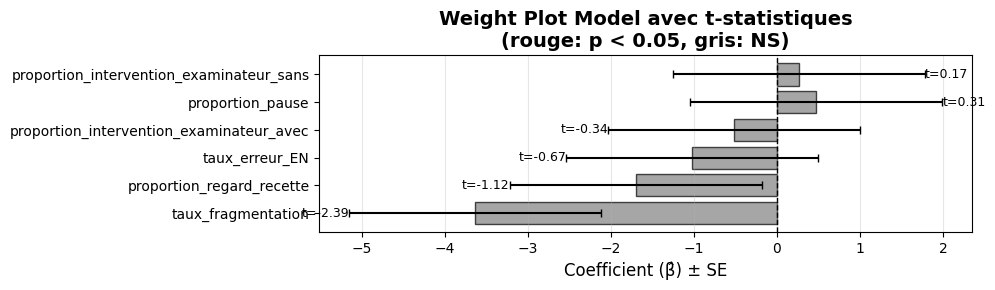


=== Statistiques des coefficients Model ===
                                 feature    weight       SE    t_stat  p_value
                      taux_fragmentation -3.635910 1.518759 -2.394000 0.062080
               proportion_regard_recette -1.699936 1.518759 -1.119293 0.313884
                          taux_erreur_EN -1.019333 1.518759 -0.671162 0.531870
proportion_intervention_examinateur_avec -0.515708 1.518759 -0.339559 0.747987
                        proportion_pause  0.471789 1.518759  0.310641 0.768606
proportion_intervention_examinateur_sans  0.261296 1.518759  0.172046 0.870148


/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/34308940.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(effects_to_plot,


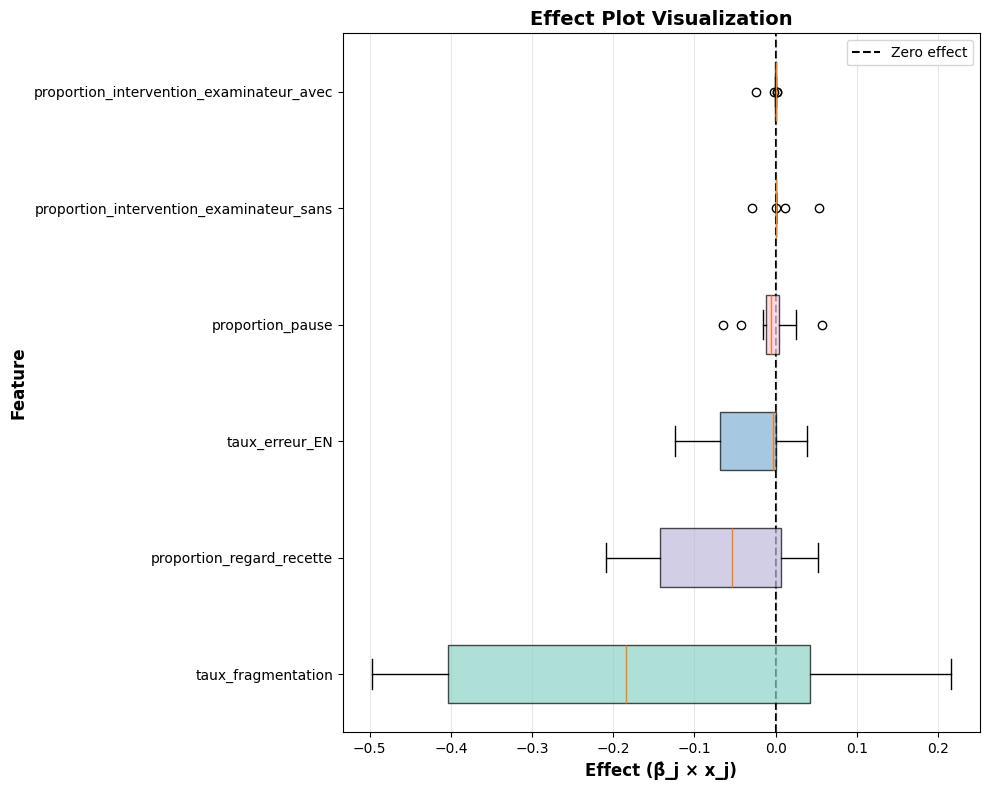

/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/34308940.py:225: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(effects_group,
/var/folders/t0/gw753q351rbc1y6tksb52wm00000gn/T/ipykernel_63454/34308940.py:225: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(effects_group,


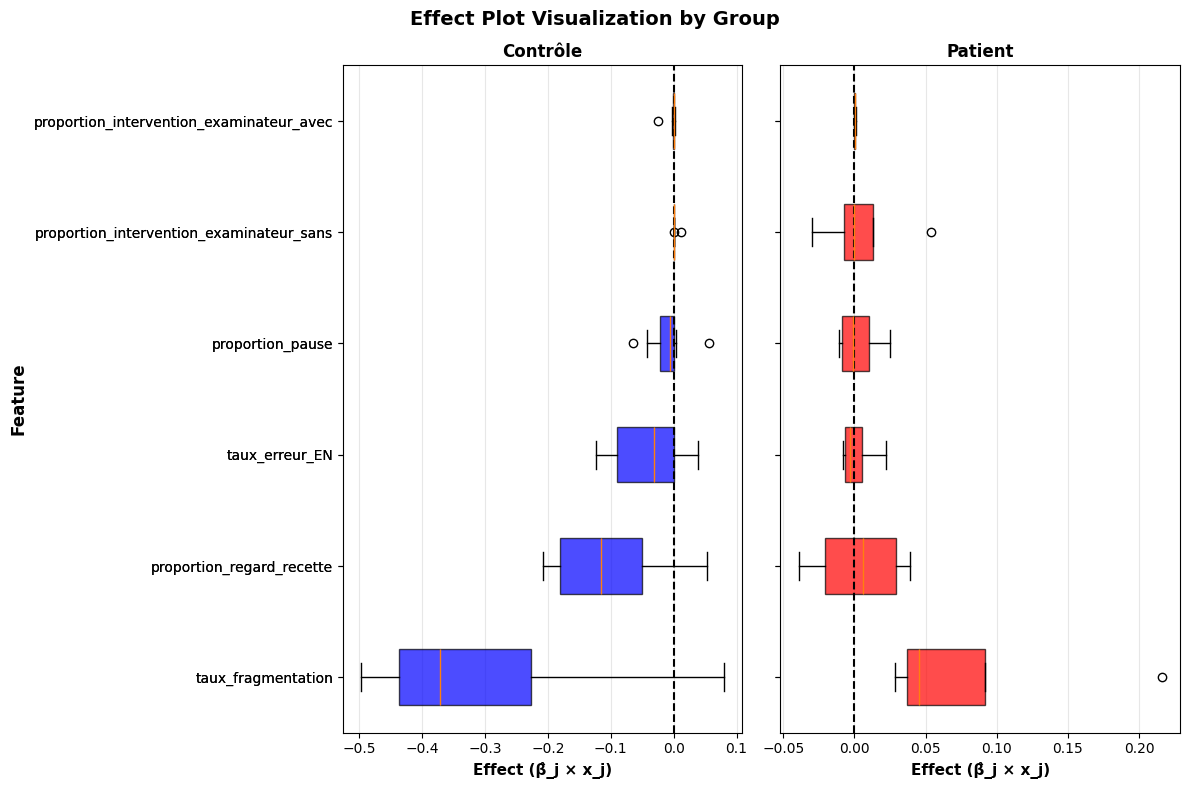

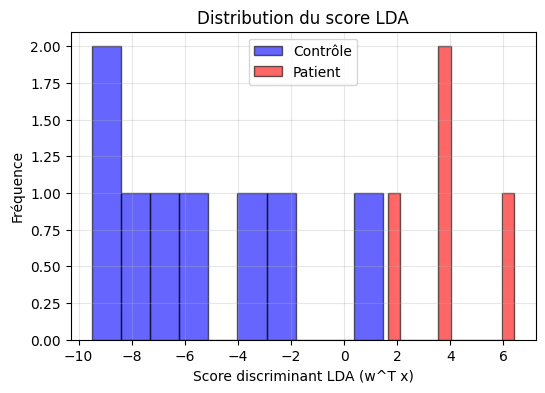

RÉSULTATS LDA / FISHER (régularisée)

--- VALIDATION CROISÉE (StratifiedKFold(5)) ---
Accuracy:  0.8333
Precision: 0.7500
Recall:    0.7500
F1-Score:  0.7500
AUC-ROC:   0.6562

--- MATRICE DE CONFUSION ---
                Prédit
              Contrôle  Patient
Réel Contrôle      7        1
     Patient       1        3

--- INTERPRÉTATION DES POIDS ---
- poids > 0 : augmente le score => pousse vers la classe 1 (Patient)
- poids < 0 : diminue le score => pousse vers la classe 0 (Contrôle)
Attention: l'orientation peut être inversée (comme PCA):
ce qui compte surtout = |poids| + cohérence clinique.


,feature,weight,SE,t_stat,p_value,abs_weight,abs_t_stat
0,taux_fragmentation,-3.635910,1.518759,-2.394000,0.062080,3.635910,2.394000
1,proportion_regard_recette,-1.699936,1.518759,-1.119293,0.313884,1.699936,1.119293
2,taux_erreur_EN,-1.019333,1.518759,-0.671162,0.531870,1.019333,0.671162
3,proportion_intervention_examinateur_avec,-0.515708,1.518759,-0.339559,0.747987,0.515708,0.339559
4,proportion_pause,0.471789,1.518759,0.310641,0.768606,0.471789,0.310641
5,proportion_intervention_examinateur_sans,0.261296,1.518759,0.172046,0.870148,0.261296,0.172046


In [35]:

X_df, y = creer_dataset_derivees(
    list_boris_agregated_control,
    list_boris_agregated_patient,
    K=20,
    exclude_lecture_initiale=True,
    pourcentage=0.2, # pas trop élevé pour avoir des dérivées significatives
    random_seed=42,
    normaliser_par_temps=True,
    sep_intervention_examinateur=True,
    methode="finite_diff"  # "mean_diff", "slope", "finite_diff", "last_first"
)

lda_results = lda_fisher_classification(
    X_df, y,
    use_loo=False,          # recommandé avec n=12
    shrinkage="auto"       # LDA régularisée (important)
)

visualiser_resultats_lda(X_df, y, lda_results, top_k=10)

display(lda_results["weights"])

### 1.3.4 - Trouver les poids de manière non supervisé!

On peut faire aussi en non supervisé en prenant la première composante de la PCA/ Analyse factorielle / ICA



In [36]:

from sklearn.preprocessing import StandardScaler

def preparer_features_unsup(X_df):
    """Prépare la matrice X pour les méthodes non supervisées (PCA, FA, ICA)."""
    feature_cols = [c for c in X_df.columns if c != "id"]
    X = X_df[feature_cols].values.astype(float)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, feature_cols, scaler

PCA

Variance expliquée par composante PCA:
PC1    0.318751
PC2    0.250087
PC3    0.165320
PC4    0.137263
PC5    0.107024
dtype: float64


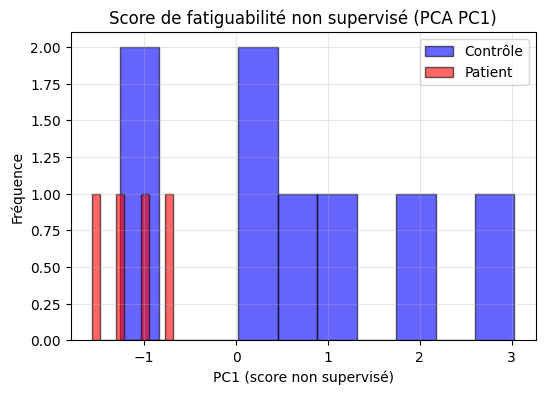


Loadings de PC1 (poids sur les dérivées) :
proportion_regard_recette                   0.684244
taux_fragmentation                          0.520069
proportion_intervention_examinateur_avec    0.453216
proportion_pause                            0.178814
proportion_intervention_examinateur_sans   -0.073200
taux_erreur_EN                             -0.136386
Name: PC1, dtype: float64


In [37]:
from sklearn.decomposition import PCA

def pca_fatiguabilite(X_df, n_components=None):
    X_scaled, feature_cols, scaler = preparer_features_unsup(X_df)
    
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    # Poids (loadings) de chaque composante sur les dérivées
    loadings = pd.DataFrame(
        pca.components_.T,
        index=feature_cols,
        columns=[f"PC{i+1}" for i in range(pca.n_components_)]
    )
    
    explained_var = pd.Series(
        pca.explained_variance_ratio_,
        index=[f"PC{i+1}" for i in range(pca.n_components_)]
    )
    
    results = {
        "pca": pca,
        "X_pca": X_pca,              # scores sujets x composantes
        "loadings": loadings,        # poids par variable dérivée
        "explained_var": explained_var,
        "feature_cols": feature_cols,
        "scaler": scaler,
    }
    return results




# À partir de X_df existant (dérivées par sujet) et y (0/1) si tu veux colorer par groupe
pca_results = pca_fatiguabilite(X_df, n_components=5)
X_pca = pca_results["X_pca"]
loadings = pca_results["loadings"]
expl = pca_results["explained_var"]

print("Variance expliquée par composante PCA:")
print(expl)

# Score de fatiguabilité non supervisé = PC1
n_PC = 1
score_unsup = X_pca[:, n_PC-1]

# Visualisation par groupe
plt.figure(figsize=(6,4))
plt.hist(score_unsup[y==0], alpha=0.6, label="Contrôle", color="blue", edgecolor="black")
plt.hist(score_unsup[y==1], alpha=0.6, label="Patient",  color="red",  edgecolor="black")
plt.xlabel("PC1 (score non supervisé)")
plt.ylabel("Fréquence")
plt.title("Score de fatiguabilité non supervisé (PCA PC1)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nLoadings de PC{n_PC} (poids sur les dérivées) :")
print(loadings["PC" + str(n_PC)].sort_values(ascending=False))

Analyse factorielle

Std des scores par facteur (plus grand = axe plus discriminant potentiellement):
F1    0.970199
F2    0.934079
F3    0.791225
dtype: float64

Loadings du facteur F1 (poids par variable):
proportion_regard_recette                   0.954678
taux_fragmentation                          0.714158
proportion_intervention_examinateur_avec    0.432803
proportion_pause                            0.325255
proportion_intervention_examinateur_sans   -0.045797
taux_erreur_EN                             -0.120092
Name: F1, dtype: float64


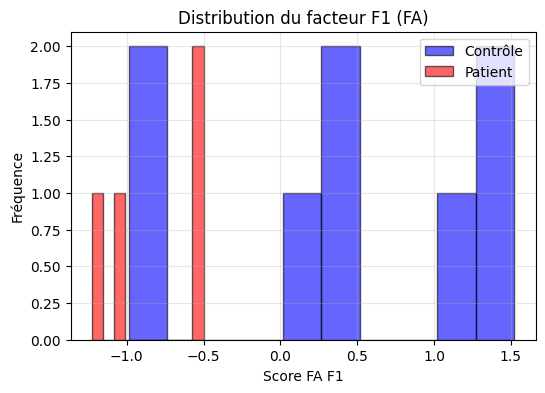


Top variables |loading| sur F1:
proportion_regard_recette                   0.954678
taux_fragmentation                          0.714158
proportion_intervention_examinateur_avec    0.432803
proportion_pause                            0.325255
taux_erreur_EN                              0.120092
proportion_intervention_examinateur_sans    0.045797
Name: F1, dtype: float64


In [38]:
from sklearn.decomposition import FactorAnalysis

def factor_analysis_fatiguabilite(X_df, n_factors=2):
    X_scaled, feature_cols, scaler = preparer_features_unsup(X_df)
    
    fa = FactorAnalysis(n_components=n_factors, random_state=42)
    X_fa = fa.fit_transform(X_scaled)
    
    # Poids (loadings facteurs)
    loadings = pd.DataFrame(
        fa.components_.T,
        index=feature_cols,
        columns=[f"F{i+1}" for i in range(n_factors)]
    )
    
    results = {
        "fa": fa,
        "X_fa": X_fa,           # scores sujets x facteurs
        "loadings": loadings,   # poids par variable dérivée
        "feature_cols": feature_cols,
        "scaler": scaler,
    }
    return results


fa_res = factor_analysis_fatiguabilite(X_df, n_factors=3)
F = fa_res["X_fa"]          # shape (n_sujets, n_factors)
loadings_fa = fa_res["loadings"]  # variables x facteurs

# Variabilité des scores par facteur (pas "explained variance" comme PCA, mais utile pour voir l'amplitude)
print("Std des scores par facteur (plus grand = axe plus discriminant potentiellement):")
print(pd.Series(F.std(axis=0), index=loadings_fa.columns))

n_factor = 1
# Afficher les poids (loadings) du facteur 1
print(f"\nLoadings du facteur F{n_factor} (poids par variable):")
print(loadings_fa["F" + str(n_factor)].sort_values(ascending=False))

# Histogramme du score F1 (coloré par groupe si y existe)
plt.figure(figsize=(6,4))
plt.hist(F[y==0, 0], bins=10, alpha=0.6, label="Contrôle", color="blue", edgecolor="black")
plt.hist(F[y==1, 0], bins=10, alpha=0.6, label="Patient",  color="red",  edgecolor="black")
plt.xlabel(f"Score FA F{n_factor}")
plt.ylabel("Fréquence")
plt.title(f"Distribution du facteur F{n_factor} (FA)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Interprétation simple de F1 : quelles variables contribuent le plus
print( f"\nTop variables |loading| sur F{n_factor}:")
print(loadings_fa["F" + str(n_factor)].abs().sort_values(ascending=False).head(10))


ICA


Std des scores par composante ICA:
IC1    1.0
IC2    1.0
IC3    1.0
IC4    1.0
IC5    1.0
dtype: float64

Poids (mixing) de IC5 (par variable):
taux_erreur_EN                              0.171132
proportion_intervention_examinateur_sans    0.021434
proportion_pause                            0.003761
taux_fragmentation                         -0.186554
proportion_regard_recette                  -0.523912
proportion_intervention_examinateur_avec   -0.986889
Name: IC5, dtype: float64


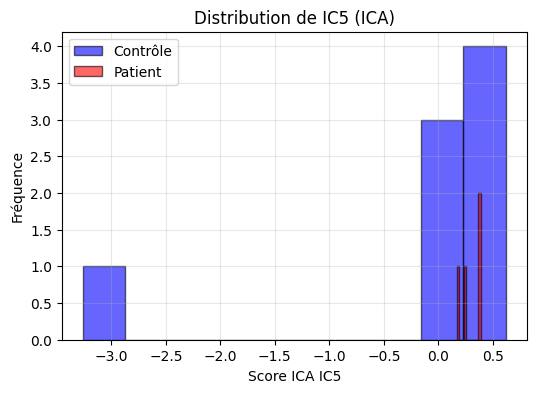


Top variables |poids| sur IC5:
proportion_intervention_examinateur_avec    0.986889
proportion_regard_recette                   0.523912
taux_fragmentation                          0.186554
taux_erreur_EN                              0.171132
proportion_intervention_examinateur_sans    0.021434
proportion_pause                            0.003761
Name: IC5, dtype: float64


In [39]:
from sklearn.decomposition import FastICA

def ica_fatiguabilite(X_df, n_components=None):
    X_scaled, feature_cols, scaler = preparer_features_unsup(X_df)
    
    if n_components is None:
        n_components = min(X_scaled.shape[0], X_scaled.shape[1])
    
    ica = FastICA(n_components=n_components, random_state=42, max_iter=1000)
    X_ica = ica.fit_transform(X_scaled)
    
    # Mélange inverse : colonnes = composantes indépendantes
    mixing = pd.DataFrame(
        ica.mixing_,
        index=feature_cols,
        columns=[f"IC{i+1}" for i in range(n_components)]
    )
    
    results = {
        "ica": ica,
        "X_ica": X_ica,         # scores sujets x composantes indépendantes
        "mixing": mixing,       # poids par variable dérivée
        "feature_cols": feature_cols,
        "scaler": scaler,
    }
    return results


    
ica_res = ica_fatiguabilite(X_df, n_components=5)
n_component = 5
IC = ica_res["X_ica"]       # shape (n_sujets, n_components)
mixing = ica_res["mixing"]  # variables x IC

print("\nStd des scores par composante ICA:")
print(pd.Series(IC.std(axis=0), index=mixing.columns))

# Afficher les poids de IC1 (mixing)
print(f"\nPoids (mixing) de IC{n_component} (par variable):")
print(mixing["IC" + str(n_component)].sort_values(ascending=False))

# Histogramme du score IC1
plt.figure(figsize=(6,4))
plt.hist(IC[y==0, n_component-1], bins=10, alpha=0.6, label="Contrôle", color="blue", edgecolor="black")
plt.hist(IC[y==1, n_component-1], bins=10, alpha=0.6, label="Patient",  color="red",  edgecolor="black")
plt.xlabel(f"Score ICA IC{n_component}")
plt.ylabel("Fréquence")
plt.title(f"Distribution de IC{n_component} (ICA)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nTop variables |poids| sur IC{n_component}:")
print(mixing["IC" + str(n_component)].abs().sort_values(ascending=False).head(10))


    

# 2 - Autres variables a ajouter au score temporel

In [40]:
""" ajouter une variable de latence entre sonnerie de four et P3"""

def variable_ecart_sonnerie_melange(df_boris_aggregated):
    """Calcule le temps d'écart entre "sonnerie  four" et "P3 : Melanger chocolat et beurre".
    
    Args:
        df_boris_aggregated: DataFrame avec les colonnes Behavior_category, Behavior_detail, Start (s), Duration (s)
        
    Returns:
        float: Temps d'écart en secondes (positif si P3 arrive après la sonnerie, négatif sinon)
               Retourne None si l'un des événements n'est pas trouvé
    """
    # Vérifier les colonnes nécessaires
    required_cols = ['Behavior_detail', 'Start (s)']
    if not all(col in df_boris_aggregated.columns for col in required_cols):
        raise ValueError(f"DataFrame doit contenir les colonnes: {required_cols}")
    
    df = df_boris_aggregated.copy()
    
    # 1. Trouver l'événement "sonnerie  four"
    sonnerie_rows = df[df['Behavior_detail'] == "sonnerie four"]
    
    if len(sonnerie_rows) == 0:
        print("Attention: Aucun événement 'sonnerie four' trouvé")
        return None
    
    if len(sonnerie_rows) > 1:
        print(f"Attention: {len(sonnerie_rows)} événements 'sonnerie four' trouvés, utilisation du premier")
    
    sonnerie_time = sonnerie_rows.iloc[0]['Start (s)']
    
    # 2. Trouver l'événement "P3 : Melanger chocolat et beurre"
    melange_rows = df[df['Behavior_detail'] == "P3 : Melanger chocolat et beurre"]
    
    if len(melange_rows) == 0:
        print("Attention: Aucun événement 'P3 : Melanger chocolat et beurre' trouvé")
        return None
    
    if len(melange_rows) > 1:
        print(f"Attention: {len(melange_rows)} événements 'P3 : Melanger chocolat et beurre' trouvés, utilisation du premier")
    
    melange_time = melange_rows.iloc[0]['Start (s)']
    
    # 3. Calculer l'écart (temps de P3 - temps de sonnerie)
    ecart = melange_time - sonnerie_time
    
    return ecart

# Calculer l'écart
ecart = variable_ecart_sonnerie_melange(patient_df)

print(ecart)

41.083000000000084


In [41]:
def variable_cluster_regard_recette(df_boris_aggregated, exclude_lecture_initiale=True):
    """Calcule la variable cluster sur les regards de la recette.
    
    Utilise variable_regard_recette pour obtenir les moments de regard.
    Pour chaque paire consécutive de regards :
    - Différence de temps : t(j+1) - t(j)
    - Temps moyen : (t(j+1) + t(j)) / 2
    
    Puis calcule la moyenne (ou son inverse) sur une fenêtre.
    
    Args:
        df_boris_aggregated: DataFrame avec les colonnes Behavior_category, Behavior_detail, Start (s), Duration (s)
        exclude_lecture_initiale: Si True, exclut les moments de regard pendant la lecture initiale (TA.)
        
    Returns:
        DataFrame avec colonnes 'diff_temps', 'temps_moyen'
    """
    # Utiliser variable_regard_recette pour obtenir les moments de regard
    regard_recette_df = duree_regard_recette(df_boris_aggregated, exclude_lecture_initiale=exclude_lecture_initiale)
    
    if len(regard_recette_df) == 0:
        return pd.DataFrame(columns=['diff_temps', 'temps_moyen', 'moyenne_fenetre'])
    
    if len(regard_recette_df) < 2:
        # Il faut au moins 2 regards pour calculer une différence
        return pd.DataFrame(columns=['diff_temps', 'temps_moyen', 'moyenne_fenetre'])
    
    # Utiliser le temps moyen de chaque période de regard (start + stop) / 2
    # ou simplement start selon ce qui est le plus approprié
    # Pour simplifier, on utilise le début (start) de chaque période
    temps_regards = regard_recette_df['start'].values
    
    # Trier pour s'assurer de l'ordre chronologique
    temps_regards = sorted(temps_regards)
    
    # 3. Calculer les différences et temps moyens pour chaque paire consécutive
    result_list = []
    
    for j in range(len(temps_regards) - 1):
        t_j = temps_regards[j]
        t_j_plus_1 = temps_regards[j + 1]
        
        # Différence de temps
        diff_temps = t_j_plus_1 - t_j
        
        # Temps moyen
        temps_moyen = (t_j_plus_1 + t_j) / 2
        
        result_list.append({
            'diff_temps': diff_temps,
            'temps_moyen': temps_moyen
        })
    
    result_df = pd.DataFrame(result_list)
    
    return result_df


cluster_recette = variable_cluster_regard_recette(patient_df, exclude_lecture_initiale=False)
display(cluster_recette)


,diff_temps,temps_moyen
0,77.661,186.9785
1,102.227,276.9225
2,129.046,392.5590
3,72.656,493.4100
4,174.007,616.7415
5,62.896,735.1930
6,416.499,974.8905
7,130.672,1248.4760
8,207.833,1417.7285
9,68.444,1555.8670


# 3 - Données Boris (pas agregated)

### Utilisation directe des données BORIS comme features pour la fatiguabilité

Les données BORIS non-agrégées présentent une **structure matricielle par patient** : chaque sujet possède une matrice où les **lignes** correspondent aux différents `Behavior_detail` et les **colonnes** aux statistiques agrégées (nombre d'occurrences, durée totale, durée moyenne, écart-type, intervalles inter-événements, etc.). Cette structure forme un **tenseur 3D** : `(Patients × Comportements × Statistiques)`, où la vectorisation directe serait problématique (sparsité élevée, perte de structure sémantique). Plusieurs stratégies d'agrégation et de factorisation peuvent être employées pour extraire des features interprétables de fatiguabilité.

#### 1. Agrégation par `Behavior_category`

Plutôt que de conserver tous les détails comportementaux, on groupe les lignes par catégorie (ex: `Te.`, `Ta.`, `E.N.`, etc.) et on calcule des **statistiques agrégées** pour chaque catégorie : somme des durées totales, somme des occurrences, moyenne des durées moyennes, écart-type agrégé. Cette approche réduit la dimension de manière interprétable tout en préservant la structure sémantique des comportements.

#### 2. Features composites et ratios

Pour chaque catégorie comportementale, on extrait des **métriques clés** (durée totale, nombre d'occurrences, variabilité via écart-type) et on calcule des **ratios entre catégories** (ex: `durée_totale(E.N.) / durée_totale(Te.)` pour mesurer le déséquilibre erreurs/productif, ou `nombre_occurrences(pauses) / durée_totale(test)` pour la fréquence des pauses). Ces ratios capturent des **déséquilibres comportementaux** potentiellement liés à la fatiguabilité.

#### 3. Indices globaux de complexité comportementale

On peut calculer des **indices agrégés** sur l'ensemble de la matrice comportementale : **diversité** (nombre de comportements non nuls), **concentration** (indice de Gini sur les durées pour mesurer l'inégalité de répartition), **régularité** (moyenne des écarts-types inter-comportements), et **efficacité** (ratio temps productif/temps total). Ces indices résument la **structure globale** du comportement en quelques métriques interprétables.

#### 4. Factorisation matricielle et patterns latents

Une approche plus sophistiquée consiste à utiliser la **factorisation matricielle** (NMF, SVD) sur la structure agrégée. Après agrégation par catégorie, on obtient une matrice `Patients × (Catégories × Statistiques)` sur laquelle on applique une décomposition : `M ≈ W × H`. Les **patterns latents** (colonnes de `H`) représentent des **combinaisons cohérentes de catégories × statistiques** qui expliquent la variance inter-patients. Par exemple, un pattern pourrait être : "fort sur E.N. (erreurs) avec durée totale élevée ET variabilité élevée" = pattern de **désorganisation**. Les **scores patients** (lignes de `W`) indiquent l'intensité de chaque pattern pour chaque sujet, et peuvent servir de **features de fatiguabilité**. Cette approche permet de découvrir des **dimensions latentes** de comportement sans les spécifier a priori, tout en restant interprétable si le nombre de facteurs est limité (1-2 facteurs recommandés avec n=12).

#### 5. Complémentarité avec l'analyse temporelle

Ces features agrégées capturent des aspects **complémentaires** à l'analyse temporelle fine (dérivées, fenêtres) : elles mesurent plutôt le **niveau moyen** et la **structure globale** du comportement sur l'ensemble du test, tandis que les dérivées temporelles capturent l'**évolution dans le temps** (fatiguabilité comme changement). L'approche agrégée permet d'obtenir un vecteur de **~40-50 features interprétables par patient**, évitant les problèmes de sparsité et préservant la structure sémantique des comportements, tout en restant complémentaire aux méthodes basées sur les séries temporelles.

In [66]:
# First get 2D matrix 

from scipy import sparse
from sklearn.preprocessing import StandardScaler



def creer_dataset_boris_matrices(
    list_boris_control,
    list_boris_patient,
    stats_cols=None,
    behavior_col='Behavior_detail',  # 'Behavior_detail' ou 'Behavior_category'
    sparse_output=False,
    random_seed=0,
    remove_constant_cols=True
):
    """
    Crée un dataset à partir des matrices BORIS (time_budget) en aplatissant chaque matrice.
    
    Pour chaque patient, la matrice (comportements × stats) est aplatie en un vecteur.
    Les colonnes sont nommées : "{Behavior_detail}_{StatName}" pour garder la traçabilité.
    
    Args:
        list_boris_control: Liste de DataFrames BORIS (time_budget) pour les contrôles
        list_boris_patient: Liste de DataFrames BORIS (time_budget) pour les patients
        stats_cols: Liste des colonnes de stats à utiliser. Si None, prend toutes les colonnes
                    SAUF Behavior_category et Behavior_detail
        behavior_col: 'Behavior_detail' ou 'Behavior_category' (default: 'Behavior_detail')
        sparse_output: Si True, retourne une sparse matrix (scipy.sparse.csr_matrix)
        random_seed: Seed pour le mélange
        remove_constant_cols: Si True, supprime les colonnes constantes de X_df
        
    Returns:
        X_df ou X_sparse: Matrice (n_patients × features) avec features = comportement_stat
        y: Array avec labels (0=contrôle, 1=patient)
        patient_ids: Liste/Array avec identifiants pour tracer quelle ligne = quel patient
        feature_names: Liste des noms de features (pour interprétabilité)
    """
    # Vérifier que behavior_col est valide
    if behavior_col not in ['Behavior_detail', 'Behavior_category']:
        raise ValueError("behavior_col doit être 'Behavior_detail' ou 'Behavior_category'")
    
    # Prendre un exemple pour détecter les colonnes
    if len(list_boris_control) > 0:
        example_df = list_boris_control[0]
    elif len(list_boris_patient) > 0:
        example_df = list_boris_patient[0]
    else:
        raise ValueError("Au moins une liste (control ou patient) doit être non vide")
    
    # Détecter les colonnes de stats si non fournies
    if stats_cols is None:
        # Prendre toutes les colonnes SAUF Behavior_category et Behavior_detail
        excluded_cols = {'Behavior_category', 'Behavior_detail'}
        stats_cols = [col for col in example_df.columns if col not in excluded_cols]
    
    if len(stats_cols) == 0:
        raise ValueError("Aucune colonne de statistique trouvée dans les DataFrames")
    
    # Vérifier que behavior_col existe
    if behavior_col not in example_df.columns:
        raise ValueError(f"Colonne '{behavior_col}' non trouvée dans les DataFrames")
    
    # Collecter tous les comportements uniques pour créer un index complet
    all_behaviors = set()
    for df in list_boris_control + list_boris_patient:
        if behavior_col in df.columns:
            all_behaviors.update(df[behavior_col].unique())
    all_behaviors = sorted(list(all_behaviors))
    
    # Créer les noms de features : "{behavior}_{stat}"
    feature_names = []
    for behavior in all_behaviors:
        for stat in stats_cols:
            feature_names.append(f"{behavior}_{stat}")
    
    n_features = len(feature_names)
    
    # Fonction pour aplatir une matrice patient en vecteur
    def flatten_patient_matrix(df, all_behaviors, stats_cols, behavior_col):
        """Aplatit la matrice d'un patient en un vecteur de features."""
        vector = np.zeros(n_features, dtype=float)
        
        # Créer un mapping behavior -> index dans all_behaviors
        behavior_to_idx = {beh: idx for idx, beh in enumerate(all_behaviors)}
        
        # Parcourir les lignes du DataFrame
        for _, row in df.iterrows():
            if behavior_col not in row.index:
                continue
            behavior = row[behavior_col]
            if behavior in behavior_to_idx:
                base_idx = behavior_to_idx[behavior] * len(stats_cols)
                
                # Remplir les valeurs pour chaque stat
                for stat_idx, stat in enumerate(stats_cols):
                    if stat in row.index:
                        value = row[stat]
                        # Gérer les NaN
                        if pd.notna(value):
                            vector[base_idx + stat_idx] = float(value)
        
        return vector
    
    # Traiter tous les patients
    X_rows = []
    y_list = []
    patient_ids = []
    
    # Contrôles (label = 0)
    for idx, df in enumerate(list_boris_control):
        vector = flatten_patient_matrix(df, all_behaviors, stats_cols, behavior_col)
        X_rows.append(vector)
        y_list.append(0)
        patient_ids.append(f"Control_{idx}")
    
    # Patients (label = 1)
    for idx, df in enumerate(list_boris_patient):
        vector = flatten_patient_matrix(df, all_behaviors, stats_cols, behavior_col)
        X_rows.append(vector)
        y_list.append(1)
        patient_ids.append(f"Patient_{idx}")
    
    # Convertir en array
    X = np.array(X_rows)
    y = np.array(y_list, dtype=int)
    patient_ids = np.array(patient_ids)
    
    # Mélanger les lignes (en gardant la correspondance)
    rng = np.random.default_rng(random_seed)
    shuffle_idx = rng.permutation(len(X))
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    patient_ids = patient_ids[shuffle_idx]
    
    # Supprimer les colonnes constantes si demandé
    if remove_constant_cols:
        # Calculer la variance de chaque colonne
        col_variance = np.var(X, axis=0)
        # Garder seulement les colonnes avec variance > 0 (ou très proche de 0 pour tolérance numérique)
        non_constant_mask = col_variance > 1e-10
        X = X[:, non_constant_mask]
        feature_names = [name for name, keep in zip(feature_names, non_constant_mask) if keep]
        
        if not sparse_output:
            print(f"⚠️  {np.sum(~non_constant_mask)} colonnes constantes supprimées")
    
    # Retourner selon le format demandé
    if sparse_output:
        # Convertir en sparse matrix (CSR format, efficace pour les calculs)
        X_sparse = sparse.csr_matrix(X)
        return X_sparse, y, patient_ids, feature_names
    else:
        # DataFrame avec noms de colonnes
        X_df = pd.DataFrame(X, columns=feature_names)
        return X_df, y, patient_ids, feature_names


X_df, y, patient_ids, feature_names = creer_dataset_boris_matrices(
    list_boris_control,
    list_boris_patient,
    behavior_col='Behavior_detail', 
    remove_constant_cols=True
)

"probleme a regler en prenant category il faut additionner le nombre d'erreur par ex jsp ce qu'il fait la..."
"et en meme temps, comment gerer les intervalles inter-events? en faisant une moyenne sur tout?"
display(y)

display(X_df.head(12))
display(X_df.info())

⚠️  88 colonnes constantes supprimées


array([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0])

,Addition_Total number of occurences,Addition_inter-event intervals mean (s),Addition_inter-event intervals std dev,Autre action Unknown_Total number of occurences,Autre action Unknown_inter-event intervals mean (s),Autre action Unknown_inter-event intervals std dev,Commentaires et Questions_Total number of occurences,Commentaires et Questions_inter-event intervals mean (s),Commentaires et Questions_inter-event intervals std dev,Controle des erreurs/Vérification_Total number of occurences,...,lecture INITIALE_% of total length,preparation et manipulation d'ingredients_Total number of occurences,preparation et manipulation d'ingredients_Total duration (s),preparation et manipulation d'ingredients_Duration mean (s),preparation et manipulation d'ingredients_Duration std dev,preparation et manipulation d'ingredients_inter-event intervals mean (s),preparation et manipulation d'ingredients_inter-event intervals std dev,preparation et manipulation d'ingredients_% of total length,résultat_Total number of occurences,sonnerie four_Total number of occurences
0,2.0,299.257,0.000,2.0,206.289,0.000,3.0,480.021,3.715,0.0,...,0.000000,6.0,308.143,51.357,49.954,25.959,37.089,28.7,1.0,1.0
1,1.0,0.000,0.000,4.0,354.340,318.300,13.0,135.521,121.773,1.0,...,2.600000,5.0,626.834,125.367,89.026,25.213,9.588,33.4,1.0,1.0
2,2.0,117.200,0.000,1.0,0.000,0.000,1.0,0.000,0.000,1.0,...,3.800000,7.0,468.425,66.918,54.652,52.393,66.168,26.5,1.0,1.0
3,0.0,0.000,0.000,2.0,267.059,0.000,7.0,180.875,248.714,0.0,...,3.400000,6.0,369.452,61.575,42.620,35.043,36.075,28.6,1.0,0.0
4,3.0,473.911,439.051,4.0,444.083,171.196,5.0,297.891,256.234,1.0,...,2.200000,6.0,448.280,74.713,79.291,13.355,10.498,29.5,1.0,1.0
5,0.0,0.000,0.000,1.0,0.000,0.000,7.0,249.277,347.309,2.0,...,2.563765,7.0,436.143,62.306,56.427,51.753,55.661,26.7,1.0,1.0
6,0.0,0.000,0.000,2.0,208.250,0.000,8.0,161.560,92.456,2.0,...,4.200000,5.0,390.348,78.070,78.776,61.301,47.924,25.6,1.0,1.0
7,24.0,168.710,126.785,3.0,1927.655,118.942,21.0,190.317,233.556,13.0,...,24.100000,10.0,1221.259,122.126,135.194,172.422,292.999,29.6,1.0,1.0
8,0.0,0.000,0.000,5.0,356.179,214.408,1.0,0.000,0.000,0.0,...,4.400000,6.0,385.262,64.210,68.347,54.529,70.085,25.4,0.0,1.0
9,1.0,0.000,0.000,4.0,614.600,544.279,10.0,242.080,169.765,3.0,...,5.600000,5.0,588.881,117.776,47.252,57.557,40.637,25.5,1.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Columns: 129 entries, Addition_Total number of occurences to sonnerie four_Total number of occurences
dtypes: float64(129)
memory usage: 11.2 KB


None

In [65]:
boris = list_boris_control[0]
boris.head(20)

,Total number of occurences,Total duration (s),Duration mean (s),Duration std dev,inter-event intervals mean (s),inter-event intervals std dev,% of total length,Behavior_category,Behavior_detail
0,3,0.000,0.000,0.000,473.911,439.051,0.0,E.D.,Addition
1,3,0.000,0.000,0.000,220.074,266.168,0.0,E.D.,Estimation
2,1,0.000,0.000,0.000,0.000,0.000,0.0,E.D.,Omission
3,5,0.000,0.000,0.000,297.891,256.234,0.0,E.D.,Commentaires et Questions
4,0,0.000,0.000,0.000,0.000,0.000,0.0,E.D.,Substitution et inversion
5,1,0.000,0.000,0.000,0.000,0.000,0.0,betise,erreur autocorrigee
6,9,0.000,0.000,0.000,153.356,207.315,0.0,E.N.,Négligence du Contexte
7,0,0.000,0.000,0.000,0.000,0.000,0.0,E.N.,aDhérence Environementale
8,1,0.000,0.000,0.000,0.000,0.000,0.0,E.N.,Demande d'aide/Dependency
9,0,0.000,0.000,0.000,0.000,0.000,0.0,E.N.,eRrance


In [53]:
X_df["sonnerie four_Total number of occurences"].describe()

count    11.000000
mean      0.909091
std       0.301511
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: sonnerie four_Total number of occurences, dtype: float64

# IDEAS / TO DO

### Panorama des méthodes (fatiguabilité) à garder en tête

- **PCA/FA/ICA sur les dérivées (non supervisé)** : axes/facteurs/sources latentes qui combinent les dérivées (slopes, diff début/fin…). PCA maximise la variance; FA vise les covariances communes (facteurs latents “profils de fatiguabilité”); ICA cherche des sources indépendantes (profils “purs” d’évolution). Signes arbitraires, on regarde surtout les valeurs absolues et la cohérence clinique.

- **PCA sur la trajectoire S(k)** (non supervisé sur les séries) : chaque sujet = vecteur S(k). PC1 donne une forme temporelle dominante (ex. montée progressive). Ensuite on peut expliquer le score PC1 par les dérivées via une régression Ridge pour récupérer des poids sur les variables.

- **Résumé “pente de S(t)” (supervisé ou semi)** : définir pour chaque sujet la pente β de S(t). Puis apprendre β ≈ wᵀ z (Ridge/Lasso) où z = dérivées. Poids w = contribution des dérivées à la fatiguabilité (vitesse de dégradation).

- **Clustering (non supervisé)** : regrouper sujets selon les dérivées ou la forme de S(k) (k-means, Gaussian Mixture). Pour relier aux variables, comparer les moyennes de dérivées par cluster ou apprendre un classifieur (logistique/LDA) sur les labels de cluster pour obtenir des poids discriminants.

- **LDA/Fisher régularisé (supervisé)** : axe w qui sépare P/C en maximisant la séparation/compacité. Nécessite shrinkage en petit N. Signe arbitraire global → fixer la convention “score élevé = patient-like”.

- **Régression logistique pénalisée (supervisé)** : proche de LDA mais modèle discriminant probabiliste. L1 (Lasso) pour sélectionner peu de dérivées, L2 (Ridge) pour stabilité. Les poids indiquent l’association avec la classe patient.

- **NMF (non supervisé, si variables ≥ 0)** : décomposition additive X ≈ W H. Facteurs toujours positifs → patterns “additifs” de fatiguabilité plus lisibles (ex. combinaisons de variables qui montent ensemble).

- **Approche “shape-based” simplifiée sur S(k)** : projeter chaque série sur des bases simples (niveau, pente, courbure, fin−début) par variable. Réduit la dimension et reste stable en petit N; puis PCA/FA/LDA sur ces paramètres.

- **Modèle “random slope” (effets mixtes)** : S_it = (α + a_i) + (β + b_i) t + ε_it. β = pente moyenne, b_i = fatiguabilité individuelle. Adapté si tu veux estimer une pente par sujet en tenant compte du bruit, mais attention au petit N pour des modèles plus complexes.

- ** ARBRE DE DECISION ** : besoin de plus de donné par contre, pourrait s'utiliser sur le fichier boris brut (et pas aggregated)